# Import the librareis

In [5]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='1d782064-7b90-4821-9df5-590e53c02d71', project_access_token='p-444e934b81937615896085849743c73ffa6386a2')
pc = project.project_context
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
# project.save_data(file_name = "manhattan_venues.csv",data = manhattan_venues.to_csv())#save your files to the project # you need to first make a new access token then do insert project token from this notebook and refresh 
# Fetch the file
my_file = project.get_file("manhattan_venues.csv")# read the saved file 


In [7]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium==0.5.0
import folium # map rendering library

print('Libraries imported.')



     |████████████████████████████████| 81kB 7.4MB/s eta 0:00:011
  Stored in directory: /home/dsxuser/.cache/pip/wheels/f8/98/ff/954791afc47740d554f0d9e5885fa09dd60c2265d42578e665
Successfully built folium
Libraries imported.


# Read New York data stored in json file

In [47]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Data downloaded!


# Discover the features of the the objects 

In [48]:
newyork_data
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

# Making empty dataframe with the relevant columns

In [49]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [50]:
neighborhoods#empty dataframe

,Borough,Neighborhood,Latitude,Longitude


# Placing json data in dataframe neighborhoods including the name of borough,neighborhood name, latitude an longtude

In [51]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [52]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


# Checking how many neighborhoods the dataframe has and getting New York coordinates using geolocator (just to show how geolocator work)

In [53]:

print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The dataframe has 5 boroughs and 306 neighborhoods.
The geograpical coordinate of New York City are 40.7127281, -74.0060152.


# Hidden cell, defining client screte and id to connect to Foursquare APIs

In [8]:
# @hidden_cell
CLIENT_ID = 'SXGI1ROW1JHVO1PI3ZNNUL1HWRZXIDDLBCOCJPQVKMHCX5R2' # your Foursquare ID
CLIENT_SECRET = '0ON13GEO5FPDUZG1NECFNO2DEINSNCEUYIHVQMDT4GZ4V3NA' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
VENUE_ID = '4b4429abf964a52037f225e3'


Your credentails:
CLIENT_ID: SXGI1ROW1JHVO1PI3ZNNUL1HWRZXIDDLBCOCJPQVKMHCX5R2
CLIENT_SECRET:0ON13GEO5FPDUZG1NECFNO2DEINSNCEUYIHVQMDT4GZ4V3NA


# Show the locations of the neighborhoods on the map using folium

In [4]:
# # create map of New York using latitude and longitude values
# map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# # add markers to map
# for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
#     label = '{}, {}'.format(neighborhood, borough)
#     label = folium.Popup(label, parse_html=True)
#     folium.CircleMarker(
#         [lat, lng],
#         radius=5,
#         popup=label,
#         color='blue',
#         fill=True,
#         fill_color='#3186cc',
#         fill_opacity=0.7,
#         parse_html=False).add_to(map_newyork)  
    
# map_newyork

# Filter out the data from neighborhoods to have only manhattan data (manhattan neighborhoods, longtiude and latitude)

In [54]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


# This show how to get the coordinates of Manhatan using geolocator and for the first row in the dataframe Marble Hill	using pandas 

In [182]:
# address = 'Manhattan, NY'

# geolocator = Nominatim(user_agent="ny_explorer")
# location = geolocator.geocode(address)
# latitude = location.latitude
# longitude = location.longitude
# print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

# neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
# neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

# neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

# print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
#                                                                neighborhood_latitude, 
#                                                                neighborhood_longitude))


# The following cell explain how to make request to Foursquare APIs explore venues at partiuclar latitude and longtiude in a particular radius and how to limit the number of results

In [12]:
# # type your answer here
# LIMIT = 100 # limit of number of venues returned by Foursquare API

# radius = 500 # define radius

#  # create URL
# url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
#     CLIENT_ID, 
#     CLIENT_SECRET, 
#     VERSION, 
#     neighborhood_latitude, 
#     neighborhood_longitude, 
#     radius, 
#     LIMIT)
# url # display URL


### The cell below make the request for the url/api above

In [183]:
# results = requests.get(url).json()
# results

### Acess the results of json file

In [14]:
# results['response']['likes']['count']


16

### convert json to pandas data frame

In [ ]:
# x = json_normalize(results)
# x

### get category function loop through datafram rows delivered to this function by pandas dataframe apply function. The reason we use it is to extract the category from the cells in the columns categories or venue.categories which contain lists inside them with so many data in addition to the category (does not contain a string of category). Forwarding the row using apply can facilate reaching a cell in the row by the column name ('categories' or 'venue.categories'). The cell content is a list of dictionaries thus it's required to take the first item in the list and then reach the dictionary item with the key "name". get_category_type will finally return the category to the cell. The main reason for this function is to explor the answer for this question "For one example of neighboorhoods how many types of categories exist?"

In [15]:
# # function that extracts the category of the venue
# def get_category_type(row):
#     try:
#         categories_list = row['categories']
#     except:
#         categories_list = row['venue.categories']
        
#     if len(categories_list) == 0:
#         return None
#     else:
#         return categories_list[0]['name']

In [3]:
# venues = results['response']['groups'][0]['items']# the part of json that is relevant to our request
    
# nearby_venues = json_normalize(venues) # flatten JSON

# # filter columns
# filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.id'] # determine relevant columns
# nearby_venues =nearby_venues.loc[:, filtered_columns]# filter the dataframe according to the relevant columns

# # filter the category for each row
# nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1) # rewrite cells in the column venue.categories -> cell content become string of category instead of list

# # clean columns
# nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns] # rename columns

# nearby_venues.head()
# print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))# how many

### getNearbyVenues recive lists of neighborhood names , latitudes and longitudes and loop through them. For each it make an API request to explor the nearby venues. Then place the result for each request in a list (neghborhood categories) that contain tuples of  category data (each tuple one category). venues_list is a list that contain neghborhood categories lists.

venues_list = [[(1,2,3), (3,4,5)], [(6,7,8),(9,10, 11)]]

result = [item for venue_list in venues_list for item in venue_list ]

print (result)
#result is [(1, 2, 3), (3, 4, 5), (6, 7, 8), (9, 10, 11)]


In [19]:
# def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
#     venues_list=[]
#     for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
#         # create the API request URL
#         url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
#             CLIENT_ID, 
#             CLIENT_SECRET, 
#             VERSION, 
#             lat, 
#             lng, 
#             radius, 
#             LIMIT)
            
#         # make the GET request
#         results = requests.get(url).json()["response"]['groups'][0]['items']
        
#         # return only relevant information for each nearby venue
#         venues_list.append([(
#             name, 
#             lat, 
#             lng, 
#             v['venue']['name'], 
#             v['venue']['location']['lat'], 
#             v['venue']['location']['lng'],  
#             v['venue']['categories'][0]['name'],v['venue']['id'] ) for v in results])

#     nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])#great piece of code # loop of every item in object that is contained in other object using one line 
#     nearby_venues.columns = ['Neighborhood', 
#                   'Neighborhood Latitude', 
#                   'Neighborhood Longitude', 
#                   'Venue', 
#                   'Venue Latitude', 
#                   'Venue Longitude', 
#                   'Venue Category', 'Venue ID']
    
#     return(nearby_venues)

In [2]:
# # type your answer here

# manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
#                                    latitudes=manhattan_data['Latitude'],
#                                    longitudes=manhattan_data['Longitude']
#                                   )


In [ ]:
print(manhattan_venues.shape)
manhattan_venues.head()

## get the number of likes for each venue using Foursquare APIs

In [1]:

def get_list_of_likes(venues_ids):
        likes = []
        for index,VENUE_ID in enumerate(manhattan_venues['Venue ID']):
           print(index)
           url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(VENUE_ID,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION
            ) 
           results = requests.get(url).json()
           print(results)
           try:
               likes.append(results['response']['likes']['count'])
#                 likes.append(index)
           except:
               likes.append(0)
        return likes
manhattan_venues['Likes'] = get_list_of_likes(manhattan_venues['Venue ID'])
manhattan_venues.head()

### save the results  to string (varaible b) after doing manhattan_venues.to_csv() and copy pasting the string. This is done to avoid calling Foursquare APIs everytime the notebook is run. The code below shows how to do this.

In [159]:
# excute this
# manhattan_venues.to_csv()

# project.save_data(file_name = "manhattan_venues.csv",data = manhattan_venues.to_csv())
#read data from string
# then copy paste results to varaiable b
b = ',Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID,Likes\n0,Marble Hill,40.87655077879964,-73.91065965862981,Arturo\'s,40.87441177110231,-73.91027100981574,Pizza Place,4b4429abf964a52037f225e3,16\n1,Marble Hill,40.87655077879964,-73.91065965862981,Bikram Yoga,40.876843690797934,-73.90620384419528,Yoga Studio,4baf59e8f964a520a6f93be3,23\n2,Marble Hill,40.87655077879964,-73.91065965862981,Tibbett Diner,40.8804044222466,-73.90893738006402,Diner,4b79cc46f964a520c5122fe3,47\n3,Marble Hill,40.87655077879964,-73.91065965862981,Starbucks,40.87753134921497,-73.90558216359267,Coffee Shop,55f81cd2498ee903149fcc64,24\n4,Marble Hill,40.87655077879964,-73.91065965862981,Dunkin\',40.87713584201589,-73.90666550701411,Donut Shop,4b5357adf964a520319827e3,67\n5,Marble Hill,40.87655077879964,-73.91065965862981,Rite Aid,40.875466574434704,-73.90890629016033,Pharmacy,4b88e053f964a5208a1132e3,3\n6,Marble Hill,40.87655077879964,-73.91065965862981,Astral Fitness & Wellness Center,40.87670526507199,-73.90637207670373,Gym,4cf6ae55d3a8a1cd71a9d243,6\n7,Marble Hill,40.87655077879964,-73.91065965862981,Blink Fitness,40.877271495944626,-73.90559491338075,Gym,55f751ca498eacc0307d1cfe,32\n8,Marble Hill,40.87655077879964,-73.91065965862981,Starbucks,40.873754554218515,-73.90861305343668,Coffee Shop,57655be738faa66160da7527,7\n9,Marble Hill,40.87655077879964,-73.91065965862981,TCR The Club of Riverdale,40.8786283,-73.9145678,Tennis Stadium,4a725fa1f964a520f6da1fe3,19\n10,Marble Hill,40.87655077879964,-73.91065965862981,T.J. Maxx,40.87723198343352,-73.90504239962168,Department Store,546d31ca498e561c698a0320,17\n11,Marble Hill,40.87655077879964,-73.91065965862981,Vitamin Shoppe,40.87716,-73.905632,Supplement Shop,5631194e498e2de074de661c,1\n12,Marble Hill,40.87655077879964,-73.91065965862981,Lot Less Closeouts,40.878270422202085,-73.9052646742604,Discount Store,4b9c9c43f964a520ac7236e3,14\n13,Marble Hill,40.87655077879964,-73.91065965862981,Subway,40.87483215332031,-73.90995025634766,Sandwich Place,4d0a529133d6b60cf4cf9985,0\n14,Marble Hill,40.87655077879964,-73.91065965862981,Land & Sea Restaurant,40.87788463309788,-73.90587282193539,Seafood Restaurant,4b9c9c6af964a520b27236e3,42\n15,Marble Hill,40.87655077879964,-73.91065965862981,Subway Sandwiches,40.8746665302951,-73.9095858429637,Sandwich Place,4b4f7b65f964a5205a0827e3,1\n16,Marble Hill,40.87655077879964,-73.91065965862981,Baskin-Robbins,40.87714929478882,-73.90665810372622,Ice Cream Shop,4e4e4517bd4101d0d7a67568,2\n17,Marble Hill,40.87655077879964,-73.91065965862981,Boston Market,40.87743,-73.9054121,American Restaurant,585c205665e7c70a2f1055ea,4\n18,Marble Hill,40.87655077879964,-73.91065965862981,GameStop,40.874266802124836,-73.90934218062803,Video Game Store,4b9f030af964a520eb0f37e3,12\n19,Marble Hill,40.87655077879964,-73.91065965862981,Five Below,40.8772564,-73.9049384,Miscellaneous Shop,56229ff8498e2abb44b6f12b,0\n20,Marble Hill,40.87655077879964,-73.91065965862981,Subway,40.878464979323944,-73.9055176422437,Sandwich Place,4e4ce4debd413c4cc66d05d0,3\n21,Marble Hill,40.87655077879964,-73.91065965862981,Parrilla Latina,40.87747294351472,-73.90607346968568,Steakhouse,4dfe40df8877333e195b68fc,8\n22,Marble Hill,40.87655077879964,-73.91065965862981,TD Bank,40.8794958,-73.9092856,Bank,4ec68016cc21b428e1d2060a,5\n23,Marble Hill,40.87655077879964,-73.91065965862981,The Children\'s Place,40.873671591133125,-73.90815619608166,Kids Store,4c852173dc018cfa2bc3e56c,1\n24,Marble Hill,40.87655077879964,-73.91065965862981,Terrace View Delicatessen,40.875995,-73.913151,Deli / Bodega,4ed7956b8b81b2bf28adc714,0\n25,Chinatown,40.71561842231432,-73.99427936255978,Cheeky Sandwiches,40.715821,-73.99183,Sandwich Place,4b1896caf964a52069d423e3,545\n26,Chinatown,40.71561842231432,-73.99427936255978,Hotel 50 Bowery NYC,40.7159364,-73.9967894,Hotel,578692f4498e1054905dbde7,75\n27,Chinatown,40.71561842231432,-73.99427936255978,Scarr\'s Pizza,40.715335008813696,-73.99164900167455,Pizza Place,56c3c626cd106998d2b196d0,229\n28,Chinatown,40.71561842231432,-73.99427936255978,Kiki\'s,40.714476082876864,-73.99203609673215,Greek Restaurant,5521c2ff498ebe2368634187,830\n29,Chinatown,40.71561842231432,-73.99427936255978,Spicy Village,40.71701,-73.99353,Chinese Restaurant,4db3374590a0843f295fb69b,500\n30,Chinatown,40.71561842231432,-73.99427936255978,Bar Belly,40.71513492837161,-73.99180174375184,Cocktail Bar,503fffabe4b05e5c0eace385,443\n31,Chinatown,40.71561842231432,-73.99427936255978,The Fat Radish,40.715322528335335,-73.99194951476356,English Restaurant,4c9d482e46978cfa8247967f,717\n32,Chinatown,40.71561842231432,-73.99427936255978,Regina\'s Grocery,40.71545271972335,-73.99162066038105,Sandwich Place,59318ce1c5b11c6c16c15d29,32\n33,Chinatown,40.71561842231432,-73.99427936255978,Museum at Eldridge Street,40.714724,-73.993497,Museum,4b37a3c9f964a5207e4325e3,80\n34,Chinatown,40.71561842231432,-73.99427936255978,Michaeli Bakery,40.71470398399014,-73.99184703826903,Bakery,5cd1aa6a9d746800394f556d,23\n35,Chinatown,40.71561842231432,-73.99427936255978,Wah Fung Number 1 Fast Food 華豐快飯店,40.71727831655619,-73.99417731304892,Chinese Restaurant,4a96bf8ff964a520ce2620e3,192\n36,Chinatown,40.71561842231432,-73.99427936255978,Renew Day Spa,40.715559,-73.996747,Spa,4edbbcf729c2b9122a06991c,72\n37,Chinatown,40.71561842231432,-73.99427936255978,Da Yu Hot Pot 大渝火锅,40.716735,-73.995752,Hotpot Restaurant,5d992946dbf3ca0008d05211,16\n38,Chinatown,40.71561842231432,-73.99427936255978,Off The Bridge,40.715622403162904,-73.99423665033953,Bike Shop,557c335b498ec492c5d567dd,24\n39,Chinatown,40.71561842231432,-73.99427936255978,Yaya Tea Garden,40.71617656047733,-73.99490199219241,Tea Room,4a023f1df964a52040711fe3,141\n40,Chinatown,40.71561842231432,-73.99427936255978,Super Taste (百味蘭州拉面) (Super Taste),40.71519757566773,-73.99351118851398,Noodle House,49e8ee2ef964a520af651fe3,198\n41,Chinatown,40.71561842231432,-73.99427936255978,Forgtmenot,40.714458761321595,-73.9915463794752,New American Restaurant,4fd38a04e4b065401a9aaf88,517\n42,Chinatown,40.71561842231432,-73.99427936255978,Xi\'an Famous Foods,40.715231941715004,-73.99726288220869,Chinese Restaurant,5894c9a15e56b417cf79e553,104\n43,Chinatown,40.71561842231432,-73.99427936255978,Metrograph,40.714998539086416,-73.99103539533131,Indie Movie Theater,56bf8899cd102af95de0a66e,372\n44,Chinatown,40.71561842231432,-73.99427936255978,Teado,40.71718422928588,-73.9948832988739,Bubble Tea Shop,4b2ebc57f964a520e3e524e3,135\n45,Chinatown,40.71561842231432,-73.99427936255978,Fong On,40.714165,-73.9937,Dessert Shop,5596ea13498e6d86ec66d614,21\n46,Chinatown,40.71561842231432,-73.99427936255978,Ling Kee,40.714713,-73.991538,Asian Restaurant,4b89ac72f964a520e94a32e3,22\n47,Chinatown,40.71561842231432,-73.99427936255978,GoGreen Organic Spa,40.717014,-73.995847,Spa,4afde8eaf964a520f52b22e3,36\n48,Chinatown,40.71561842231432,-73.99427936255978,Chinatown Soup,40.71518422476716,-73.99171537302827,Historic Site,54e0da16498e94a8f0d9de0f,17\n49,Chinatown,40.71561842231432,-73.99427936255978,Cervo\'s,40.714762540056384,-73.99145547895715,Spanish Restaurant,59480a78f62e090a3b4d6eb7,102\n50,Chinatown,40.71561842231432,-73.99427936255978,Sky Ting Yoga,40.715352,-73.992666,Yoga Studio,5cbe4ef7e679bc002c14f590,7\n51,Chinatown,40.71561842231432,-73.99427936255978,"Happy Lamb Hot Pot, Manhattan",40.717638978068614,-73.99518735688363,Hotpot Restaurant,57a29225498e96334ebe06d9,103\n52,Chinatown,40.71561842231432,-73.99427936255978,Dimes,40.71483045349728,-73.99171854350031,American Restaurant,522dfe8b7e4826517408a264,646\n53,Chinatown,40.71561842231432,-73.99427936255978,WOON,40.71608055070792,-73.99168134841135,Salon / Barbershop,4c00402d369476b021218f1f,7\n54,Chinatown,40.71561842231432,-73.99427936255978,Chop Suey Club,40.716192,-73.991359,Boutique,573151a0498e6b3ca1939e51,9\n55,Washington Heights,40.85190252555305,-73.93690027985234,Green Juice Cafe,40.85189793238417,-73.93482699423339,Café,5547b2fb498e5a61fb5c80de,16\n56,Washington Heights,40.85190252555305,-73.93690027985234,The Uptown Garrison,40.85125539385438,-73.93947295544035,Restaurant,59f76cd528374e40d82f761b,30\n57,Washington Heights,40.85190252555305,-73.93690027985234,Tampopo Ramen,40.85069287922829,-73.93656823814172,Ramen Restaurant,55d65695498ed8dc09c5b010,66\n58,Washington Heights,40.85190252555305,-73.93690027985234,Saggio Restaurant,40.85142251681508,-73.93976122140884,Italian Restaurant,4d21107c6e8c37042b58ff9f,119\n59,Washington Heights,40.85190252555305,-73.93690027985234,Burger Heights,40.85026807331502,-73.93461812752481,Burger Joint,53a4688f498e92f6ece47c9f,82\n60,Washington Heights,40.85190252555305,-73.93690027985234,Le Chéile,40.85145903601843,-73.93998920917511,Café,4e77e40118387f865961f673,214\n61,Washington Heights,40.85190252555305,-73.93690027985234,Forever Coffee Bar,40.85043253392718,-73.93660674414312,Coffee Shop,5bafd8419de23b002c772a72,11\n62,Washington Heights,40.85190252555305,-73.93690027985234,Jin\'s Superette,40.85098865024419,-73.93851430188998,Deli / Bodega,4a458c8ef964a52051a81fe3,19\n63,Washington Heights,40.85190252555305,-73.93690027985234,Highest Natural Point In Manhattan,40.852843004488385,-73.93764973534918,Park,4bd341d79854d13a834ffd4d,21\n64,Washington Heights,40.85190252555305,-73.93690027985234,181st St Bakery & Deli,40.85101361568652,-73.93859158137181,Bakery,4a5b2d43f964a520eaba1fe3,11\n65,Washington Heights,40.85190252555305,-73.93690027985234,Cabrini Wines,40.85129218870419,-73.93971626183753,Wine Shop,4a626b90f964a52008c41fe3,9\n66,Washington Heights,40.85190252555305,-73.93690027985234,Qmart,40.85199915943576,-73.93491489398065,Market,561c5c88498ee62a4dc1bc3c,12\n67,Washington Heights,40.85190252555305,-73.93690027985234,Café Bark,40.851353,-73.939896,Pet Café,5bafc50b9f8a9f0039c49dd3,6\n68,Washington Heights,40.85190252555305,-73.93690027985234,Altus Cafe,40.85227048549662,-73.93468709744222,Cocktail Bar,556faea8498e40d5a03fedce,9\n69,Washington Heights,40.85190252555305,-73.93690027985234,Bennett Park,40.85296731395129,-73.93787361453009,Park,4a5924a7f964a520ccb81fe3,51\n70,Washington Heights,40.85190252555305,-73.93690027985234,Vines on Pine,40.8552777479788,-73.93767127156606,Wine Shop,4b9ae9c5f964a52071e235e3,23\n71,Washington Heights,40.85190252555305,-73.93690027985234,The Pandering Pig,40.855226197706585,-73.93779261979789,American Restaurant,56e213e1498e8b403c8bb16a,11\n72,Washington Heights,40.85190252555305,-73.93690027985234,Yo Sweets,40.85083131851628,-73.9378569165125,Frozen Yogurt Shop,53caaede498e6db96d6a204f,10\n73,Washington Heights,40.85190252555305,-73.93690027985234,Highbridge Park Pool,40.849110201463084,-73.93683928010928,Pool,4bf22c1499d02d7f2efac948,10\n74,Washington Heights,40.85190252555305,-73.93690027985234,181 Cabrini,40.851251236650356,-73.94034289599841,New American Restaurant,49f925bdf964a520656d1fe3,76\n75,Washington Heights,40.85190252555305,-73.93690027985234,Hudson View Restaurant,40.850888432086236,-73.93823069541277,Breakfast Spot,4a1a4dcbf964a520927a1fe3,56\n76,Washington Heights,40.85190252555305,-73.93690027985234,Chittenden Overlook,40.85502970536667,-73.93936157226562,Scenic Lookout,4ba2ec2df964a520cc2238e3,11\n77,Washington Heights,40.85190252555305,-73.93690027985234,Las Tapas,40.85523384393846,-73.93728400575858,Tapas Restaurant,54405a3e498e5d4a84ee266c,28\n78,Washington Heights,40.85190252555305,-73.93690027985234,Fresco\'s Pizzeria,40.85520157236451,-73.93721648678681,Pizza Place,5503762d498e150bef780584,28\n79,Washington Heights,40.85190252555305,-73.93690027985234,Buunni Coffee,40.85519403267616,-73.9377173781395,Café,4fe30498e4b08d2f0d752131,84\n80,Washington Heights,40.85190252555305,-73.93690027985234,La Casa del Mofongo,40.85026656753515,-73.93314532362541,Caribbean Restaurant,4afcba6af964a5206d2522e3,163\n81,Washington Heights,40.85190252555305,-73.93690027985234,Kismat Indian Restaurant,40.855221723964846,-73.93696683600031,Indian Restaurant,4ae7876ef964a5201eac21e3,45\n82,Washington Heights,40.85190252555305,-73.93690027985234,La Cabana Salvadorena,40.85433401375745,-73.9336768506694,Latin American Restaurant,4c16d2ec5e88c928c5ca2466,28\n83,Washington Heights,40.85190252555305,-73.93690027985234,Lucky 7 Tapas Bar,40.85044675560533,-73.93303027615121,Tapas Restaurant,4e8d32ebb803ca3dfcbd112e,59\n84,Washington Heights,40.85190252555305,-73.93690027985234,181 Gourmet Deli,40.851095815370044,-73.93892661241044,Deli / Bodega,527dd322498e4b070fa0f484,7\n85,Inwood,40.86768396449915,-73.92121042203897,PJ Wine,40.86725069863996,-73.92234862213004,Wine Shop,4ad9ef84f964a520111c21e3,84\n86,Inwood,40.86768396449915,-73.92121042203897,Inwood Farmers Market,40.8690623647046,-73.92055952849027,Farmers Market,4b6d8b8cf964a520a77b2ce3,80\n87,Inwood,40.86768396449915,-73.92121042203897,ChocNYC,40.86839571994423,-73.91874220036571,Bakery,56e5e266498e0421902ee559,27\n88,Inwood,40.86768396449915,-73.92121042203897,Guadalupe Bar and Grill,40.86733441190966,-73.92086276373738,Mexican Restaurant,4b0885d1f964a520a20d23e3,103\n89,Inwood,40.86768396449915,-73.92121042203897,Inwood Local,40.868032079412906,-73.92058148137625,Wine Bar,4d9f1c39daf0dcb397f7a8a3,114\n90,Inwood,40.86768396449915,-73.92121042203897,Inwood Gourmet,40.86859393673214,-73.92136081974698,Deli / Bodega,52923c8a11d23122fff06216,13\n91,Inwood,40.86768396449915,-73.92121042203897,Furry Fiends,40.8682535048151,-73.92155219714417,Pet Store,4bcf8a2477b29c74f0538982,8\n92,Inwood,40.86768396449915,-73.92121042203897,G\'s Coffee Shop,40.86841792395646,-73.92174351734803,Diner,4be88652947820a1e802b5db,24\n93,Inwood,40.86768396449915,-73.92121042203897,Bocaditos Bistro,40.867118,-73.923829,Bistro,57fa6c67498e23e3cf1861f4,21\n94,Inwood,40.86768396449915,-73.92121042203897,Isham Park,40.86964681199003,-73.91921038865577,Park,4aa84225f964a520755020e3,37\n95,Inwood,40.86768396449915,-73.92121042203897,fantastic lounge,40.866296999999996,-73.919626,Latin American Restaurant,536d733b498ed4eaf742c67e,14\n96,Inwood,40.86768396449915,-73.92121042203897,Garden Cafe,40.868050488858266,-73.92047699521964,Café,4c33cd1d16adc928e942c49c,48\n97,Inwood,40.86768396449915,-73.92121042203897,The Tubby Hook,40.86781567865924,-73.92073897853041,American Restaurant,5814dc8ed67ca5038583da78,24\n98,Inwood,40.86768396449915,-73.92121042203897,Bread and Yoga,40.8682294804136,-73.91802773071818,Yoga Studio,4af09262f964a5204edd21e3,9\n99,Inwood,40.86768396449915,-73.92121042203897,Inwood Hill Park,40.870857526105226,-73.92012895296453,Park,49fe029cf964a5205d6f1fe3,223\n100,Inwood,40.86768396449915,-73.92121042203897,Inwood Animal Clinic,40.866524372266475,-73.92459057127897,Veterinarian,4b76d725f964a5202f632ee3,11\n101,Inwood,40.86768396449915,-73.92121042203897,Go Greenly,40.86682225266927,-73.92368490409885,Frozen Yogurt Shop,534ae4bc11d2903a086f91f5,15\n102,Inwood,40.86768396449915,-73.92121042203897,Dichter Pharmacy,40.867986761299925,-73.9207270084213,Pharmacy,4c7e989ba7958cfa383c8e2b,16\n103,Inwood,40.86768396449915,-73.92121042203897,Bizcocho De Colores,40.866035195034456,-73.91939635323097,Bakery,4be6f989d4f7c9b62e472720,15\n104,Inwood,40.86768396449915,-73.92121042203897,Inwood Bar and Grill,40.86704379362675,-73.92257045428569,Restaurant,56218101498e22966bef8816,51\n105,Inwood,40.86768396449915,-73.92121042203897,Anchor Heights,40.86680693822919,-73.92050256697367,Wine Bar,580142e238fa217aefab193e,13\n106,Inwood,40.86768396449915,-73.92121042203897,Fidel\'s Gourmet Deli,40.86756287985037,-73.92438592402836,Deli / Bodega,4c5a7f65b1aa9c74c7560c49,16\n107,Inwood,40.86768396449915,-73.92121042203897,Cafe De Broadway,40.868299986514465,-73.91892779692039,Café,53a108d6498efe2b536a8dc3,9\n108,Inwood,40.86768396449915,-73.92121042203897,La Reina Del Chicharron,40.866356651741405,-73.92501189872718,Spanish Restaurant,4c043cd3f423a593955dd116,22\n109,Inwood,40.86768396449915,-73.92121042203897,Made in Mexico,40.86727537546098,-73.91708993197774,Mexican Restaurant,53e58cd0498e01b8fae39b41,38\n110,Inwood,40.86768396449915,-73.92121042203897,Genesis Autentica Comida Ecuatoriana,40.8654980859935,-73.91984190208424,Restaurant,4d6ab34b994f224bc1cb0beb,5\n111,Inwood,40.86768396449915,-73.92121042203897,The Liffy II Bar,40.86904222830055,-73.91729960259804,Bar,4b2b1dfbf964a52083b424e3,14\n112,Inwood,40.86768396449915,-73.92121042203897,La Nueva España,40.867350131336806,-73.92103186934894,Spanish Restaurant,4becab8e0ddaa59385ec1dc3,20\n113,Inwood,40.86768396449915,-73.92121042203897,Dolce Vida Frozen Yogurt,40.868482907830256,-73.91846716403961,Frozen Yogurt Shop,521e20942fc64456919eacf9,6\n114,Inwood,40.86768396449915,-73.92121042203897,Kuro Kirin,40.866223,-73.925691,Coffee Shop,5c092ec2d1a402002cd083cb,6\n115,Hamilton Heights,40.823604284811935,-73.94968791883366,The Grange Bar & Eatery,40.822553515536654,-73.9495322849762,Cocktail Bar,51b15855498e85fb32404731,321\n116,Hamilton Heights,40.823604284811935,-73.94968791883366,R.O.K.C,40.82365436586723,-73.95250628936665,Cocktail Bar,572e70e4498e66d841e9c25e,170\n117,Hamilton Heights,40.823604284811935,-73.94968791883366,Fumo,40.821411987945496,-73.95049884872275,Italian Restaurant,56d8e01d498ef1500ae7fbfe,102\n118,Hamilton Heights,40.823604284811935,-73.94968791883366,Bikram Yoga Harlem,40.82567176513432,-73.9488869666513,Yoga Studio,4b4a2951f964a520e07c26e3,48\n119,Hamilton Heights,40.823604284811935,-73.94968791883366,Cafe One,40.82213853417716,-73.94985305610274,Café,46e26948f964a520a24a1fe3,103\n120,Hamilton Heights,40.823604284811935,-73.94968791883366,Anchor Wine Bar,40.82542420173819,-73.95120392704392,Wine Bar,53ee7fe9498e649a7be0df90,103\n121,Hamilton Heights,40.823604284811935,-73.94968791883366,Wat’s On Your Plate,40.82563202528236,-73.94849438992527,Caribbean Restaurant,4eb32c34e5fa17fc85cc483f,25\n122,Hamilton Heights,40.823604284811935,-73.94968791883366,Brahman Yoga Studio,40.82531930121826,-73.94784807016127,Yoga Studio,539487f4498e2f3990601b71,20\n123,Hamilton Heights,40.823604284811935,-73.94968791883366,Hogshead Tavern,40.82391341488537,-73.94915226758634,Bar,541b8c47498ebde707d51946,92\n124,Hamilton Heights,40.823604284811935,-73.94968791883366,Sweet Chef Southern Style Bakery,40.824053,-73.94935500000001,Bakery,4b0ea09ef964a520145923e3,8\n125,Hamilton Heights,40.823604284811935,-73.94968791883366,Uncle Tony\'s Pizza,40.82144,-73.950766,Pizza Place,59beea8a26659b702af8a8e0,7\n126,Hamilton Heights,40.823604284811935,-73.94968791883366,Oso,40.82194462624055,-73.95003838870035,Mexican Restaurant,57274808498e7db363dcc4bc,59\n127,Hamilton Heights,40.823604284811935,-73.94968791883366,Harlem Cigar Room,40.82381297765499,-73.95225375113166,Smoke Shop,4f5795d0e4b024734925a904,34\n128,Hamilton Heights,40.823604284811935,-73.94968791883366,Geisha Japanese Cuisine,40.82435478003349,-73.95199336185046,Japanese Restaurant,531a0207498e06b4656eb8c5,35\n129,Hamilton Heights,40.823604284811935,-73.94968791883366,Frijolito\'s,40.823413,-73.952278,Mexican Restaurant,575a15f6498e0db46deded82,14\n130,Hamilton Heights,40.823604284811935,-73.94968791883366,Monkey Cup,40.82569352281918,-73.94723406493276,Coffee Shop,55aa54bc498eac980f832bc9,71\n131,Hamilton Heights,40.823604284811935,-73.94968791883366,Hamilton Grange National Memorial,40.82136806280781,-73.94731163978575,Historic Site,4df67e70e4cd50071441065f,79\n132,Hamilton Heights,40.823604284811935,-73.94968791883366,Jimbo\'s Hamburger Palace,40.82595392371681,-73.94926043908728,Burger Joint,4e4cd4e7bd413c4cc66c843d,15\n133,Hamilton Heights,40.823604284811935,-73.94968791883366,Clove Indian Restaurant & Bar,40.82128,-73.95062,Indian Restaurant,54c2bd96498eaf5142e3fe92,32\n134,Hamilton Heights,40.823604284811935,-73.94968791883366,Trufa,40.823083612129544,-73.95295214762749,Mediterranean Restaurant,4da8ee246e81162ae7b15710,71\n135,Hamilton Heights,40.823604284811935,-73.94968791883366,Fantasy Hair & Spa,40.824488,-73.952359,Cosmetics Shop,4bae8478f964a520dfbb3be3,2\n136,Hamilton Heights,40.823604284811935,-73.94968791883366,Tacos Express,40.82578402143021,-73.94874005434465,Food Truck,4a3342cff964a520229b1fe3,8\n137,Hamilton Heights,40.823604284811935,-73.94968791883366,La Nueva Flor de Broadway,40.82189559079043,-73.95378234193336,Latin American Restaurant,4a177beff964a5205e791fe3,28\n138,Hamilton Heights,40.823604284811935,-73.94968791883366,Matto Espresso (Espresso Matto),40.82495765397038,-73.95175921866948,Coffee Shop,57e584ed498eddfb8e1971a9,12\n139,Hamilton Heights,40.823604284811935,-73.94968791883366,Olga\'s Pizza,40.822379286792355,-73.95349050970361,Pizza Place,4d5028cedcce224bb140d51b,21\n140,Hamilton Heights,40.823604284811935,-73.94968791883366,The Draft House,40.82439073838958,-73.95208319415376,Pub,55453dce498ec77cb1ecb953,69\n141,Hamilton Heights,40.823604284811935,-73.94968791883366,Harlem School of the Arts,40.8220530422613,-73.94582407824112,School,4abc0f05f964a5202d8620e3,17\n142,Hamilton Heights,40.823604284811935,-73.94968791883366,Manhattanville Coffee,40.8214960193694,-73.94459457496639,Coffee Shop,537f7140498e15919e85ff84,216\n143,Hamilton Heights,40.823604284811935,-73.94968791883366,One Stop Patty Shop,40.825013866091766,-73.94772136347088,Caribbean Restaurant,4a7a35faf964a520dee81fe3,13\n144,Hamilton Heights,40.823604284811935,-73.94968791883366,Riverside Park 138th St Entrance,40.82306337331719,-73.9549277650913,Park,4da7589a1e72d9bb472dcc0f,27\n145,Manhattanville,40.8169344294978,-73.9573853935188,Oasis Juice Bar,40.815016957500134,-73.95887946970998,Juice Bar,50a64d65e4b0c753d6ab47a3,58\n146,Manhattanville,40.8169344294978,-73.9573853935188,Jin Ramen,40.815406172563904,-73.95854739270733,Ramen Restaurant,4f29cf06e4b022d4180801f3,550\n147,Manhattanville,40.8169344294978,-73.9573853935188,Steep Rock West,40.81666795087888,-73.95796911357189,Climbing Gym,59389a503af98877bbb8dc6a,13\n148,Manhattanville,40.8169344294978,-73.9573853935188,Dinosaur Bar-B-Que,40.818146873796856,-73.9606735523417,BBQ Joint,41b24f80f964a520661e1fe3,1225\n149,Manhattanville,40.8169344294978,-73.9573853935188,Go! Go! Curry!,40.81547267978402,-73.95823441394805,Japanese Curry Restaurant,57a4cbac498ee795c5d0b864,17\n150,Manhattanville,40.8169344294978,-73.9573853935188,The Expat,40.815355,-73.960178,Gastropub,5d06e2eb59b5a40023f1c546,13\n151,Manhattanville,40.8169344294978,-73.9573853935188,Kissaten Jin,40.81545749902605,-73.9584688976533,Café,5320789f498e6416b2b6f814,78\n152,Manhattanville,40.8169344294978,-73.9573853935188,West Harlem Piers Park,40.81879256812002,-73.96102935944113,Park,4ee678ffa17ceecb16341fc3,89\n153,Manhattanville,40.8169344294978,-73.9573853935188,The World Famous Cotton Club,40.8175873,-73.9602736,Lounge,3fd66200f964a5206be31ee3,23\n154,Manhattanville,40.8169344294978,-73.9573853935188,Hudson River Greenway Bike Path,40.819281875389116,-73.96073341369629,Bike Trail,4eb3e2550aaf1abede9a5312,22\n155,Manhattanville,40.8169344294978,-73.9573853935188,Fairway Market,40.81999621370494,-73.95973825129128,Supermarket,4a48080ff964a52075aa1fe3,309\n156,Manhattanville,40.8169344294978,-73.9573853935188,Pisticci Ristorante,40.81401515598367,-73.9602659078139,Italian Restaurant,457f1183f964a5204b3f1fe3,403\n157,Manhattanville,40.8169344294978,-73.9573853935188,The Craftsman,40.814611835311716,-73.95914766751388,Bar,58ccaf644bafb746487e6a44,43\n158,Manhattanville,40.8169344294978,-73.9573853935188,El Puerto Seafood and Fish Market,40.813861024837166,-73.95673661274444,Seafood Restaurant,4b92dc43f964a5204c2234e3,58\n159,Manhattanville,40.8169344294978,-73.9573853935188,Plowshares Coffee,40.813705,-73.955776,Coffee Shop,5c58826ad1a402002c0b8793,13\n160,Manhattanville,40.8169344294978,-73.9573853935188,El Porton,40.81439947957596,-73.95932994222076,Mexican Restaurant,4acfe332f964a520afd620e3,40\n161,Manhattanville,40.8169344294978,-73.9573853935188,Chapati House - NYC,40.81457249971737,-73.95915381671377,Indian Restaurant,529d382a11d2dd5ef107e641,73\n162,Manhattanville,40.8169344294978,-73.9573853935188,Bettolona,40.81408384945623,-73.95957422392542,Italian Restaurant,4c956003f7cfa1cd2e2ebd15,91\n163,Manhattanville,40.8169344294978,-73.9573853935188,La Salle Dumpling Room,40.81405982513547,-73.95970095977188,Dumpling Restaurant,56c51b0dcd101a6260e3c543,64\n164,Manhattanville,40.8169344294978,-73.9573853935188,Chinelos,40.820190000000004,-73.953769,Mexican Restaurant,4bd4e5076798ef3b92a6628d,6\n165,Manhattanville,40.8169344294978,-73.9573853935188,Bakery HNY,40.816779,-73.95340300000001,Boutique,5647be78498e1318fd278877,6\n166,Manhattanville,40.8169344294978,-73.9573853935188,Mofongo del Valle,40.820317200012795,-73.95497729240167,Spanish Restaurant,4b55274bf964a52006dd27e3,7\n167,Manhattanville,40.8169344294978,-73.9573853935188,Starbucks,40.81507408334908,-73.95893045497931,Coffee Shop,58982463469aef72f3579b25,14\n168,Manhattanville,40.8169344294978,-73.9573853935188,Sushi Sushi,40.81855014925793,-73.95273086623575,Sushi Restaurant,51573e61e4b06ee00f00307b,32\n169,Manhattanville,40.8169344294978,-73.9573853935188,Kuro Kuma,40.81389238492917,-73.96002657140916,Coffee Shop,4fef2f45e4b0562c835d6b7c,114\n170,Manhattanville,40.8169344294978,-73.9573853935188,Toast 125,40.81486,-73.9594,American Restaurant,3fd66200f964a52067e81ee3,105\n171,Manhattanville,40.8169344294978,-73.9573853935188,Bus Stop Restaurant,40.82021118070754,-73.95538446717724,Diner,49e7dfc6f964a52024651fe3,40\n172,Manhattanville,40.8169344294978,-73.9573853935188,Seafood Restaurant,40.81405258178711,-73.95603942871094,Seafood Restaurant,4fa97e00e4b08cc7d9d73ce6,17\n173,Manhattanville,40.8169344294978,-73.9573853935188,City Gourmet Deli & Groceries,40.81765886908907,-73.95333734132181,Deli / Bodega,4ea6d88f6da1ce8765951655,7\n174,Manhattanville,40.8169344294978,-73.9573853935188,Falafel on Broadway,40.814438358419125,-73.95925145225897,Falafel Restaurant,4d5f3846922960fc13e2618b,29\n175,Central Harlem,40.81597606742414,-73.94321112603905,Harlem Cycle,40.817201307497854,-73.94259246278489,Cycle Studio,56ffcb8d498e9f8a61d39ff5,19\n176,Central Harlem,40.81597606742414,-73.94321112603905,Belle Harlem,40.81689,-73.94268,American Restaurant,57f9286fcd10f93045e82291,18\n177,Central Harlem,40.81597606742414,-73.94321112603905,Harlem Hops,40.81433621878843,-73.94449400480289,Beer Bar,5b19bf2fb399f7002ccdb59f,35\n178,Central Harlem,40.81597606742414,-73.94321112603905,NYPL Schomburg Center for Research in Black Culture,40.81457529607425,-73.94092798233032,Library,4a55218af964a520b8b31fe3,132\n179,Central Harlem,40.81597606742414,-73.94321112603905,Yatenga,40.81430599659326,-73.94442992027335,French Restaurant,4b80389ff964a520e95d30e3,105\n180,Central Harlem,40.81597606742414,-73.94321112603905,Shrine World Music Venue,40.81440254987884,-73.94424198638346,Music Venue,4aed0b8cf964a520ebcc21e3,213\n181,Central Harlem,40.81597606742414,-73.94321112603905,Harlem YMCA,40.81479,-73.94291,Gym / Fitness Center,4a6b5879f964a52082ce1fe3,82\n182,Central Harlem,40.81597606742414,-73.94321112603905,Abyssinia Restaurant,40.816308056963194,-73.9460538576632,Ethiopian Restaurant,4f777eb7e4b055c760bb7d39,51\n183,Central Harlem,40.81597606742414,-73.94321112603905,Bill\'s Place,40.813366394224474,-73.94370055778845,Jazz Club,549e1a59498e58bd4f653d19,30\n184,Central Harlem,40.81597606742414,-73.94321112603905,ACP Coffee,40.81500815234818,-73.9443029482927,Café,570ab94f498ed6d53d54f955,35\n185,Central Harlem,40.81597606742414,-73.94321112603905,Ponty Bistro Harlem,40.81788580529937,-73.9415220349791,African Restaurant,53e01975498e78c0915599bf,105\n186,Central Harlem,40.81597606742414,-73.94321112603905,Harlem Nights,40.81719783885,-73.94214639619078,Bar,55bfb087498eeabf50d4692e,64\n187,Central Harlem,40.81597606742414,-73.94321112603905,Acts III bagels,40.81588683126391,-73.94505096884126,Bagel Shop,54bf1905498ea4735eac912b,9\n188,Central Harlem,40.81597606742414,-73.94321112603905,Ruby’s Vintage,40.816736,-73.942655,Cocktail Bar,5bba952a8194fc002cc991cf,7\n189,Central Harlem,40.81597606742414,-73.94321112603905,Make My Cake,40.81733984073678,-73.94492729323323,Dessert Shop,4b780feaf964a5200fb42ee3,28\n190,Central Harlem,40.81597606742414,-73.94321112603905,Rejuvenate,40.81387169664626,-73.94414206437838,Juice Bar,507d971fe4b04505d2b047ca,14\n191,Central Harlem,40.81597606742414,-73.94321112603905,Harlem Seafood Soul,40.8187063599758,-73.94450950555635,Food Truck,56f45895498ecc18214fa987,5\n192,Central Harlem,40.81597606742414,-73.94321112603905,Renaissance Harlem,40.81341373965783,-73.94498356642218,French Restaurant,59cc6158c0af57432b9fd02b,12\n193,Central Harlem,40.81597606742414,-73.94321112603905,Vault,40.81554308153618,-73.94730305055354,Boutique,4b59cb2ef964a520679828e3,6\n194,Central Harlem,40.81597606742414,-73.94321112603905,The Edge Harlem,40.819691575695686,-73.94607292237941,American Restaurant,541c683e498ef421d4e16eb3,193\n195,Central Harlem,40.81597606742414,-73.94321112603905,Keur Sokhna,40.81355599557865,-73.94500077822643,African Restaurant,4c2fdced452620a120551e0f,12\n196,Central Harlem,40.81597606742414,-73.94321112603905,Brazilian Babes,40.814872778355664,-73.9440617622794,Cosmetics Shop,5430263f498e14ac519b0aeb,7\n197,Central Harlem,40.81597606742414,-73.94321112603905,Presto Fresh Cafe,40.81630797225211,-73.93927710432288,Cafeteria,5568cad0498e8be4b9550355,11\n198,Central Harlem,40.81597606742414,-73.94321112603905,88 Chinese Restaurant,40.81318684305849,-73.94146699347901,Chinese Restaurant,4bd1f6909854d13a38a2fa4d,9\n199,Central Harlem,40.81597606742414,-73.94321112603905,FIGS BARBERSHOP,40.81637570617639,-73.94664529499558,Spa,4d56a95ec6edf04de043d3a2,7\n200,Central Harlem,40.81597606742414,-73.94321112603905,La masion d\'Art,40.814253457025245,-73.94680695927478,Art Gallery,518fd2d0498e21c60bd629b8,11\n201,Central Harlem,40.81597606742414,-73.94321112603905,Charles\' Pan Fried Chicken,40.814537201540006,-73.9480964550787,Fried Chicken Joint,588503429e35d3344d7307b9,34\n202,Central Harlem,40.81597606742414,-73.94321112603905,Pizza Stop,40.815080098326085,-73.94004044021452,Pizza Place,4e52a4b988775123c0ebc126,16\n203,Central Harlem,40.81597606742414,-73.94321112603905,Revolution Books,40.81208041342418,-73.94237549083205,Bookstore,564fc13c498e1568dda9005d,12\n204,Central Harlem,40.81597606742414,-73.94321112603905,St. Nicholas Park,40.817885338310575,-73.94843816757201,Park,4c3babba16cb2d7f794503a9,184\n205,East Harlem,40.79224946663033,-73.94418223148524,East Harlem Bottling Co.,40.793024298345586,-73.94572705216947,Beer Bar,57aba4b9498e20d64404646c,61\n206,East Harlem,40.79224946663033,-73.94418223148524,Cascolate Latin Bistro,40.79278747455707,-73.94082990399929,Mexican Restaurant,5221402b11d2f5e7ec7c37e8,31\n207,East Harlem,40.79224946663033,-73.94418223148524,Alison,40.790971,-73.947016,New American Restaurant,5d82a7e2a3d6860007edb9fa,5\n208,East Harlem,40.79224946663033,-73.94418223148524,El Chevere Cuchifritos,40.79399379623322,-73.9429713835459,Latin American Restaurant,4eebcde88b81bbbf5b3b9e19,14\n209,East Harlem,40.79224946663033,-73.94418223148524,Malii,40.789524977200365,-73.94323226322045,Thai Restaurant,55a85a66498e68da40bc7212,20\n210,East Harlem,40.79224946663033,-73.94418223148524,Pioneers\' Gate,40.792023410946506,-73.9455877465435,Park,4c72f2421b11199caf9a5c13,9\n211,East Harlem,40.79224946663033,-73.94418223148524,Ricardo Steak House,40.793434739595234,-73.94047119574417,Steakhouse,4ad90e1df964a520981721e3,173\n212,East Harlem,40.79224946663033,-73.94418223148524,Smashiess,40.790268078798725,-73.94730036307469,Sandwich Place,4b80fc8df964a520489430e3,10\n213,East Harlem,40.79224946663033,-73.94418223148524,Lupita\'s Restaurant,40.79015889022545,-73.94292951878377,Mexican Restaurant,53892262498ef00115e1cb9d,18\n214,East Harlem,40.79224946663033,-73.94418223148524,Mountain Bird,40.793851,-73.939942,French Restaurant,553c1b00498e7eb81316bf1b,80\n215,East Harlem,40.79224946663033,-73.94418223148524,Amor Cubano,40.794829490147166,-73.94253551564837,Cuban Restaurant,4a6908c3f964a5207ecb1fe3,112\n216,East Harlem,40.79224946663033,-73.94418223148524,Lorenz Latin Dance Studio,40.79365952280243,-73.94024419226427,Dance Studio,510c9cd5e4b03bf82c1dfef1,16\n217,East Harlem,40.79224946663033,-73.94418223148524,El Caribeno,40.79155043218609,-73.94672307784491,Spanish Restaurant,4bc65c9cdb8fa593be479c37,18\n218,East Harlem,40.79224946663033,-73.94418223148524,Women\'s World of Boxing,40.793549,-73.940495,Gym,4e4e91ca18505e3814e804c6,10\n219,East Harlem,40.79224946663033,-73.94418223148524,Bangklyn East Harlem,40.790287,-73.943054,Thai Restaurant,5a68fb506336be407ef635ab,6\n220,East Harlem,40.79224946663033,-73.94418223148524,Duane Reade,40.7913539,-73.9446192,Pharmacy,4b69d51bf964a52009b72be3,16\n221,East Harlem,40.79224946663033,-73.94418223148524,Cafe Ollin,40.79106649607545,-73.93959460113427,Mexican Restaurant,4b4b5e8cf964a520039926e3,88\n222,East Harlem,40.79224946663033,-73.94418223148524,Specs For Less,40.791126,-73.94539999999999,Doctor\'s Office,4ceaf21af8653704fbc7bfc4,5\n223,East Harlem,40.79224946663033,-73.94418223148524,Sidewalk Tacos,40.792928,-73.940424,Taco Place,593b0f08a4b51b4815238300,9\n224,East Harlem,40.79224946663033,-73.94418223148524,Dunkin\',40.79289946208177,-73.94403730751554,Donut Shop,4e4695a9b0fb93df270ae11b,20\n225,East Harlem,40.79224946663033,-73.94418223148524,106 & Park Avenue,40.79301881008675,-73.94794464111328,Historic Site,4ce6d1330f196dcb0a0f3aae,26\n226,East Harlem,40.79224946663033,-73.94418223148524,El Aguila,40.790464021675085,-73.94760191291729,Mexican Restaurant,4ed825e98231efe38cad7306,73\n227,East Harlem,40.79224946663033,-73.94418223148524,Savoy Bakery,40.79445562343889,-73.94352574749051,Bakery,4a6eefe5f964a52019d51fe3,42\n228,East Harlem,40.79224946663033,-73.94418223148524,La Nostra Pizzeria,40.79312695201179,-73.9404248930157,Pizza Place,4bffe7dd92a6c928d44443e2,20\n229,East Harlem,40.79224946663033,-73.94418223148524,Brothers Bakery & Cafe,40.79378547424904,-73.9401543568426,Bakery,5534fe8f498e91f785e191b2,23\n230,East Harlem,40.79224946663033,-73.94418223148524,Frenchy Coffee,40.7898734,-73.9483415,Café,5a772c1625ecca5ea8cd01cd,20\n231,East Harlem,40.79224946663033,-73.94418223148524,The Lexington Social,40.79059415096985,-73.94751617338258,Cocktail Bar,4c2d489a3a4d0f47e8b3e386,89\n232,East Harlem,40.79224946663033,-73.94418223148524,Brisas Del Mar,40.79517112580391,-73.94424891591386,Seafood Restaurant,4cb6084bb315a09336f89876,10\n233,East Harlem,40.79224946663033,-73.94418223148524,Lechonera El Barrio,40.78986835379094,-73.94652720757209,Latin American Restaurant,4b1eb2b7f964a520041e24e3,6\n234,East Harlem,40.79224946663033,-73.94418223148524,Ranch Market,40.7943854763887,-73.9490098419699,Restaurant,4e4418ef1838e44e89884745,11\n235,Upper East Side,40.775638573301805,-73.96050763135,Sant Ambroeus,40.77532770471081,-73.96281878358091,Italian Restaurant,4a22d7f9f964a520977d1fe3,317\n236,Upper East Side,40.775638573301805,-73.96050763135,Lady M Cake Boutique,40.7756192,-73.9621861,Bakery,4ae37940f964a520869521e3,400\n237,Upper East Side,40.775638573301805,-73.96050763135,Dos Toros Taqueria,40.77395007083009,-73.95966838277417,Burrito Place,4e6e8d177d8b6c5625c019bc,300\n238,Upper East Side,40.775638573301805,-73.96050763135,Bemelmans Bar,40.77460663060093,-73.96330814709152,Hotel Bar,3fd66200f964a520cdea1ee3,371\n239,Upper East Side,40.775638573301805,-73.96050763135,The Carlyle,40.774413091904705,-73.96330126859895,Hotel,4ac8d0d3f964a520b3bc20e3,156\n240,Upper East Side,40.775638573301805,-73.96050763135,Handcraft Coffee,40.77353518266607,-73.95967048748328,Coffee Shop,58232a8d8b624d27650026e8,70\n241,Upper East Side,40.775638573301805,-73.96050763135,Exhale,40.77472908300697,-73.96329365759321,Spa,4abe1b6ff964a520ab8b20e3,148\n242,Upper East Side,40.775638573301805,-73.96050763135,Albertine,40.77667833078863,-73.96376967430115,Bookstore,54256928498e56188b8aaded,89\n243,Upper East Side,40.775638573301805,-73.96050763135,Café Carlyle,40.77446619133348,-73.96336879007355,Jazz Club,3fd66200f964a520ede71ee3,102\n244,Upper East Side,40.775638573301805,-73.96050763135,Eli\'s Night Shift,40.77434551192844,-73.95751164710708,Bar,564bc0e5498ebbcbab5b0d7b,122\n245,Upper East Side,40.775638573301805,-73.96050763135,Warby Parker,40.77662462,-73.95740062,Optical Shop,53232961498eccced8d4c75d,179\n246,Upper East Side,40.775638573301805,-73.96050763135,Pastrami Queen,40.77439261715825,-73.95935127449525,Sandwich Place,4ae4a68ef964a520b99c21e3,129\n247,Upper East Side,40.775638573301805,-73.96050763135,Central Park - Miner\'s Gate - E 79th St,40.7770931433309,-73.96377296481572,Park,4bc1be8d920eb71313171b2c,36\n248,Upper East Side,40.775638573301805,-73.96050763135,Café Boulud,40.77446013544719,-73.96389280110587,French Restaurant,3fd66200f964a5207fe91ee3,260\n249,Upper East Side,40.775638573301805,-73.96050763135,Sistina,40.777597,-73.961685,Italian Restaurant,57d9ddfe498e8a66d21ce8bb,26\n250,Upper East Side,40.775638573301805,-73.96050763135,CHOPT,40.77379708458151,-73.9578249965559,Salad Place,52a8fd5f498e34824e297738,124\n251,Upper East Side,40.775638573301805,-73.96050763135,Eli\'s Table,40.77504334998626,-73.95680803408706,American Restaurant,548485f6498eee3c9eaa5dbf,29\n252,Upper East Side,40.775638573301805,-73.96050763135,The Surrey,40.7744149,-73.9638893,Hotel,4ae0e432f964a5206e8321e3,66\n253,Upper East Side,40.775638573301805,-73.96050763135,Flex Mussels,40.776336676544645,-73.95643047622309,Seafood Restaurant,4a593996f964a5200ab91fe3,519\n254,Upper East Side,40.775638573301805,-73.96050763135,William Greenberg Desserts,40.778562,-73.960493,Bakery,4a22cfd3f964a5208d7d1fe3,73\n255,Upper East Side,40.775638573301805,-73.96050763135,Toloache 82,40.77656629708003,-73.95664177765191,Mexican Restaurant,4e972a527bebee95ad73a290,234\n256,Upper East Side,40.775638573301805,-73.96050763135,Canine Styles Uptown,40.776436007847764,-73.95784535789318,Pet Store,4bf2b9c382002d7f80dfd0bb,8\n257,Upper East Side,40.775638573301805,-73.96050763135,Central Park - Group of Bears,40.77741648976363,-73.96392799029844,Sculpture Garden,4bc25161f8219c74bbb4b410,45\n258,Upper East Side,40.775638573301805,-73.96050763135,Emmy Squared,40.775582,-73.956576,Pizza Place,5dcc4f94d4b62c0009df23dd,21\n259,Upper East Side,40.775638573301805,-73.96050763135,Chaise Fitness,40.77674515212741,-73.95759126481023,Gym / Fitness Center,54087255498e606849df7f7c,10\n260,Upper East Side,40.775638573301805,-73.96050763135,Greek and Roman Art,40.778173856858466,-73.96352893278149,Exhibit,4f97105ce4b00557e67ab982,134\n261,Upper East Side,40.775638573301805,-73.96050763135,Christian Louboutin,40.77397767433252,-73.96379929997335,Shoe Store,4b705cd2f964a52052152de3,61\n262,Upper East Side,40.775638573301805,-73.96050763135,Ukrainian Institute of America,40.776937143550136,-73.96350669862444,Art Gallery,4bd5bcf829eb9c74dfcd93e1,29\n263,Upper East Side,40.775638573301805,-73.96050763135,CityRow,40.77484736228385,-73.95674766396186,Gym / Fitness Center,56732721498e5862463670b9,16\n264,Upper East Side,40.775638573301805,-73.96050763135,The Simone,40.776918,-73.956911,French Restaurant,533b5715498ee1e90e846e1d,13\n265,Yorkville,40.775929849884875,-73.94711784471826,Bagel Bob\'s on York,40.776459,-73.9469717,Bagel Shop,4a99505af964a520c92d20e3,157\n266,Yorkville,40.775929849884875,-73.94711784471826,Yorkshire Wines & Spirits,40.776319048488354,-73.94978617862375,Wine Shop,4ad68042f964a520810721e3,51\n267,Yorkville,40.775929849884875,-73.94711784471826,Mansion Restaurant,40.7759621,-73.9467767,Diner,4b0dd1d9f964a520b65023e3,137\n268,Yorkville,40.775929849884875,-73.94711784471826,Peng\'s Noodle Folk,40.77725764842952,-73.94911007213871,Asian Restaurant,579fb23f498e7f9f1b7bd04c,60\n269,Yorkville,40.775929849884875,-73.94711784471826,Shorty\'s,40.77795688387838,-73.94856137770707,Sandwich Place,53dad557498ec8c9278ec199,103\n270,Yorkville,40.775929849884875,-73.94711784471826,Park East Wines & Spirits,40.7767153521551,-73.94666330721658,Liquor Store,4b04a129f964a520cc5522e3,10\n271,Yorkville,40.775929849884875,-73.94711784471826,Carl Schurz Park,40.77511823969361,-73.94376326618595,Park,49ee4a7df964a52047681fe3,590\n272,Yorkville,40.775929849884875,-73.94711784471826,Stella & Fly,40.77846380035534,-73.94828205986073,Coffee Shop,5b0edcd498fbfc002cfcad0e,25\n273,Yorkville,40.775929849884875,-73.94711784471826,Ottomanelli Brothers,40.7735553,-73.9492013,Deli / Bodega,4caccbe197c8a1cd21fea3a5,46\n274,Yorkville,40.775929849884875,-73.94711784471826,York Farm Corp,40.77706752523725,-73.9464373968435,Deli / Bodega,49d3d79ff964a5201b5c1fe3,11\n275,Yorkville,40.775929849884875,-73.94711784471826,Nica Trattoria,40.775688458031425,-73.95057000240742,Italian Restaurant,4b623700f964a520a83c2ae3,29\n276,Yorkville,40.775929849884875,-73.94711784471826,EVF Performance,40.77562494620712,-73.94740183923969,Gym,4fb7ff5dc2ee15fc8eefd091,30\n277,Yorkville,40.775929849884875,-73.94711784471826,Yorkafe,40.77385309632133,-73.94825970204658,Coffee Shop,5145d153e4b0887518ec0317,61\n278,Yorkville,40.775929849884875,-73.94711784471826,Alex\'s MVP Comics & Cards,40.77443367716464,-73.94828572573921,Hobby Shop,4be6c85fcf200f47acd8143c,11\n279,Yorkville,40.775929849884875,-73.94711784471826,Gracie Mansion,40.77612992283735,-73.94310057163237,Monument / Landmark,459813d3f964a5207c401fe3,140\n280,Yorkville,40.775929849884875,-73.94711784471826,Carl Schurz Dog Run,40.77393335224556,-73.94388158347658,Dog Run,4ba53855f964a520a0ed38e3,70\n281,Yorkville,40.775929849884875,-73.94711784471826,City Swiggers,40.777514591474876,-73.95082007552988,Beer Store,4e95c2f5108168120ad2f07e,183\n282,Yorkville,40.775929849884875,-73.94711784471826,Le Grand Triage: Wine & Whiskey,40.777198346497926,-73.94916678009996,Wine Shop,5675f42b498e1b7d98a97b22,7\n283,Yorkville,40.775929849884875,-73.94711784471826,We Deliver Videos,40.77871742792299,-73.9480586398385,Video Store,4b4e3641f964a52075e526e3,6\n284,Yorkville,40.775929849884875,-73.94711784471826,Black Star Bakery & Cafe,40.774858,-73.948052,Café,5c8e4acc947c05002c60ad71,14\n285,Yorkville,40.775929849884875,-73.94711784471826,Felice 83,40.77486666568879,-73.950868085548,Italian Restaurant,4e4078922271a89dd083d07e,152\n286,Yorkville,40.775929849884875,-73.94711784471826,PuTawn Local Thai Kitchen,40.77459861106953,-73.95104174611885,Thai Restaurant,57f81d9e498e82d3766ccce8,26\n287,Yorkville,40.775929849884875,-73.94711784471826,AOC East,40.77483845717926,-73.95083738094806,Wine Bar,58d0ac74117420278ee83672,30\n288,Yorkville,40.775929849884875,-73.94711784471826,Regenerate Fitness,40.77554876714521,-73.94745085692637,Gym / Fitness Center,520fd4ac11d2e6fddd30df7e,14\n289,Yorkville,40.775929849884875,-73.94711784471826,East River Promenade,40.77491934703723,-73.94288063049316,Park,4b9f622af964a5207b1f37e3,44\n290,Yorkville,40.775929849884875,-73.94711784471826,Pho Shop,40.77866925705594,-73.94811064915139,Vietnamese Restaurant,57cde924498e8a03be8925a9,63\n291,Yorkville,40.775929849884875,-73.94711784471826,Ryan\'s Daughter,40.77636184768802,-73.95041416919217,Pub,42f54f00f964a520cd261fe3,205\n292,Yorkville,40.775929849884875,-73.94711784471826,European Wax Center,40.774382937019936,-73.95125968388328,Health & Beauty Service,4db094a25da32cf2df4b0faf,27\n293,Yorkville,40.775929849884875,-73.94711784471826,Bareburger,40.77776399957451,-73.94903864903887,Burger Joint,51f194b7498e5ea7b6458f78,198\n294,Yorkville,40.775929849884875,-73.94711784471826,Luna Rossa,40.77654404044222,-73.95032631591812,Italian Restaurant,4dcf3f00d22deadedd682925,18\n295,Lenox Hill,40.76811265828733,-73.9588596881376,Whiskey & Wine Off 69,40.76727170418045,-73.95954398347956,Liquor Store,5230a2787e48c8a77ab092d3,27\n296,Lenox Hill,40.76811265828733,-73.9588596881376,Up Thai,40.76989759006919,-73.9575976933572,Thai Restaurant,52be229211d2aabfe6f24d20,627\n297,Lenox Hill,40.76811265828733,-73.9588596881376,sweetgreen,40.76712827653142,-73.95684622228146,Salad Place,57c4e77c498e9a06f6c279df,123\n298,Lenox Hill,40.76811265828733,-73.9588596881376,La Esquina,40.76945123405223,-73.95778164213363,Taco Place,590baee1cab410306bf495b2,96\n299,Lenox Hill,40.76811265828733,-73.9588596881376,Mission Ceviche,40.769218,-73.957901,Restaurant,5d200a5f9661660023210e4c,16\n300,Lenox Hill,40.76811265828733,-73.9588596881376,Cigar Inn,40.76877634685164,-73.95622190002375,Smoke Shop,4bb63a4f2ea195218555ab2f,62\n301,Lenox Hill,40.76811265828733,-73.9588596881376,Donna Margherita,40.766452,-73.959905,Pizza Place,5893583c1470b050ba899197,11\n302,Lenox Hill,40.76811265828733,-73.9588596881376,Marymount Manhattan College,40.769232464055726,-73.95965795209456,College Academic Building,4acbb3f4f964a52008c520e3,42\n303,Lenox Hill,40.76811265828733,-73.9588596881376,Anthropologie,40.76929584181941,-73.96108483574552,Women\'s Store,4f25c041e4b0b2f990cd8fc3,103\n304,Lenox Hill,40.76811265828733,-73.9588596881376,A Matter of Health,40.76802836725529,-73.95593309596553,Health Food Store,5197866e498e42d10b808036,137\n305,Lenox Hill,40.76811265828733,-73.9588596881376,Bohemian Spirit Restaurant,40.7691142,-73.9565393,Czech Restaurant,57116e43498ea9ddf52b2b60,29\n306,Lenox Hill,40.76811265828733,-73.9588596881376,CYC Fitness,40.768987784829804,-73.9607971294755,Cycle Studio,58b769a6ef46945fb46dc7a2,14\n307,Lenox Hill,40.76811265828733,-73.9588596881376,Afghan Kebab House II,40.76802139999999,-73.95915719999999,Afghan Restaurant,4b22ec71f964a520685024e3,18\n308,Lenox Hill,40.76811265828733,-73.9588596881376,5 Napkin Burger,40.7674315,-73.9596625,Burger Joint,54f03650498ee77ce407e052,89\n309,Lenox Hill,40.76811265828733,-73.9588596881376,Equinox,40.77046,-73.957387,Gym,4ac13d5ff964a5205b9620e3,218\n310,Lenox Hill,40.76811265828733,-73.9588596881376,The Sweet Shop NYC,40.768295325636124,-73.95500318463608,Dessert Shop,5233a20a11d268060fec7882,111\n311,Lenox Hill,40.76811265828733,-73.9588596881376,T-Bar Steak & Lounge,40.770634172936816,-73.96000318896644,Cocktail Bar,4b81b128f964a5202bb830e3,56\n312,Lenox Hill,40.76811265828733,-73.9588596881376,THEP Thai Restaurant,40.770743347003574,-73.95705953980662,Thai Restaurant,5997796d603d2a7019b8c58e,82\n313,Lenox Hill,40.76811265828733,-73.9588596881376,Kome Waza UES,40.765601636058776,-73.95740334822048,Japanese Restaurant,5aa1d85d5f68b931b6f5acda,17\n314,Lenox Hill,40.76811265828733,-73.9588596881376,Flying Tiger Copenhagen,40.770898319516576,-73.95993055564092,Gift Shop,57124d59cd103d006f6bb417,60\n315,Lenox Hill,40.76811265828733,-73.9588596881376,Journelle,40.77040141443128,-73.96018265489835,Lingerie Store,4f5e8586e4b0a91e3090a318,10\n316,Lenox Hill,40.76811265828733,-73.9588596881376,Bohemian National Hall,40.76900288892712,-73.95666596661471,Art Gallery,4af8ec92f964a520921022e3,48\n317,Lenox Hill,40.76811265828733,-73.9588596881376,J.G. Melon,40.77105,-73.95931,Burger Joint,3fd66200f964a52044ea1ee3,1219\n318,Lenox Hill,40.76811265828733,-73.9588596881376,Refine Method,40.76731526713521,-73.9568866274976,Gym,4d2873d277a2a1cdec6262b7,11\n319,Lenox Hill,40.76811265828733,-73.9588596881376,Jean Claude II,40.767935,-73.959209,French Restaurant,4f5977dee4b0e4b75e4295d6,15\n320,Lenox Hill,40.76811265828733,-73.9588596881376,Persepolis,40.76977157453949,-73.95761617804439,Middle Eastern Restaurant,4a11c8c7f964a52045771fe3,79\n321,Lenox Hill,40.76811265828733,-73.9588596881376,Uskudar,40.76976,-73.95802,Turkish Restaurant,4a249896f964a520347e1fe3,32\n322,Lenox Hill,40.76811265828733,-73.9588596881376,Grace\'s Marketplace,40.76644352861987,-73.96025559386517,Gourmet Shop,54c2c3f4498e3fefe926deaf,48\n323,Lenox Hill,40.76811265828733,-73.9588596881376,The P.E. Club,40.77101827851563,-73.95761331851189,Gym / Fitness Center,535f9718498e0065d0064574,28\n324,Lenox Hill,40.76811265828733,-73.9588596881376,The Fhitting Room Penthouse,40.766466038164914,-73.96262874941318,Gym,5578b383498ecd5646bda7fd,49\n325,Roosevelt Island,40.76215960576283,-73.94916769227953,NISI,40.76191465854082,-73.94996590025112,Greek Restaurant,5a3b265d8c812a3ed8ee6985,14\n326,Roosevelt Island,40.76215960576283,-73.94916769227953,Roosevelt Island Promenade,40.76087483014197,-73.95243668606233,Outdoors & Recreation,4db73c8a5da3b5fa68a6628b,64\n327,Roosevelt Island,40.76215960576283,-73.94916769227953,Island Wine & Spirits,40.763206,-73.949462,Liquor Store,5441c6eb498e6bd51def1064,5\n328,Roosevelt Island,40.76215960576283,-73.94916769227953,Roosevelt Island Farmer\'s Market,40.76421014128427,-73.94760633661917,Farmers Market,4c138c17f1e0b713d6aa34bc,14\n329,Roosevelt Island,40.76215960576283,-73.94916769227953,Manhattan Park,40.7655396450576,-73.9470753989693,Park,4f0c3731e4b0b63c74e21c7d,35\n330,Roosevelt Island,40.76215960576283,-73.94916769227953,East Side River Walk,40.765390648616936,-73.9517249177492,Waterfront,501448e8e4b001b3394529c5,48\n331,Roosevelt Island,40.76215960576283,-73.94916769227953,PS 217,40.76392285280312,-73.94794596391924,School,4eb9ce585c5c0e067d14c79e,5\n332,Roosevelt Island,40.76215960576283,-73.94916769227953,Subway,40.76115505857909,-73.95096396013622,Sandwich Place,5084686de4b0e24bb4549e11,6\n333,Roosevelt Island,40.76215960576283,-73.94916769227953,One East River Place,40.76617000611569,-73.95170900462855,Residential Building (Apartment / Condo),4b37b8b8f964a520044525e3,13\n334,Roosevelt Island,40.76215960576283,-73.94916769227953,Wholesome Factory,40.76153151578956,-73.95026120934979,Deli / Bodega,518ed8bb498e5714a7f44351,24\n335,Roosevelt Island,40.76215960576283,-73.94916769227953,Starbucks,40.75935954636262,-73.95315311551424,Coffee Shop,4b0807abf964a520890223e3,77\n336,Roosevelt Island,40.76215960576283,-73.94916769227953,Fuji East,40.758966489558965,-73.95244084627487,Japanese Restaurant,4a6e0664f964a520acd31fe3,24\n337,Roosevelt Island,40.76215960576283,-73.94916769227953,Manhattan Park Gym,40.76591047366576,-73.94664073849377,Gym,4e14fd5b1f6e29fb7d4c99af,4\n338,Roosevelt Island,40.76215960576283,-73.94916769227953,Roosevelt Island Beauty Salon,40.76155967842231,-73.95040469538931,Cosmetics Shop,4c3650e91e06d13aa503743e,2\n339,Roosevelt Island,40.76215960576283,-73.94916769227953,Roosevelt Island Fruit Stand,40.76130402284341,-73.9497618012364,Food & Drink Shop,4e3edb6c1838cb1b8303e636,1\n340,Roosevelt Island,40.76215960576283,-73.94916769227953,Blackwell Playground,40.75988523634521,-73.95123964137191,Playground,4c30de8666e40f47e42cc48b,3\n341,Roosevelt Island,40.76215960576283,-73.94916769227953,475 Main Street Fitness Center,40.759954,-73.951787,Gym / Fitness Center,517c31c6e4b0347e1f399c61,2\n342,Roosevelt Island,40.76215960576283,-73.94916769227953,NYC Social Sports Club - Octagon Field,40.764551000000004,-73.946706,Soccer Field,4de8054e091a3279663a2a89,1\n343,Roosevelt Island,40.76215960576283,-73.94916769227953,MTA Q102 Bus,40.759741687744764,-73.95285570973029,Bus Line,4c4d91f89932e21edb1a68cc,1\n344,Roosevelt Island,40.76215960576283,-73.94916769227953,Southtown Dog Run,40.758927960726275,-73.95158715583743,Dog Run,4c6e6efda437224bd0c02fb1,2\n345,Roosevelt Island,40.76215960576283,-73.94916769227953,Eleanor\'s Pier,40.7599039971876,-73.95324603232953,Scenic Lookout,53c1b8b7498ea9187eabee13,5\n346,Roosevelt Island,40.76215960576283,-73.94916769227953,Prestige Cleaners,40.759376525878906,-73.95287322998047,Dry Cleaner,4d25e85b1d9fa1cdd8c14309,0\n347,Roosevelt Island,40.76215960576283,-73.94916769227953,Jupioca,40.75921,-73.952693,Bubble Tea Shop,5d0e907c3cb69900246bc984,0\n348,Roosevelt Island,40.76215960576283,-73.94916769227953,Piccolo Pizza,40.75896413259843,-73.95273370882775,Pizza Place,5559063c498eec161d0882ba,6\n349,Roosevelt Island,40.76215960576283,-73.94916769227953,Michelle\'s Bench,40.7587926244101,-73.95281165223848,Park,5a6a441cd552c712a6e0c07a,0\n350,Roosevelt Island,40.76215960576283,-73.94916769227953,Gristedes Supermarkets #517,40.76440202557276,-73.94736865621834,Supermarket,4bb28875a32876b0f0be00fe,7\n351,Upper West Side,40.787657998534854,-73.97705923630603,AMC Loews 84th Street 6,40.78677027405666,-73.97760838294472,Movie Theater,4a5e05c3f964a520e8bd1fe3,1260\n352,Upper West Side,40.787657998534854,-73.97705923630603,Jacob\'s Pickles,40.78665323745776,-73.9756219616424,Southern / Soul Food Restaurant,4edfd5865c5cced979ab7dd1,1975\n353,Upper West Side,40.787657998534854,-73.97705923630603,Maison Pickle,40.786989737086394,-73.97778714345775,American Restaurant,585351e6158b966de04f29ed,286\n354,Upper West Side,40.787657998534854,-73.97705923630603,Eléa,40.78753120889783,-73.97668142481366,Greek Restaurant,5bc19b6a249623002c0edee9,30\n355,Upper West Side,40.787657998534854,-73.97705923630603,Han Dynasty,40.78761996790675,-73.97635945297974,Chinese Restaurant,5529bfd8498ec6ce692d8015,322\n356,Upper West Side,40.787657998534854,-73.97705923630603,Barney Greengrass,40.788007875375264,-73.97479388324341,Bagel Shop,3fd66200f964a52046e81ee3,438\n357,Upper West Side,40.787657998534854,-73.97705923630603,Celeste,40.786688640728016,-73.97573727885354,Italian Restaurant,42489a80f964a5208a201fe3,240\n358,Upper West Side,40.787657998534854,-73.97705923630603,George Keeley NYC,40.78599,-73.976172,Pub,3fd66200f964a5200ce91ee3,281\n359,Upper West Side,40.787657998534854,-73.97705923630603,Juice Generation,40.78820908282597,-73.97699430584908,Juice Bar,51d8a804498e74fabc96da79,127\n360,Upper West Side,40.787657998534854,-73.97705923630603,Kirsh Bakery and Kitchen,40.788138,-73.974502,Bakery,570f90ad498e7b1f241b1d93,73\n361,Upper West Side,40.787657998534854,-73.97705923630603,Mokum,40.785355,-73.97681,Mediterranean Restaurant,5bfde462396de00039fbaf5d,21\n362,Upper West Side,40.787657998534854,-73.97705923630603,Barnes & Noble,40.786116331483534,-73.97864520549774,Bookstore,44193e5af964a52022311fe3,424\n363,Upper West Side,40.787657998534854,-73.97705923630603,The Mermaid Inn,40.7887443662537,-73.97424322252336,Seafood Restaurant,4a9f1cedf964a520903c20e3,594\n364,Upper West Side,40.787657998534854,-73.97705923630603,Flor de Mayo,40.785966049770074,-73.9763123251348,Peruvian Restaurant,4a7a543df964a5202ee91fe3,200\n365,Upper West Side,40.787657998534854,-73.97705923630603,Pizzeria Sirenetta,40.78864019118798,-73.9742819869487,Italian Restaurant,56afed04498e39e35747adf2,154\n366,Upper West Side,40.787657998534854,-73.97705923630603,e\'s BAR,40.786789787793204,-73.97565381430984,Bar,5349cafa11d2adce986d476d,269\n367,Upper West Side,40.787657998534854,-73.97705923630603,Fred\'s Restaurant,40.785657789223166,-73.97653947514475,American Restaurant,44281118f964a520ba311fe3,369\n368,Upper West Side,40.787657998534854,-73.97705923630603,Cindy\'s Nail Salon,40.78614598425024,-73.97611363790173,Nail Salon,4a987006f964a520032c20e3,17\n369,Upper West Side,40.787657998534854,-73.97705923630603,Amélie,40.78867087369752,-73.97440006466266,Wine Bar,5a35d218c0f16360b9046ca8,32\n370,Upper West Side,40.787657998534854,-73.97705923630603,Alachi Masala,40.7861663,-73.9764143,Indian Restaurant,4b0dec08f964a520ae5223e3,18\n371,Upper West Side,40.787657998534854,-73.97705923630603,Cafe Lalo,40.78593750237866,-73.97688329379154,Café,3fd66200f964a52048e81ee3,663\n372,Upper West Side,40.787657998534854,-73.97705923630603,Peacefood Cafe,40.78516588233606,-73.97706383152412,Vegetarian / Vegan Restaurant,4a6c86acf964a520b7d01fe3,365\n373,Upper West Side,40.787657998534854,-73.97705923630603,Tiki Chick,40.786854,-73.97541,Tiki Bar,5e0d1f21424ca600077f0a06,12\n374,Upper West Side,40.787657998534854,-73.97705923630603,Van Leeuwen Ice Cream,40.784914,-73.977378,Ice Cream Shop,5b0742064e8f4300247fba96,59\n375,Upper West Side,40.787657998534854,-73.97705923630603,Orwasher\'s Bakery,40.78455538760141,-73.9773885919887,Bakery,57c631d0498eba4164616ff7,137\n376,Upper West Side,40.787657998534854,-73.97705923630603,NY Loves Yoga,40.78520461497391,-73.97516970544969,Yoga Studio,4b55d36ff964a520b3f127e3,19\n377,Upper West Side,40.787657998534854,-73.97705923630603,Gazala\'s,40.78457478389511,-73.97705498431503,Middle Eastern Restaurant,5b68d2a5a22db700393e0f9e,21\n378,Upper West Side,40.787657998534854,-73.97705923630603,Land Thai Kitchen,40.784867513584636,-73.97712178279812,Thai Restaurant,42951180f964a52045241fe3,341\n379,Upper West Side,40.787657998534854,-73.97705923630603,Jin Ramen,40.78526069203778,-73.97683897404411,Ramen Restaurant,54a48e30498ef8abe3c6d4c5,325\n380,Upper West Side,40.787657998534854,-73.97705923630603,Zabar\'s,40.784624903925405,-73.97945623311766,Food & Drink Shop,42377700f964a52026201fe3,765\n381,Lincoln Square,40.77352888942166,-73.98533777001262,The Metropolitan Opera (Metropolitan Opera),40.77274188001071,-73.9844012260437,Opera House,48e480eef964a52022521fe3,1716\n382,Lincoln Square,40.77352888942166,-73.98533777001262,Vivian Beaumont Theater,40.77335439326125,-73.98382650016491,Theater,4a021638f964a5202b711fe3,293\n383,Lincoln Square,40.77352888942166,-73.98533777001262,American Ballet Theatre,40.77266786620554,-73.98447632789612,Performing Arts Venue,4bf3217a706e20a16be7a798,111\n384,Lincoln Square,40.77352888942166,-73.98533777001262,Walter Reade Theater,40.77378269862583,-73.98392424016612,Indie Movie Theater,440bdf9cf964a52079301fe3,215\n385,Lincoln Square,40.77352888942166,-73.98533777001262,Big Apple Circus,40.77213234383995,-73.98534816184991,Circus,5bd4b5edb5cb76002c5c9b71,12\n386,Lincoln Square,40.77352888942166,-73.98533777001262,New York Philharmonic,40.7725263585612,-73.98313945354337,Concert Hall,5075fe7be4b0b3804ca1bd33,129\n387,Lincoln Square,40.77352888942166,-73.98533777001262,The Juilliard School,40.773749,-73.982829,College Arts Building,4ae8ccbff964a52068b221e3,113\n388,Lincoln Square,40.77352888942166,-73.98533777001262,New York Public Library for the Performing Arts (LPA),40.77387382385821,-73.98504059638192,Library,4b464af8f964a520c01c26e3,132\n389,Lincoln Square,40.77352888942166,-73.98533777001262,David H. Koch Theater,40.772292228782284,-73.9832624208871,Theater,49ff4eecf964a52005701fe3,806\n390,Lincoln Square,40.77352888942166,-73.98533777001262,Claire Tow Theater,40.77336508283733,-73.98405123347202,Theater,4b50acb1f964a520ce2c27e3,71\n391,Lincoln Square,40.77352888942166,-73.98533777001262,Film at Lincoln Center,40.7736089654995,-73.98357116949771,Indie Movie Theater,4cad42902f08236ac1d49261,153\n392,Lincoln Square,40.77352888942166,-73.98533777001262,Lincoln Center Out of Doors,40.772227916936686,-73.98531230790812,Performing Arts Venue,53dc1f77498e62f1e9809056,54\n393,Lincoln Square,40.77352888942166,-73.98533777001262,New York City Ballet,40.77228008900936,-73.98328251896085,Theater,4b0c6adcf964a520d03c23e3,231\n394,Lincoln Square,40.77352888942166,-73.98533777001262,David Geffen Hall,40.772305363002324,-73.983155909603,Concert Hall,43237380f964a520a6271fe3,728\n395,Lincoln Square,40.77352888942166,-73.98533777001262,Lincoln Center’s Revson Fountain,40.77233002217005,-73.98329343630411,Fountain,4c54ae0bfd2ea593263b752a,51\n396,Lincoln Square,40.77352888942166,-73.98533777001262,Lincoln Center for the Performing Arts,40.772282300238174,-73.98294841259204,Performing Arts Venue,3fd66200f964a52023e81ee3,1368\n397,Lincoln Square,40.77352888942166,-73.98533777001262,Josie Robertson Plaza (Lincoln Center Plaza),40.7722274447236,-73.98302876064133,Plaza,4ad507bff964a520660121e3,303\n398,Lincoln Square,40.77352888942166,-73.98533777001262,Alice Tully Hall,40.773358555297165,-73.98237293981146,Concert Hall,4a315675f964a520b2991fe3,384\n399,Lincoln Square,40.77352888942166,-73.98533777001262,Elinor Bunin Munroe Film Center,40.77370874917822,-73.98348927497864,Indie Movie Theater,4d6c1167df3d6ea8db37d926,107\n400,Lincoln Square,40.77352888942166,-73.98533777001262,FlyBarre Lincoln Center,40.77519532191418,-73.98413457594117,Gym / Fitness Center,53650fa4498ec98507d6d5a5,21\n401,Lincoln Square,40.77352888942166,-73.98533777001262,Flywheel Sports,40.77533,-73.98425,Cycle Studio,5363e9ea498ed80d0ff1a479,144\n402,Lincoln Square,40.77352888942166,-73.98533777001262,Damrosch Park,40.77217703584033,-73.98508910271165,Park,4b8ef0c3f964a520fd3f33e3,91\n403,Lincoln Square,40.77352888942166,-73.98533777001262,Lincoln Square,40.773574459099386,-73.98210475604584,Plaza,50c76849e4b072dfb8954fc9,106\n404,Lincoln Square,40.77352888942166,-73.98533777001262,Kiehl\'s,40.774129211002,-73.98155137896538,Cosmetics Shop,4a9818a1f964a520732a20e3,38\n405,Lincoln Square,40.77352888942166,-73.98533777001262,The Casbah,40.77372070069839,-73.9815250987211,Food Truck,4dfce454227185f38b9665bf,52\n406,Lincoln Square,40.77352888942166,-73.98533777001262,AMC Lincoln Square 13,40.77506281342569,-73.98209487023252,Movie Theater,49e17f24f964a520d1611fe3,2825\n407,Lincoln Square,40.77352888942166,-73.98533777001262,Apple Upper West Side,40.77500537520411,-73.98250658255392,Electronics Store,4afc15ebf964a520cf1f22e3,794\n408,Lincoln Square,40.77352888942166,-73.98533777001262,Equinox Sports Club New York,40.77439,-73.981231,Gym,45938647f964a52045401fe3,181\n409,Lincoln Square,40.77352888942166,-73.98533777001262,Crossfit NYC - Upper West Side,40.77441561462417,-73.98109653863574,Gym,51dc98c6498e0a421438a27b,54\n410,Lincoln Square,40.77352888942166,-73.98533777001262,The Smith,40.77150531958815,-73.98229201694723,American Restaurant,5078c4f1e4b0dad821e1f6bd,1550\n411,Clinton,40.75910089146212,-73.99611936309479,Pershing Square Signature Theater,40.7592276,-73.9952319,Theater,4b6a09cff964a5206ac32be3,214\n412,Clinton,40.75910089146212,-73.99611936309479,Playwrights Horizons,40.758817619979915,-73.99357382102023,Theater,4c379ecf1e06d13a4e49763e,134\n413,Clinton,40.75910089146212,-73.99611936309479,UCB Theatre Hell’s Kitchen,40.760499950120476,-73.997863306895,Comedy Club,5a235575e179100e0425abc7,75\n414,Clinton,40.75910089146212,-73.99611936309479,Pio Pio,40.76063594478618,-73.99471374607128,Peruvian Restaurant,4b1b1f52f964a52074f823e3,1122\n415,Clinton,40.75910089146212,-73.99611936309479,The Victory,40.75927433585485,-73.99646791200374,Building,4adee193f964a520d77621e3,29\n416,Clinton,40.75910089146212,-73.99611936309479,Manhattan Plaza Health Club (MPHC),40.75996689999999,-73.99458489999999,Gym / Fitness Center,46b78e2cf964a520bc491fe3,108\n417,Clinton,40.75910089146212,-73.99611936309479,Stage 42,40.758866974859906,-73.9938772234132,Theater,4b84418cf964a520ba2a31e3,56\n418,Clinton,40.75910089146212,-73.99611936309479,Rustic Table,40.759754,-73.996013,Café,554e13cf498e01d1a22b363e,218\n419,Clinton,40.75910089146212,-73.99611936309479,Mémé Mediterranean,40.760904754375375,-73.99460052237751,Mediterranean Restaurant,56aff9ef498e60c01f7b2a21,141\n420,Clinton,40.75910089146212,-73.99611936309479,Equinox® at M Club,40.75920115265559,-73.99508032030828,Gym / Fitness Center,4e2f5a1ae4cdb5a70d6807b8,24\n421,Clinton,40.75910089146212,-73.99611936309479,Pan Aqua Diving,40.7599386094597,-73.99452003010043,Sporting Goods Shop,4ad8f5acf964a520731621e3,16\n422,Clinton,40.75910089146212,-73.99611936309479,Mark Fisher Fitness - Ninja Clubhouse,40.75683627951094,-73.99471875886772,Gym / Fitness Center,4eb5c125f9f40c39c596bb4a,72\n423,Clinton,40.75910089146212,-73.99611936309479,Little Pie Company,40.75950656369549,-73.99319888622144,Pie Shop,4a5d112bf964a52021bd1fe3,236\n424,Clinton,40.75910089146212,-73.99611936309479,Yotel - Rooftop Cinema Club,40.759429476399106,-73.99504653708904,Movie Theater,5711b92e498e677b825cc78d,11\n425,Clinton,40.75910089146212,-73.99611936309479,YOTEL New York,40.759171152139054,-73.99526845262133,Hotel,4da5dd2fcda1c55f755f88c5,729\n426,Clinton,40.75910089146212,-73.99611936309479,The Westside Theater,40.75935013765587,-73.99276473897154,Indie Theater,4ab424b4f964a520117020e3,71\n427,Clinton,40.75910089146212,-73.99611936309479,Capizzi,40.757312071957266,-73.99346864470768,Pizza Place,4c9e590b542b224b4945f39f,195\n428,Clinton,40.75910089146212,-73.99611936309479,The Actors Studio,40.76033891491542,-73.99328012583598,Theater,4b6cdf69f964a520af5a2ce3,13\n429,Clinton,40.75910089146212,-73.99611936309479,yotel galley,40.759181749320184,-73.99551339388837,Hotel Bar,4f6e221de4b0e0075b3fa222,16\n430,Clinton,40.75910089146212,-73.99611936309479,Walter\'s Cottage,40.75992709705884,-73.99529415340317,Sports Bar,56452913498e35cb0dc4cb69,17\n431,Clinton,40.75910089146212,-73.99611936309479,Chez Josephine,40.75874739808714,-73.99339660073383,French Restaurant,3fd66200f964a5208de91ee3,107\n432,Clinton,40.75910089146212,-73.99611936309479,Oslo Coffee Roasters,40.760512,-73.998985,Coffee Shop,5c683caaf96b2c00397a8609,7\n433,Clinton,40.75910089146212,-73.99611936309479,Life Time Sky,40.76115126873309,-73.99913217426928,Gym,5744ea4f498e04b30dddd5f3,52\n434,Clinton,40.75910089146212,-73.99611936309479,Sunac Natural Food,40.76072453468411,-73.99842514475792,Health Food Store,51c4b169498ee2e8364a2bb9,183\n435,Clinton,40.75910089146212,-73.99611936309479,Brooklyn Fare,40.75613,-73.996614,Supermarket,514ca6f57043482a0c84e7ab,219\n436,Clinton,40.75910089146212,-73.99611936309479,Ada’s Place,40.757646,-73.997997,Cocktail Bar,5b592caba42362002cf7b54f,23\n437,Clinton,40.75910089146212,-73.99611936309479,TITLE Boxing Club NYC - Midtown West,40.75636043759353,-73.99731271933179,Gym / Fitness Center,533629bf498ed70d66886dd6,93\n438,Clinton,40.75910089146212,-73.99611936309479,M Club at MiMA,40.75882771990531,-73.9948342220298,Lounge,4ee961d702d5d0dbe48a2182,8\n439,Clinton,40.75910089146212,-73.99611936309479,Shorty\'s,40.75815902743957,-73.99280273587476,Sandwich Place,49e8cdcff964a52087651fe3,250\n440,Clinton,40.75910089146212,-73.99611936309479,Baryshnikov Arts Center,40.7562834864242,-73.99718114055341,Theater,4a0b4df9f964a520e8741fe3,47\n441,Midtown,40.75469110270623,-73.98166882730304,Bryant Park,40.753621,-73.983265,Park,3fd66200f964a520d7f11ee3,10582\n442,Midtown,40.75469110270623,-73.98166882730304,New York Public Library Terrace,40.75301665207755,-73.98147986022437,Plaza,4ddaf97b183802d5373be2eb,259\n443,Midtown,40.75469110270623,-73.98166882730304,Nat Sherman Townhouse,40.75328314637699,-73.98035765297013,Smoke Shop,4b0ff732f964a520d26623e3,114\n444,Midtown,40.75469110270623,-73.98166882730304,Joanna Vargas Skin Care,40.753136,-73.980721,Spa,4bf7cc80c07c9c7488b5bbef,17\n445,Midtown,40.75469110270623,-73.98166882730304,sweetgreen,40.7546399,-73.9831017,Salad Place,59c0b9fa0d173f674fadfaac,108\n446,Midtown,40.75469110270623,-73.98166882730304,Gabriel Kreuther,40.75414305569201,-73.98350459096378,French Restaurant,5552087d498eb30c149f785a,148\n447,Midtown,40.75469110270623,-73.98166882730304,Sofitel New York,40.75578722233005,-73.98176215591775,Hotel,4b4e71caf964a520f8ed26e3,176\n448,Midtown,40.75469110270623,-73.98166882730304,Equinox East 43rd Street,40.754089,-73.9799,Gym,4a047a18f964a520ff711fe3,120\n449,Midtown,40.75469110270623,-73.98166882730304,CAVA,40.7541862,-73.9819133,Mediterranean Restaurant,5b9fe1ef93bd63002c3bbb7b,42\n450,Midtown,40.75469110270623,-73.98166882730304,MUJI,40.75247095108687,-73.98134887218475,Miscellaneous Shop,564e6919498e9cd069ba3df0,365\n451,Midtown,40.75469110270623,-73.98166882730304,Strip House,40.755298209282735,-73.98068987647997,Steakhouse,50734f10e4b01efe2a1766ca,219\n452,Midtown,40.75469110270623,-73.98166882730304,Whole Foods Market,40.75450746689136,-73.98429874954766,Grocery Store,5866f5c30b7e937108ec2adb,605\n453,Midtown,40.75469110270623,-73.98166882730304,Sophie\'s Cuban Cuisine,40.75592705154851,-73.98059774245192,Cuban Restaurant,4ce5648a5fce5481ba5e5baa,186\n454,Midtown,40.75469110270623,-73.98166882730304,COS,40.75367837580188,-73.98068597476947,Clothing Store,5626c1bd498e3b91b42d5511,84\n455,Midtown,40.75469110270623,-73.98166882730304,NBA Store,40.75530524423989,-73.97937729490778,Sporting Goods Shop,5676e845498e5f7d9b38f465,350\n456,Midtown,40.75469110270623,-73.98166882730304,Books Kinokuniya,40.75405320187223,-73.98464945969599,Bookstore,49ef71e3f964a520b8681fe3,962\n457,Midtown,40.75469110270623,-73.98166882730304,Andaz 5th Avenue - a concept by Hyatt,40.75282904501203,-73.98094169367391,Hotel,4bcdc6bd937ca593fa40ad92,257\n458,Midtown,40.75469110270623,-73.98166882730304,Málà Project,40.75685008448552,-73.98085527505972,Szechuan Restaurant,5a7e4674da2e00425ee2921d,144\n459,Midtown,40.75469110270623,-73.98166882730304,Breads Bakery - Bryant Park Kiosk,40.7545583,-73.9839498,Bakery,5581f0a3498ebf2e88c9f849,53\n460,Midtown,40.75469110270623,-73.98166882730304,DiSO\'s Italian Sandwich Society,40.754148742327594,-73.98449223708757,Food Truck,519523d6498eeaa6200aad03,51\n461,Midtown,40.75469110270623,-73.98166882730304,Beyond Bespoke,40.75698,-73.98069,Tailor Shop,4fcd2197e4b05b50358be24b,25\n462,Midtown,40.75469110270623,-73.98166882730304,Swerve Fitness,40.756626438116555,-73.98030720333121,Cycle Studio,56f9adddcd101a5668152a38,82\n463,Midtown,40.75469110270623,-73.98166882730304,Bluestone Lane,40.75546978066122,-73.98317793248884,Coffee Shop,5491e424498e93529c115699,401\n464,Midtown,40.75469110270623,-73.98166882730304,Desigual 530 5th,40.7555280661478,-73.97967236443175,Clothing Store,520e069004937913c3605525,14\n465,Midtown,40.75469110270623,-73.98166882730304,Alterations.com Sewing and Alterations,40.7541602,-73.9797975,Tailor Shop,4d76f31b2b1160fc6608b235,20\n466,Midtown,40.75469110270623,-73.98166882730304,Harvard Club of New York City,40.755484615334794,-73.98150167104264,Historic Site,45d9aa10f964a520ee421fe3,299\n467,Midtown,40.75469110270623,-73.98166882730304,Stone Bridge Pizza & Salad,40.752585764935624,-73.98045903500676,Pizza Place,597a3082c824ae1e2f1e44d6,21\n468,Midtown,40.75469110270623,-73.98166882730304,Xi’an Famous Foods,40.754969,-73.982497,Chinese Restaurant,5e024619523cd2000769f67a,5\n469,Midtown,40.75469110270623,-73.98166882730304,Wafels & Dinges,40.75457551714211,-73.98405032576706,Food Stand,56620622498e680e9606b243,59\n470,Midtown,40.75469110270623,-73.98166882730304,Blue Bottle Coffee,40.753027,-73.98414,Coffee Shop,54566365498e4fb5ed4fe987,736\n471,Murray Hill,40.748303077252174,-73.97833207924127,Ippodo Tea Co.,40.749757350648515,-73.9777326596245,Tea Room,5159cf96e4b000869a178bbc,115\n472,Murray Hill,40.748303077252174,-73.97833207924127,Kajitsu,40.74976283974211,-73.97768769032828,Japanese Restaurant,4a99b4f4f964a520f62f20e3,183\n473,Murray Hill,40.748303077252174,-73.97833207924127,Sons of Thunder,40.74797027402464,-73.97575060170206,Hawaiian Restaurant,563c0261cd102a339785c7db,370\n474,Murray Hill,40.748303077252174,-73.97833207924127,Perk Kafe,40.747768,-73.977363,Coffee Shop,516bf3c5e4b0e8d4443da599,346\n475,Murray Hill,40.748303077252174,-73.97833207924127,"The Renwick Hotel, Curio Collection by Hilton",40.7501843,-73.9776037,Hotel,5600aefd498e62f1e09fb66f,57\n476,Murray Hill,40.748303077252174,-73.97833207924127,Shake Shack,40.74966574698551,-73.97571869830242,Burger Joint,5460fb3b498e94400cc7fd29,634\n477,Murray Hill,40.748303077252174,-73.97833207924127,The Morgan Library & Museum,40.74930521896097,-73.9814293384552,Museum,49c54c1bf964a520ed561fe3,837\n478,Murray Hill,40.748303077252174,-73.97833207924127,Sushi Ryusei,40.748354,-73.97520300000001,Sushi Restaurant,5b88b22f16ef67002ce49afe,24\n479,Murray Hill,40.748303077252174,-73.97833207924127,Franchia,40.74754904507587,-73.981123802193,Vegetarian / Vegan Restaurant,4b02f734f964a520814b22e3,359\n480,Murray Hill,40.748303077252174,-73.97833207924127,Little Alley,40.747326320874585,-73.9770164277044,Shanghai Restaurant,592865d1286fda44e1f357f7,99\n481,Murray Hill,40.748303077252174,-73.97833207924127,Sarge\'s Delicatessen & Diner,40.74726357893965,-73.97705848354722,Jewish Restaurant,4aba732af964a5205c8120e3,216\n482,Murray Hill,40.748303077252174,-73.97833207924127,Bareburger,40.746151934915,-73.97813209894593,Burger Joint,4d757b46e40aa09373dd0be2,433\n483,Murray Hill,40.748303077252174,-73.97833207924127,Tempura Matsui,40.7484611562686,-73.97497442973443,Japanese Restaurant,559cbaa6498eaa4e8d884811,47\n484,Murray Hill,40.748303077252174,-73.97833207924127,Delectica,40.74811642380029,-73.9764454132702,Café,4a425271f964a520bba51fe3,54\n485,Murray Hill,40.748303077252174,-73.97833207924127,Blink Fitness,40.749334,-73.975913,Gym,50a91239e4b0740a18a36b4d,180\n486,Murray Hill,40.748303077252174,-73.97833207924127,Shelburne Hotel & Suites by Affinia,40.74841927463572,-73.97793978452682,Hotel,4a5623d5f964a52081b41fe3,96\n487,Murray Hill,40.748303077252174,-73.97833207924127,Murray Hill Market,40.74639457940594,-73.97966102783904,Deli / Bodega,4a8212abf964a5207af81fe3,56\n488,Murray Hill,40.748303077252174,-73.97833207924127,Num Pang Sandwich Shop,40.750522,-73.976124,Sandwich Place,4e00b995d1647696f1211347,656\n489,Murray Hill,40.748303077252174,-73.97833207924127,Momosan Ramen & Sake,40.749953,-73.977184,Ramen Restaurant,564d3592498e97b7609b8ebd,393\n490,Murray Hill,40.748303077252174,-73.97833207924127,Katagiri,40.75087050808319,-73.9767551161243,Grocery Store,5914eba1b3d8e24531ed3cb4,53\n491,Murray Hill,40.748303077252174,-73.97833207924127,The Pho 5,40.748838,-73.97621099999999,Vietnamese Restaurant,5c6ae96af427de002ccaf1e5,6\n492,Murray Hill,40.748303077252174,-73.97833207924127,City Beer,40.7486191,-73.97570259999999,Bar,5b2bfdfa1ffe97002cdbc5a1,26\n493,Murray Hill,40.748303077252174,-73.97833207924127,Bagel Express,40.74989475953883,-73.97706448751802,Bagel Shop,4ebbe4162c5bf3fb892c6985,78\n494,Murray Hill,40.748303077252174,-73.97833207924127,Matto Espresso,40.750501526676786,-73.97772575896524,Coffee Shop,59c5401847f8762d3d4e023a,17\n495,Murray Hill,40.748303077252174,-73.97833207924127,Omusubi Gonbei,40.75092439033842,-73.9769462752827,Japanese Restaurant,591caee89deb7d0f69be77a2,14\n496,Murray Hill,40.748303077252174,-73.97833207924127,Cask Bar & Kitchen,40.745366347319944,-73.9791266488786,Pub,4b19bf81f964a52050e323e3,606\n497,Murray Hill,40.748303077252174,-73.97833207924127,Omar\'s Mediterranean Cuisine,40.750943,-73.98102,Mediterranean Restaurant,5890c970cc5b6a43d6bf01a0,62\n498,Murray Hill,40.748303077252174,-73.97833207924127,Zucker\'s Bagels & Smoked Fish,40.75053251798501,-73.97686735767212,Bagel Shop,50e73aaee4b0e227d874e368,300\n499,Murray Hill,40.748303077252174,-73.97833207924127,Wolfgang\'s Steakhouse,40.746531281640806,-73.98195293767795,Steakhouse,4f9ab1dbd4f2465542bc6750,380\n500,Murray Hill,40.748303077252174,-73.97833207924127,Middle Branch,40.745449348902994,-73.97937026605265,Cocktail Bar,4fb592dfe4b006bb8ad882a0,455\n501,Chelsea,40.744034706747975,-74.00311633472813,Milk & Hops Chelsea,40.74475130697248,-74.00259535094713,Beer Bar,5699bc8e498ed04928d4ee79,250\n502,Chelsea,40.744034706747975,-74.00311633472813,Atlantic Theater Company (Linda Gross Theater),40.74395338025244,-74.00147596546887,Theater,4ac92044f964a520c0be20e3,91\n503,Chelsea,40.744034706747975,-74.00311633472813,Billy\'s Bakery,40.74537356166141,-74.00211935705546,Cupcake Shop,417c4200f964a520cd1d1fe3,301\n504,Chelsea,40.744034706747975,-74.00311633472813,Bathtub Gin,40.74363822116563,-74.00328979578983,Speakeasy,4dc34fc7ae608779d1064ae9,1244\n505,Chelsea,40.744034706747975,-74.00311633472813,La Bergamote,40.74473277780703,-74.00272928216968,Café,49db85d3f964a520d65e1fe3,203\n506,Chelsea,40.744034706747975,-74.00311633472813,The Joyce Theater,40.74282949551689,-74.00053351452509,Theater,44fd757df964a52092381fe3,205\n507,Chelsea,40.744034706747975,-74.00311633472813,The Meatball Shop,40.74598847169323,-74.0016855226974,Italian Restaurant,511d6006e4b0a486ec088c89,1003\n508,Chelsea,40.744034706747975,-74.00311633472813,Chelsea Market,40.74218163954094,-74.00530109029536,Market,41390580f964a520dc1a1fe3,9382\n509,Chelsea,40.744034706747975,-74.00311633472813,Le Grainne Cafe,40.745372,-74.002337,French Restaurant,44c8e25ef964a520f0351fe3,251\n510,Chelsea,40.744034706747975,-74.00311633472813,Worthwild,40.74445,-74.003204,New American Restaurant,5d0d64e383d1db00238af07f,23\n511,Chelsea,40.744034706747975,-74.00311633472813,Intelligentsia Coffee,40.745925923501794,-74.00537634340776,Coffee Shop,519a94e3498e722d3d9ae1bf,732\n512,Chelsea,40.744034706747975,-74.00311633472813,The High Line Hotel,40.74592369192379,-74.00538872501843,Hotel,515a1b3ee4b0f84f522c4b7f,254\n513,Chelsea,40.744034706747975,-74.00311633472813,Lobster Place,40.7427146347602,-74.00610709313153,Fish Market,49c42857f964a5209f561fe3,1080\n514,Chelsea,40.744034706747975,-74.00311633472813,Cooper\'s Craft & Kitchen,40.74266034881738,-74.00059640407562,Bar,549a24a4498e739daa80ade0,526\n515,Chelsea,40.744034706747975,-74.00311633472813,Cookshop,40.745730534382005,-74.00559552616573,American Restaurant,43850280f964a520fd2a1fe3,1554\n516,Chelsea,40.744034706747975,-74.00311633472813,Los Tacos No. 1,40.74224400629671,-74.00596115738153,Taco Place,5196b9ff498e8a6be4336a03,1549\n517,Chelsea,40.744034706747975,-74.00311633472813,Ample Hills Creamery,40.74159361678268,-74.00137484794685,Ice Cream Shop,5bde4782e17910002c1ecea7,68\n518,Chelsea,40.744034706747975,-74.00311633472813,High Line 10th Ave Amphitheatre,40.74398136118615,-74.00684429247669,Scenic Lookout,4eb1877fd3e36bac670d2898,167\n519,Chelsea,40.744034706747975,-74.00311633472813,Los Mariscos,40.74199972810892,-74.00589003225507,Seafood Restaurant,57e9590a498e2d323e20c667,411\n520,Chelsea,40.744034706747975,-74.00311633472813,16 Handles,40.7428716,-74.0000421,Ice Cream Shop,4fac44bae4b03525f2c3b3e0,197\n521,Chelsea,40.744034706747975,-74.00311633472813,The 18th Room,40.74362920661714,-74.0031359851682,Speakeasy,5adfb82086f4cc11eb456a66,42\n522,Chelsea,40.744034706747975,-74.00311633472813,Cappone’s Salumeria,40.742095,-74.0055867,Italian Restaurant,56a1214f498e7512685bb8a1,48\n523,Chelsea,40.744034706747975,-74.00311633472813,Lollino,40.744642,-74.002467,Ice Cream Shop,5c8d55d91fa763002c79ad4e,7\n524,Chelsea,40.744034706747975,-74.00311633472813,1 OAK,40.743837587991024,-74.00635657271195,Nightclub,4b73ab13f964a520dbb72de3,386\n525,Chelsea,40.744034706747975,-74.00311633472813,Food Network,40.74314064624714,-74.00666188736636,Office,4aabea99f964a520ec5a20e3,21\n526,Chelsea,40.744034706747975,-74.00311633472813,Dickson\'s Farmstand Meats,40.74227108754212,-74.00608626786385,Butcher,4ad3eccef964a520f6e620e3,221\n527,Chelsea,40.744034706747975,-74.00311633472813,City Cakes,40.74199157708896,-74.00008876782016,Cupcake Shop,4c1c0d3c63750f47faf5b567,104\n528,Chelsea,40.744034706747975,-74.00311633472813,Zizi,40.742951,-74.000081,Middle Eastern Restaurant,5d97e1952c5df3000861d7d5,7\n529,Chelsea,40.744034706747975,-74.00311633472813,Westville Chelsea,40.74196304002314,-74.0000471919283,American Restaurant,4c0c5587340720a166978993,1100\n530,Chelsea,40.744034706747975,-74.00311633472813,Serge Normant @ John Frieda,40.74584996678158,-73.99993854690909,Health & Beauty Service,54c97622498e400f52c96012,20\n531,Greenwich Village,40.72693288536128,-73.99991402945902,Chobani,40.72581867292355,-74.00098495024535,Snack Place,50002274e4b0deb8db4eea3b,1029\n532,Greenwich Village,40.72693288536128,-73.99991402945902,Local,40.727089082727915,-74.00191220344334,Beer Bar,5955a5a7b37e2b1d8d9fafde,50\n533,Greenwich Village,40.72693288536128,-73.99991402945902,Sacred Sounds Yoga,40.72863771916715,-74.00011526297406,Yoga Studio,4e5a48d8185036bc29efb979,100\n534,Greenwich Village,40.72693288536128,-73.99991402945902,Carbone,40.72790327156426,-74.00013635911864,Italian Restaurant,504b2a9ee4b006c435a465d3,703\n535,Greenwich Village,40.72693288536128,-73.99991402945902,Rapha NYC,40.72596825325445,-74.00122621589483,Clothing Store,56cb2d99498eb620bee31423,123\n536,Greenwich Village,40.72693288536128,-73.99991402945902,Raffetto\'s,40.728009684676294,-74.0019492857028,Gourmet Shop,4a74a7e6f964a52012df1fe3,97\n537,Greenwich Village,40.72693288536128,-73.99991402945902,DomoDomo,40.72800724280729,-74.00168319799626,Sushi Restaurant,555e7399498eccd4b34fe416,273\n538,Greenwich Village,40.72693288536128,-73.99991402945902,Raoul\'s Restaurant,40.726224144417756,-74.00209307670593,French Restaurant,3fd66200f964a52006e61ee3,385\n539,Greenwich Village,40.72693288536128,-73.99991402945902,Calexico Cart,40.7254985123248,-73.99999866268365,Food Truck,4ade0324f964a520586721e3,606\n540,Greenwich Village,40.72693288536128,-73.99991402945902,Terra Blues,40.72828843382252,-73.99938089456808,Jazz Club,3fd66200f964a52036e61ee3,230\n541,Greenwich Village,40.72693288536128,-73.99991402945902,Summers Juice & Coffee,40.72763983514445,-74.00031578572107,Café,562d0e34498e348022841311,92\n542,Greenwich Village,40.72693288536128,-73.99991402945902,Banter,40.7279592919172,-74.00120508994551,Café,589c7ca37b43b441e3ac3ef8,274\n543,Greenwich Village,40.72693288536128,-73.99991402945902,Paul Smith,40.7256558364479,-73.9986389553892,Clothing Store,4afc9d00f964a520682422e3,39\n544,Greenwich Village,40.72693288536128,-73.99991402945902,west~bourne,40.72693188943623,-74.0020217484272,Café,5a1ed5c967e5f2347f77664b,120\n545,Greenwich Village,40.72693288536128,-73.99991402945902,Coco Pazzo Kitchen & Restaurant,40.726036487672694,-74.0015071234133,Italian Restaurant,5ab53749446ea6289e41b0e6,57\n546,Greenwich Village,40.72693288536128,-73.99991402945902,Tomoe Sushi,40.727743080016886,-74.0002670334584,Sushi Restaurant,3fd66200f964a5200eea1ee3,544\n547,Greenwich Village,40.72693288536128,-73.99991402945902,Cocotte,40.72581065161919,-74.00188620933145,French Restaurant,50899082e4b0645d657eb40f,232\n548,Greenwich Village,40.72693288536128,-73.99991402945902,New York Pilates - West Village,40.72772466755815,-74.00118149917556,Pilates Studio,5ba7afe9c62b49002ca7073d,12\n549,Greenwich Village,40.72693288536128,-73.99991402945902,Pepe Rosso To Go,40.727226,-74.001595,Italian Restaurant,3fd66200f964a52023e61ee3,380\n550,Greenwich Village,40.72693288536128,-73.99991402945902,Sadelle\'s,40.726316492706346,-74.00035723351957,Bagel Shop,55b7dd92498e88a1ea18d3f8,750\n551,Greenwich Village,40.72693288536128,-73.99991402945902,Song\' e Napule Pizzeria,40.728044,-74.001814,Italian Restaurant,54c3198d498eb66c4d02fd9e,57\n552,Greenwich Village,40.72693288536128,-73.99991402945902,Raku,40.727404193363725,-74.0026963722485,Udon Restaurant,5aea422a033693002bf0c1cb,165\n553,Greenwich Village,40.72693288536128,-73.99991402945902,Court Street Grocers,40.728806,-73.998471,Sandwich Place,5644c0cf498eda8d003cfa4b,362\n554,Greenwich Village,40.72693288536128,-73.99991402945902,Blue Ribbon Sushi,40.72616667889016,-74.0026071220218,Sushi Restaurant,45ac12d6f964a5205d411fe3,816\n555,Greenwich Village,40.72693288536128,-73.99991402945902,Van Leeuwen Ice Cream,40.726203,-73.9989,Ice Cream Shop,5b849e523abcaf002c366306,17\n556,Greenwich Village,40.72693288536128,-73.99991402945902,Mermaid Oyster Bar,40.72875734083963,-74.00166557237621,Seafood Restaurant,4af83ea9f964a5209a0b22e3,714\n557,Greenwich Village,40.72693288536128,-73.99991402945902,The Dutch,40.726541531581425,-74.00225198929544,New American Restaurant,4d9db7087f9e4eb9436ea1fc,1448\n558,Greenwich Village,40.72693288536128,-73.99991402945902,Angelika Film Center,40.7259001521722,-73.99762528661401,Indie Movie Theater,4691e9b3f964a520c2481fe3,1296\n559,Greenwich Village,40.72693288536128,-73.99991402945902,Dante NYC,40.728847021360245,-74.00162166908986,Italian Restaurant,556f4ef2498ee60139b28c72,494\n560,Greenwich Village,40.72693288536128,-73.99991402945902,Morgenstern’s Finest Ice Cream,40.7270567382626,-73.99986366383841,Ice Cream Shop,5bbd1d34c21cb1002b68b8f3,108\n561,East Village,40.727846777270244,-73.98222616506416,Good Beer NYC,40.727643,-73.983835,Beer Store,4cb34b64aef16dcb6287c754,391\n562,East Village,40.727846777270244,-73.98222616506416,Kura,40.726802644699376,-73.98344407523645,Japanese Restaurant,510c85e7e4b0056826b88297,212\n563,East Village,40.727846777270244,-73.98222616506416,Cafe Mogador,40.72727735358458,-73.98450529800188,Moroccan Restaurant,41044980f964a520750b1fe3,1399\n564,East Village,40.727846777270244,-73.98222616506416,Boris & Horton,40.72914168615455,-73.98133283861844,Pet Café,5a69ef1c8e886a7dd293e8f9,99\n565,East Village,40.727846777270244,-73.98222616506416,Tompkins Square Park Dog Run,40.726538217082236,-73.98129681824855,Dog Run,4a68dff5f964a5202bcb1fe3,191\n566,East Village,40.727846777270244,-73.98222616506416,Gomi,40.72894122087942,-73.98145510260615,Wine Bar,5930aa1e35d3fc27492d28df,31\n567,East Village,40.727846777270244,-73.98222616506416,Smør,40.729295443951536,-73.9815205335617,Scandinavian Restaurant,5c660fa3286fda00399ae820,26\n568,East Village,40.727846777270244,-73.98222616506416,Tompkins Square Bagels,40.72817262667757,-73.98205369975292,Bagel Shop,4d38f531a558a1cde4c1cd43,1082\n569,East Village,40.727846777270244,-73.98222616506416,Thursday Kitchen,40.727660587863404,-73.98376058578447,Korean Restaurant,578bec6c498e3150fc369f3b,279\n570,East Village,40.727846777270244,-73.98222616506416,Westville East,40.7284276229589,-73.98189363635092,American Restaurant,4758483af964a520cc4c1fe3,837\n571,East Village,40.727846777270244,-73.98222616506416,Confectionery!,40.727384403659435,-73.98290563028586,Dessert Shop,5772ff56498e4551ff37ca24,22\n572,East Village,40.727846777270244,-73.98222616506416,Crif Dogs,40.727019990853925,-73.98382440512454,Hot Dog Joint,3fd66200f964a520a5e41ee3,1116\n573,East Village,40.727846777270244,-73.98222616506416,Mikey Likes It Ice Cream,40.729283,-73.981228,Ice Cream Shop,537803a0498ef1607aafd28b,237\n574,East Village,40.727846777270244,-73.98222616506416,Hanoi House,40.7269053677238,-73.98360309256832,Vietnamese Restaurant,58498a94f68d8d67be8e893c,242\n575,East Village,40.727846777270244,-73.98222616506416,PDT (Please Don\'t Tell),40.72707323918538,-73.98383234516828,Speakeasy,4656e1ebf964a52007471fe3,963\n576,East Village,40.727846777270244,-73.98222616506416,Tompkins Square Park,40.72622630237012,-73.98223675697439,Park,408c5100f964a520c6f21ee3,979\n577,East Village,40.727846777270244,-73.98222616506416,Xe Máy Sandwich Shop,40.727435002070386,-73.98483464336338,Vietnamese Restaurant,4eee5e0693add02fcd39aa10,343\n578,East Village,40.727846777270244,-73.98222616506416,Juice Vitality,40.729714154152404,-73.98365020751953,Juice Bar,56965f2e498e683a33b43263,69\n579,East Village,40.727846777270244,-73.98222616506416,Ray\'s Candy Store,40.72617235930061,-73.98341894976275,Dessert Shop,4b30200ef964a5207ff624e3,158\n580,East Village,40.727846777270244,-73.98222616506416,Ruffian Wine Bar & Chef\'s Table,40.7263230093044,-73.98413564578144,Wine Bar,56887c47498ea319a111bcaf,120\n581,East Village,40.727846777270244,-73.98222616506416,Mokyo,40.727179,-73.984056,Korean Restaurant,5dec54b8f93ca90007806f97,9\n582,East Village,40.727846777270244,-73.98222616506416,Raclette,40.728835877525746,-73.98077759895865,Swiss Restaurant,54dbe95f498e372eef2147ca,329\n583,East Village,40.727846777270244,-73.98222616506416,Miss Lily\'s 7A,40.72605803974587,-73.98368581540872,Caribbean Restaurant,537822d3498edcf629cebd3d,570\n584,East Village,40.727846777270244,-73.98222616506416,convive,40.72918785579085,-73.98125624082842,Wine Shop,5845f172d243323062f4f3b4,15\n585,East Village,40.727846777270244,-73.98222616506416,Barnyard,40.727234,-73.979772,Cheese Shop,4a1037f4f964a52097761fe3,151\n586,East Village,40.727846777270244,-73.98222616506416,Maiden Lane,40.72695098395758,-73.98000159879302,Bar,50a570e1d86c0f29e75f42d8,183\n587,East Village,40.727846777270244,-73.98222616506416,Proletariat,40.727308189459706,-73.98457230106891,Bar,4f9f2577c2eea55dddf4b9e1,613\n588,East Village,40.727846777270244,-73.98222616506416,Ninth Street Espresso,40.72707176407598,-73.98010700941086,Coffee Shop,49d36ca4f964a520f75b1fe3,358\n589,East Village,40.727846777270244,-73.98222616506416,Whitmans,40.7279733967652,-73.98429759357843,Burger Joint,4c0d0b440e9e9521c7d13cbd,493\n590,East Village,40.727846777270244,-73.98222616506416,Superiority Burger,40.72754947104763,-73.9832897923765,Vegetarian / Vegan Restaurant,549c6881498eaaf3954382f3,495\n591,Lower East Side,40.71780674892765,-73.98089031999291,Spoke Art NYC,40.71839474548904,-73.98284352723249,Art Gallery,57e6eb33498e2033ea2cf36f,18\n592,Lower East Side,40.71780674892765,-73.98089031999291,Stanton Street Yoga,40.71990787398364,-73.98311496524775,Yoga Studio,4f458580e4b0288c74fd21fc,54\n593,Lower East Side,40.71780674892765,-73.98089031999291,Pig and Khao,40.719274699451205,-73.98489076915772,Filipino Restaurant,50588bc6526260483ab2860e,1081\n594,Lower East Side,40.71780674892765,-73.98089031999291,Blue Bottle Coffee,40.719140060169174,-73.98522372843125,Coffee Shop,58cad6c05da8f41cc9b96113,162\n595,Lower East Side,40.71780674892765,-73.98089031999291,Kings County Imperial,40.71781670552335,-73.98556881621373,Chinese Restaurant,5b380f649deb7d00399fdf9d,67\n596,Lower East Side,40.71780674892765,-73.98089031999291,Zyara Restaurant & Cafe,40.719540751371795,-73.98483165293638,Mediterranean Restaurant,5af8effcad910e002c271520,28\n597,Lower East Side,40.71780674892765,-73.98089031999291,Speedy Romeo LES,40.7194551163675,-73.98491520066031,Italian Restaurant,56cf3493cd106ae44d0c76a8,302\n598,Lower East Side,40.71780674892765,-73.98089031999291,Windmill,40.719844642771235,-73.9846800734426,French Restaurant,5b63aefffe63bd0039d0c297,16\n599,Lower East Side,40.71780674892765,-73.98089031999291,Only NY Store,40.720128833241105,-73.98412675446437,Clothing Store,5080b1dfe4b08a31a6f995e4,41\n600,Lower East Side,40.71780674892765,-73.98089031999291,Ginger & Lemongrass,40.7192892263212,-73.98563016493539,Vietnamese Restaurant,59ef714242d8c27c6dc8ef5e,129\n601,Lower East Side,40.71780674892765,-73.98089031999291,Boba Guys,40.72059237876987,-73.9843299885773,Bubble Tea Shop,5650a511498e4e0b5df09a0f,331\n602,Lower East Side,40.71780674892765,-73.98089031999291,Black Crescent,40.719093475013864,-73.98503746549146,Cocktail Bar,52acf8af11d2d7219aa35faf,154\n603,Lower East Side,40.71780674892765,-73.98089031999291,OST Cafe,40.714652596984465,-73.98219131531091,Café,50c68a4de4b03c6112f37497,69\n604,Lower East Side,40.71780674892765,-73.98089031999291,Black Cat Coffee,40.7189975093014,-73.98465221834351,Coffee Shop,52711f4911d29752fa8b53c8,172\n605,Lower East Side,40.71780674892765,-73.98089031999291,Caveat,40.7206547383852,-73.98433786083848,Performing Arts Venue,59503f982496235e426f67a6,62\n606,Lower East Side,40.71780674892765,-73.98089031999291,Pause Cafe,40.72126434115774,-73.98397998480097,Juice Bar,4d406a44de17a0932403f86b,291\n607,Lower East Side,40.71780674892765,-73.98089031999291,Nakamura,40.71771065257984,-73.98517029379737,Ramen Restaurant,56903421498e17b933579df9,163\n608,Lower East Side,40.71780674892765,-73.98089031999291,Nitecap,40.719186654996,-73.98569136857986,Cocktail Bar,5319f1ff498ec7968c9d157c,520\n609,Lower East Side,40.71780674892765,-73.98089031999291,Abrons Arts Center,40.71514694987578,-73.98368489543543,Art Gallery,4a0eb746f964a520ec751fe3,82\n610,Lower East Side,40.71780674892765,-73.98089031999291,Wowfulls,40.72138331463088,-73.98348829717217,Ice Cream Shop,58dd28f488cfcc5545613583,42\n611,Lower East Side,40.71780674892765,-73.98089031999291,Koneko,40.720534350589254,-73.98434113175107,Pet Café,555d1ee3498e549e3cd007d8,116\n612,Lower East Side,40.71780674892765,-73.98089031999291,El Castillo De Jagua II,40.714520855897625,-73.9817441273183,Latin American Restaurant,4ac5fc81f964a5209bb220e3,23\n613,Lower East Side,40.71780674892765,-73.98089031999291,7115 by Szeki - LES,40.71923355795493,-73.98551590880177,Women\'s Store,4b75f0b5f964a520a9302ee3,9\n614,Lower East Side,40.71780674892765,-73.98089031999291,Yopparai,40.71928352351461,-73.98566320967173,Japanese Restaurant,4f4442c9e4b0f94a357a383b,170\n615,Lower East Side,40.71780674892765,-73.98089031999291,Balvanera,40.720547,-73.985399,Argentinian Restaurant,53e02d67498e78c091589343,123\n616,Lower East Side,40.71780674892765,-73.98089031999291,3 Times,40.718284,-73.985202,Chinese Restaurant,5d9b6bef309f4b000893454d,6\n617,Lower East Side,40.71780674892765,-73.98089031999291,Taco Mix,40.717969,-73.985941,Mexican Restaurant,5d3334eccadadc0008ac0015,8\n618,Lower East Side,40.71780674892765,-73.98089031999291,Clinton St. Baking Co. & Restaurant,40.721385402295766,-73.98394925545875,Bakery,40a55d80f964a52020f31ee3,1726\n619,Lower East Side,40.71780674892765,-73.98089031999291,Davelle,40.718613935172186,-73.98635041853979,Café,5a55ca21ca18ea7a53168535,73\n620,Lower East Side,40.71780674892765,-73.98089031999291,Wafels & Dinges Cafe,40.721884243941346,-73.98338466882706,Dessert Shop,51e3ed86498ed2d91aebea95,435\n621,Tribeca,40.721521967443216,-74.01068328559087,Pier 26 - Hudson River Park,40.72094711352765,-74.0129479765892,Park,4ba0e528f964a5205c8537e3,211\n622,Tribeca,40.721521967443216,-74.01068328559087,Wisefish Poké,40.72180471177934,-74.00990473197615,Poke Place,5bd742d73d4791002cdac391,27\n623,Tribeca,40.721521967443216,-74.01068328559087,Flywheel Sports,40.72192,-74.00969,Cycle Studio,529fae49498e37041a8daeb7,255\n624,Tribeca,40.721521967443216,-74.01068328559087,Interlude Cafe,40.721168186303004,-74.00842838880368,Café,5b4f920401bc5a00395b1ce1,53\n625,Tribeca,40.721521967443216,-74.01068328559087,Locanda Verde,40.719981,-74.010002,Italian Restaurant,4a149749f964a52055781fe3,1438\n626,Tribeca,40.721521967443216,-74.01068328559087,Greenwich Hotel,40.71987580077512,-74.00994926691055,Hotel,4ab6c985f964a5200a7920e3,99\n627,Tribeca,40.721521967443216,-74.01068328559087,Smith & Mills,40.720088623166546,-74.00987583373329,American Restaurant,46797032f964a520f7471fe3,353\n628,Tribeca,40.721521967443216,-74.01068328559087,Tribeca Film Center,40.71960372705133,-74.01027284346776,Indie Theater,4b8d4e62f964a52056f332e3,69\n629,Tribeca,40.721521967443216,-74.01068328559087,Wolfgang\'s Steakhouse,40.7212523742067,-74.01009900910319,Steakhouse,4a6b17bff964a520fdcd1fe3,238\n630,Tribeca,40.721521967443216,-74.01068328559087,Verve Wine,40.7214149307276,-74.01011697942397,Wine Shop,57e4150d498efb6fccc24a4e,19\n631,Tribeca,40.721521967443216,-74.01068328559087,Pier 25 - Hudson River Park,40.72019260471762,-74.01295032920208,Park,4ba0e4e3f964a520498537e3,438\n632,Tribeca,40.721521967443216,-74.01068328559087,Sushi Azabu,40.72235543459842,-74.00974954506063,Sushi Restaurant,4aad744bf964a520606020e3,135\n633,Tribeca,40.721521967443216,-74.01068328559087,Shibui Spa,40.719913006252725,-74.01027510235791,Spa,4d8e0ccfd00a6ea8839faf4f,21\n634,Tribeca,40.721521967443216,-74.01068328559087,Tribeca Dog Run,40.7215093949059,-74.01236056740973,Dog Run,5200025d498e26189aa3d546,38\n635,Tribeca,40.721521967443216,-74.01068328559087,City Vineyard,40.72119308612802,-74.01292115449905,Wine Bar,5748d802498eccc4228c7fd1,339\n636,Tribeca,40.721521967443216,-74.01068328559087,sweetgreen,40.721335334514734,-74.00970108342335,Salad Place,536e5d18498ee4ea100bffed,385\n637,Tribeca,40.721521967443216,-74.01068328559087,Yoga Vida,40.722849818379636,-74.01069167321107,Yoga Studio,583c67cb8cfe547612878a0e,25\n638,Tribeca,40.721521967443216,-74.01068328559087,Bubby\'s,40.719932193721725,-74.00857160255461,American Restaurant,40f1d480f964a5205b0a1fe3,1426\n639,Tribeca,40.721521967443216,-74.01068328559087,The Greek,40.72369353202312,-74.00959789834022,Greek Restaurant,51b3c734498e2c9c744309e6,220\n640,Tribeca,40.721521967443216,-74.01068328559087,Kaffe 1668,40.72084943226936,-74.01001528573674,Coffee Shop,4f6a28d5e4b085e9a4b3c5e1,427\n641,Tribeca,40.721521967443216,-74.01068328559087,Pier 25 Playground,40.71999594614378,-74.01293785952063,Playground,4cdec91641ed224baa1fdb3c,22\n642,Tribeca,40.721521967443216,-74.01068328559087,Imagine Swimming - Tribeca Flagship,40.71915935893815,-74.01074147959824,Gym Pool,4c55b11f06901b8d2ddaea4d,25\n643,Tribeca,40.721521967443216,-74.01068328559087,Shinola Flagship Tribeca,40.71935923518359,-74.00949610220019,Men\'s Store,51e7f1c4498e520f7778458f,119\n644,Tribeca,40.721521967443216,-74.01068328559087,Greca,40.724110519643496,-74.01033134340794,Greek Restaurant,5a3b15a661e53b1bcdf5cd40,42\n645,Tribeca,40.721521967443216,-74.01068328559087,China Blue,40.724047064916626,-74.01019614169627,Chinese Restaurant,5237264111d27e8e90c10357,352\n646,Tribeca,40.721521967443216,-74.01068328559087,Tamarind TriBeCa,40.71921117375622,-74.00872657957527,Indian Restaurant,4bbb9dbded7776b0e1ad3e51,590\n647,Tribeca,40.721521967443216,-74.01068328559087,Issey Miyake,40.719936428425854,-74.00874234292073,Boutique,4aa9ae91f964a520db5420e3,24\n648,Tribeca,40.721521967443216,-74.01068328559087,Thom Browne,40.71925699425601,-74.00838913928574,Men\'s Store,4af5fb3af964a520c4ff21e3,14\n649,Tribeca,40.721521967443216,-74.01068328559087,Estancia 460,40.72376130224121,-74.00957228177408,Argentinian Restaurant,49bd5b75f964a52070541fe3,91\n650,Tribeca,40.721521967443216,-74.01068328559087,Thalassa,40.71935289615691,-74.00966108192478,Greek Restaurant,437d1980f964a520b62a1fe3,71\n651,Little Italy,40.71932379395907,-73.99730467208073,La Compagnie des Vins Surnaturels,40.720447943059405,-73.9979693380989,Wine Bar,53506fd9498ebca706a7c170,431\n652,Little Italy,40.71932379395907,-73.99730467208073,Hair Toto Group,40.71862896859177,-73.9995930107727,Salon / Barbershop,4b96c70ff964a520dfe334e3,25\n653,Little Italy,40.71932379395907,-73.99730467208073,Saigon Vietnamese Sandwich Deli,40.72008468921707,-73.99574823660616,Sandwich Place,49e9549df964a520f2651fe3,440\n654,Little Italy,40.71932379395907,-73.99730467208073,sweetgreen,40.7211844,-73.9971105,Salad Place,5484890c498e985cf4e3c076,971\n655,Little Italy,40.71932379395907,-73.99730467208073,Malaysia Beef Jerky,40.71852709684469,-73.99582403497948,Snack Place,4a00e0a7f964a520bc701fe3,94\n656,Little Italy,40.71932379395907,-73.99730467208073,Banh Mi Saigon Bakery,40.71922381041704,-73.99672635548782,Sandwich Place,49bd4d49f964a52065541fe3,451\n657,Little Italy,40.71932379395907,-73.99730467208073,Di Palo Fine Foods,40.71914769980916,-73.99657675353625,Gourmet Shop,49dad010f964a520b15e1fe3,181\n658,Little Italy,40.71932379395907,-73.99730467208073,Tomiño,40.71927224610159,-73.99709153941178,Wine Bar,59d2c4ec1f8ed658b1f4fb03,90\n659,Little Italy,40.71932379395907,-73.99730467208073,Pasquale Jones,40.7210784,-73.9967554,Pizza Place,56bbc58e498eed7b2c402556,354\n660,Little Italy,40.71932379395907,-73.99730467208073,Thai Diner,40.720739,-73.995631,Thai Restaurant,5e46e2ec5791a10008c55728,16\n661,Little Italy,40.71932379395907,-73.99730467208073,Two Hands,40.719729,-73.996097,Café,53b042cf498e396ed84d1344,1009\n662,Little Italy,40.71932379395907,-73.99730467208073,American Two Shot,40.72034401126167,-73.99972427347925,Women\'s Store,4f6e32dce4b07a4bc527a15b,58\n663,Little Italy,40.71932379395907,-73.99730467208073,Le Coucou,40.71911370398213,-74.00020174355126,French Restaurant,57583641498e90001a32e13e,392\n664,Little Italy,40.71932379395907,-73.99730467208073,La Bella Ferrara,40.71744962394581,-73.99837323694786,Bakery,3fd66200f964a520bce61ee3,171\n665,Little Italy,40.71932379395907,-73.99730467208073,Happy Bones,40.7206477431811,-73.9971250494221,Coffee Shop,52b0a990498eb3a992b89573,855\n666,Little Italy,40.71932379395907,-73.99730467208073,Mulberry Iconic Magazines,40.72114011227856,-73.99654874369917,Newsstand,5378e84a498ecc717198715b,29\n667,Little Italy,40.71932379395907,-73.99730467208073,Cocoron,40.72074246031966,-73.99522619851668,Noodle House,504b98a2e4b05828d117682e,958\n668,Little Italy,40.71932379395907,-73.99730467208073,Taiyaki NYC,40.717944548273124,-73.99894952774048,Ice Cream Shop,579607a3498e62c81b38aa75,381\n669,Little Italy,40.71932379395907,-73.99730467208073,Café Integral,40.72037154061112,-73.99504775460237,Coffee Shop,57bf76a2498e98061d338fe3,213\n670,Little Italy,40.71932379395907,-73.99730467208073,Milk & Cream Cereal Bar,40.71950256062705,-73.99629715783664,Ice Cream Shop,590a00e74febd55af43a8267,166\n671,Little Italy,40.71932379395907,-73.99730467208073,Yi Ji Shi Mo Noodle Corp,40.7182541242483,-73.99593030303214,Chinese Restaurant,5c965dad5455b2002c058659,19\n672,Little Italy,40.71932379395907,-73.99730467208073,19 Cleveland,40.72160778167724,-73.99724900722504,Mediterranean Restaurant,5b9ef2d9f8cbd4002c8c7c1e,55\n673,Little Italy,40.71932379395907,-73.99730467208073,Parisi Bakery Delicatessen,40.721091,-73.995596,Sandwich Place,49cea26cf964a520665a1fe3,272\n674,Little Italy,40.71932379395907,-73.99730467208073,Eileen\'s Special Cheesecake,40.72159493364086,-73.99749153217225,Bakery,49ee25b6f964a5202b681fe3,675\n675,Little Italy,40.71932379395907,-73.99730467208073,Stick With Me,40.721304,-73.995474,Chocolate Shop,546232fb498e6f99835ec2c2,97\n676,Little Italy,40.71932379395907,-73.99730467208073,Champion Pizza,40.721637542248196,-73.99747002195814,Pizza Place,55ea9f4d498ed46db0383483,1262\n677,Little Italy,40.71932379395907,-73.99730467208073,La Esquina,40.72159769818963,-73.99747136388419,Mexican Restaurant,431e2d80f964a52079271fe3,1991\n678,Little Italy,40.71932379395907,-73.99730467208073,Zooba,40.721251,-73.997292,Egyptian Restaurant,5d8e37f352f64b000873b779,50\n679,Little Italy,40.71932379395907,-73.99730467208073,New York Pilates - Soho,40.719369601409646,-74.00055460146214,Pilates Studio,5243694f11d28c34602c2d3d,93\n680,Little Italy,40.71932379395907,-73.99730467208073,Wine Therapy,40.720938728207216,-73.99490063730431,Wine Shop,4a6b8ee9f964a52023cf1fe3,43\n681,Soho,40.72218384131794,-74.00065666959759,Dance With Me SoHo,40.72257786685151,-74.00136338778867,Dance Studio,4bc11de1abf49521cf98c093,86\n682,Soho,40.72218384131794,-74.00065666959759,Purl Soho,40.72232557144822,-74.00099382065245,Arts & Crafts Store,4a7a06f2f964a52039e81fe3,149\n683,Soho,40.72218384131794,-74.00065666959759,Sam Brocato Salon,40.72237108289381,-74.00256220830157,Salon / Barbershop,4b6705a3f964a5207e352be3,46\n684,Soho,40.72218384131794,-74.00065666959759,MUJI 無印良品 (MUJI),40.72070927138853,-74.00101482868195,Miscellaneous Shop,4a4115a8f964a520c0a41fe3,453\n685,Soho,40.72218384131794,-74.00065666959759,MarieBelle,40.72310132633388,-74.00247749675871,Dessert Shop,45e98bacf964a52080431fe3,213\n686,Soho,40.72218384131794,-74.00065666959759,Acne Studios,40.72168782366483,-74.0022980335767,Clothing Store,4b3a4c91f964a5200d6425e3,182\n687,Soho,40.72218384131794,-74.00065666959759,SuitSupply,40.72217290184468,-74.00111138820648,Men\'s Store,4df167c8d22d8c5470d5058c,205\n688,Soho,40.72218384131794,-74.00065666959759,American Two Shot,40.72034401126167,-73.99972427347925,Women\'s Store,4f6e32dce4b07a4bc527a15b,58\n689,Soho,40.72218384131794,-74.00065666959759,Le Botaniste,40.720544695755194,-74.00013783329237,Vegetarian / Vegan Restaurant,59dfe90ed69ed038f9316118,87\n690,Soho,40.72218384131794,-74.00065666959759,Saint Laurent,40.72359003767812,-74.00049617632207,Boutique,5176a14b45b041e5f4acc7c4,50\n691,Soho,40.72218384131794,-74.00065666959759,Sunrise Mart,40.723192447123495,-74.00277519105448,Supermarket,43dd08c1f964a520a52e1fe3,539\n692,Soho,40.72218384131794,-74.00065666959759,Nike Soho,40.723240557016034,-73.998898,Sporting Goods Shop,57c43c98498e2696b402a527,439\n693,Soho,40.72218384131794,-74.00065666959759,Kirna Zabête,40.72268384096798,-74.00216009764425,Women\'s Store,4ad0c4fdf964a520b0d920e3,31\n694,Soho,40.72218384131794,-74.00065666959759,Tomorrowland,40.72278019315545,-74.00184285869354,Boutique,55f9fdec498e25445b2f5270,8\n695,Soho,40.72218384131794,-74.00065666959759,COS,40.723881859402034,-74.0004262686266,Clothing Store,5481ce5e498e9751c3e05398,204\n696,Soho,40.72218384131794,-74.00065666959759,CHANEL,40.72424806546886,-74.00092668788068,Boutique,4ac291b8f964a520c99920e3,122\n697,Soho,40.72218384131794,-74.00065666959759,Blue in Green,40.720819039579546,-74.0030216371939,Men\'s Store,4b01eb60f964a5208d4622e3,59\n698,Soho,40.72218384131794,-74.00065666959759,Sonos,40.72451,-74.000056,Electronics Store,5772e0d5cd10a42d05ed11a5,82\n699,Soho,40.72218384131794,-74.00065666959759,Osteria Morini,40.72199,-73.99779,Italian Restaurant,4c7d4f1b8da18cfa1afc9ece,747\n700,Soho,40.72218384131794,-74.00065666959759,Eileen\'s Special Cheesecake,40.72159493364086,-73.99749153217225,Bakery,49ee25b6f964a5202b681fe3,675\n701,Soho,40.72218384131794,-74.00065666959759,Champion Pizza,40.721637542248196,-73.99747002195814,Pizza Place,55ea9f4d498ed46db0383483,1262\n702,Soho,40.72218384131794,-74.00065666959759,Cipriani Downtown,40.723565299001635,-74.00277252633407,Italian Restaurant,40f5c900f964a520a30a1fe3,306\n703,Soho,40.72218384131794,-74.00065666959759,Pi Greek Bakerie,40.723515651165286,-74.00344360363695,Bakery,53ab0af5498e13bffddb8d96,258\n704,Soho,40.72218384131794,-74.00065666959759,La Esquina,40.72159769818963,-73.99747136388419,Mexican Restaurant,431e2d80f964a52079271fe3,1991\n705,Soho,40.72218384131794,-74.00065666959759,Roman And Williams GUILD,40.72021445902561,-74.00230129895583,Furniture / Home Store,5a387ba8838e597257b20ed7,39\n706,Soho,40.72218384131794,-74.00065666959759,19 Cleveland,40.72160778167724,-73.99724900722504,Mediterranean Restaurant,5b9ef2d9f8cbd4002c8c7c1e,55\n707,Soho,40.72218384131794,-74.00065666959759,Jack\'s Wife Freda,40.722022,-73.997528,Mediterranean Restaurant,4f0f47650cd695a0e54cb438,1720\n708,Soho,40.72218384131794,-74.00065666959759,Ground Support,40.724292163165124,-74.00212009222999,Coffee Shop,4a942a25f964a520972020e3,1644\n709,Soho,40.72218384131794,-74.00065666959759,La Compagnie des Vins Surnaturels,40.720447943059405,-73.9979693380989,Wine Bar,53506fd9498ebca706a7c170,431\n710,Soho,40.72218384131794,-74.00065666959759,Aurora,40.72342550635,-74.00327713154016,Italian Restaurant,464451e5f964a52076461fe3,196\n711,West Village,40.73443393572434,-74.00617998126812,L\'Artusi,40.733887817554255,-74.00511448337453,Italian Restaurant,4a27289cf964a52062911fe3,1166\n712,West Village,40.73443393572434,-74.00617998126812,The ELK,40.7341571981377,-74.00744944810867,Coffee Shop,5418490f498e4d3bb75c7bcc,549\n713,West Village,40.73443393572434,-74.00617998126812,Upright,40.734984297007806,-74.00614324770322,Cocktail Bar,4e5ad329d22dfba6f486e1ee,591\n714,West Village,40.73443393572434,-74.00617998126812,The Meadow - Manhattan,40.733959545434345,-74.0062690796314,Gourmet Shop,4cd34309558a37049730c0a6,83\n715,West Village,40.73443393572434,-74.00617998126812,Employees Only,40.7334216177383,-74.00622759147551,Speakeasy,41e46880f964a520d41e1fe3,1603\n716,West Village,40.73443393572434,-74.00617998126812,Mémé Mediterranean,40.73635,-74.00588,Mediterranean Restaurant,4c91772e57e5b60cfa25611c,342\n717,West Village,40.73443393572434,-74.00617998126812,Jo Malone London,40.733491361318045,-74.00432077905795,Cosmetics Shop,4eb58c9f722e578a4f80aac4,31\n718,West Village,40.73443393572434,-74.00617998126812,SOCKERBIT sweet & swedish,40.733447051985785,-74.00400457341316,Candy Store,4d4dde17a82d59410e1214bb,265\n719,West Village,40.73443393572434,-74.00617998126812,Orient Express,40.73567134036962,-74.00737692416054,Cocktail Bar,4c5cc2de7f661b8d7aad491c,260\n720,West Village,40.73443393572434,-74.00617998126812,Oslo Coffee Roasters,40.733862641620995,-74.0055236533668,Coffee Shop,5b8c24546dcf04002c9c673c,38\n721,West Village,40.73443393572434,-74.00617998126812,Bleecker Street Park,40.736110168327194,-74.00532576971798,Park,4f79e2cfe4b0cd1b3494f373,46\n722,West Village,40.73443393572434,-74.00617998126812,Westville West,40.73405465754775,-74.00427852255717,American Restaurant,3fd66200f964a52040e71ee3,446\n723,West Village,40.73443393572434,-74.00617998126812,Red Paper Clip,40.733105,-74.005617,New American Restaurant,5d2f64b23fa42a0008f89293,26\n724,West Village,40.73443393572434,-74.00617998126812,Katana Kitten,40.734236066848545,-74.00626697043512,Cocktail Bar,5b57ac542463d80044821364,130\n725,West Village,40.73443393572434,-74.00617998126812,Uncle Funkys Boards,40.73420608858602,-74.00725520439772,Board Shop,4df7f834b61ce821ebaa3a13,23\n726,West Village,40.73443393572434,-74.00617998126812,McNulty\'s Tea & Coffee Co,40.733294099833444,-74.00520280831209,Gourmet Shop,4aabd45bf964a5204d5a20e3,138\n727,West Village,40.73443393572434,-74.00617998126812,Sanpanino,40.73287040458323,-74.00644634567614,Sandwich Place,4a5ccd62f964a5209bbc1fe3,105\n728,West Village,40.73443393572434,-74.00617998126812,Sweet Corner Bakeshop,40.73442929959942,-74.00620482734881,Bakery,512e5398e4b01d7d36f95f00,129\n729,West Village,40.73443393572434,-74.00617998126812,Magnolia Bakery,40.735885560699764,-74.00514884838778,Bakery,3fd66200f964a5203be71ee3,1207\n730,West Village,40.73443393572434,-74.00617998126812,The Little Owl,40.73244092098896,-74.0054235934664,American Restaurant,45379ccef964a520c13b1fe3,595\n731,West Village,40.73443393572434,-74.00617998126812,Buvette,40.732782202032624,-74.00427521034509,French Restaurant,4d0bf7e3f29c236ac675bfe7,1849\n732,West Village,40.73443393572434,-74.00617998126812,Wallsé,40.73549475640124,-74.00825668820814,Austrian Restaurant,3fd66200f964a52073e31ee3,140\n733,West Village,40.73443393572434,-74.00617998126812,11th Street Cafe,40.7356474877685,-74.00756022712986,Breakfast Spot,4a40e54af964a520a9a41fe3,123\n734,West Village,40.73443393572434,-74.00617998126812,Aria Wine Bar,40.7351272,-74.0067308,Wine Bar,4c18e7d34ff90f4716100f49,584\n735,West Village,40.73443393572434,-74.00617998126812,Left Bank,40.735108,-74.006819,New American Restaurant,4e20c544d22d0a3f59f1515f,145\n736,West Village,40.73443393572434,-74.00617998126812,Turks & Frogs,40.735689389502845,-74.00732921958111,Wine Bar,41fd7500f964a520451f1fe3,141\n737,West Village,40.73443393572434,-74.00617998126812,Smalls Jazz Club,40.734358,-74.002789,Jazz Club,49dae3daf964a520bd5e1fe3,563\n738,West Village,40.73443393572434,-74.00617998126812,Health & Harmony,40.732009055896384,-74.00657296964181,Food & Drink Shop,4abe52def964a520b58c20e3,39\n739,West Village,40.73443393572434,-74.00617998126812,Malatesta Trattoria,40.73280815951983,-74.00852213960592,Italian Restaurant,4a552b26f964a520c4b31fe3,440\n740,West Village,40.73443393572434,-74.00617998126812,The Garden at St. Luke in the Fields,40.731779943709725,-74.00666673502485,Garden,4bb76b8146d4a593de6ec7c0,94\n741,Manhattan Valley,40.797307041702865,-73.96428617740655,Saiguette,40.79920874028028,-73.96277971431024,Vietnamese Restaurant,4fbf8018e4b083733d12db5a,306\n742,Manhattan Valley,40.797307041702865,-73.96428617740655,Bob\'s Your Uncle,40.7988711470043,-73.96302240830396,Bar,554c1424498e6819b466c0e7,76\n743,Manhattan Valley,40.797307041702865,-73.96428617740655,HI New York City Hostel,40.798790078767915,-73.96659780899435,Hostel,4ad504e7f964a5204f0121e3,333\n744,Manhattan Valley,40.797307041702865,-73.96428617740655,Starbucks,40.79536902,-73.96558901,Coffee Shop,4fdc9a79e4b0735a6deafc25,153\n745,Manhattan Valley,40.797307041702865,-73.96428617740655,Osteria 106,40.79882481969301,-73.96179298262278,Italian Restaurant,5962a53dc824ae6362e9e625,38\n746,Manhattan Valley,40.797307041702865,-73.96428617740655,Chirping Chicken,40.799041,-73.963068,Fried Chicken Joint,55a85cd4498e67daf62df3a4,24\n747,Manhattan Valley,40.797307041702865,-73.96428617740655,Mokja,40.797706635429854,-73.9677888515501,Korean Restaurant,56a14149498e9983c0199038,24\n748,Manhattan Valley,40.797307041702865,-73.96428617740655,Whole Foods Wine Store,40.794285332292894,-73.96655816729033,Wine Shop,4bd3118ab221c9b6bcbfd8d0,73\n749,Manhattan Valley,40.797307041702865,-73.96428617740655,Yoga To The People,40.79958793827724,-73.96819700736744,Yoga Studio,54f39f29498ec36f934f3381,74\n750,Manhattan Valley,40.797307041702865,-73.96428617740655,Central Park - Strangers\' Gate,40.79823664125415,-73.95989861532688,Park,4b59c10af964a520469628e3,23\n751,Manhattan Valley,40.797307041702865,-73.96428617740655,Chipotle Mexican Grill,40.7949232,-73.9657893,Mexican Restaurant,56103b3a498e3a90fe0ac851,24\n752,Manhattan Valley,40.797307041702865,-73.96428617740655,Whole Foods Market,40.79410991232108,-73.96663311005508,Grocery Store,4a95cf86f964a520c92420e3,625\n753,Manhattan Valley,40.797307041702865,-73.96428617740655,Makana Hawaiian & Japanese BBQ,40.80028447955402,-73.96538903697369,Hawaiian Restaurant,521555be11d2d0786e425686,56\n754,Manhattan Valley,40.797307041702865,-73.96428617740655,Broadway Dive,40.79797575759824,-73.96931697223722,Bar,40a2ba80f964a520fbf21ee3,136\n755,Manhattan Valley,40.797307041702865,-73.96428617740655,Shiny Tea,40.79819637490187,-73.96927420740536,Bubble Tea Shop,576eb86f498ed2dc3846c754,28\n756,Manhattan Valley,40.797307041702865,-73.96428617740655,Mama\'s Too,40.80078,-73.967626,Pizza Place,5a56c404ad1789206c4c302f,95\n757,Manhattan Valley,40.797307041702865,-73.96428617740655,Silver Moon Bakery,40.80047662802329,-73.96799885744083,Bakery,42659b80f964a52033211fe3,167\n758,Manhattan Valley,40.797307041702865,-73.96428617740655,Xi\'an Famous Foods,40.798353,-73.969378,Chinese Restaurant,529e3657498efb17e9c800b7,295\n759,Manhattan Valley,40.797307041702865,-73.96428617740655,Ben & Jerry\'s,40.7997286,-73.9678537,Ice Cream Shop,49dc07e4f964a5204d5f1fe3,72\n760,Manhattan Valley,40.797307041702865,-73.96428617740655,Sal & Carmine\'s Pizza,40.79834700975136,-73.96913445406284,Pizza Place,49d36b28f964a520f55b1fe3,120\n761,Manhattan Valley,40.797307041702865,-73.96428617740655,Michaels,40.79491776675261,-73.96603177889854,Arts & Crafts Store,4ae2efbbf964a520b78f21e3,197\n762,Manhattan Valley,40.797307041702865,-73.96428617740655,Tarr Family Playground,40.793705598390616,-73.96243213777245,Playground,4a8875c7f964a520840620e3,21\n763,Manhattan Valley,40.797307041702865,-73.96428617740655,Casa Mexicana,40.79881348860849,-73.9668769753304,Mexican Restaurant,5424e331498e36767af8d6e9,13\n764,Manhattan Valley,40.797307041702865,-73.96428617740655,Plowshares Coffee Bloomingdale,40.80019097153275,-73.96806622850414,Coffee Shop,54733f59498e78d5fb3a0755,181\n765,Manhattan Valley,40.797307041702865,-73.96428617740655,Park West Cafe & Deli,40.79930022471749,-73.95911015590113,Café,4c98c02d2778224bb3b1a668,47\n766,Manhattan Valley,40.797307041702865,-73.96428617740655,Thai Market,40.801270037747216,-73.96514080681696,Thai Restaurant,49dfbfabf964a52009611fe3,393\n767,Manhattan Valley,40.797307041702865,-73.96428617740655,Awash,40.800761963974026,-73.96549522810935,Ethiopian Restaurant,4345ba80f964a52078281fe3,73\n768,Manhattan Valley,40.797307041702865,-73.96428617740655,Calle Ocho,40.800880953538844,-73.96776080131531,Latin American Restaurant,3fd66200f964a52049e81ee3,724\n769,Manhattan Valley,40.797307041702865,-73.96428617740655,Life in Motion: Yoga Cycling Barre,40.80051468505158,-73.96791041268004,Yoga Studio,4a86b49cf964a5201d0120e3,14\n770,Manhattan Valley,40.797307041702865,-73.96428617740655,Freda\'s Caribbean & Soul Cuisine,40.801077183209756,-73.96155227099436,Caribbean Restaurant,4bb2a2af4019a593ea2437b8,56\n771,Morningside Heights,40.807999738165826,-73.96389627905332,Book Culture,40.80662936114509,-73.96493964169838,Bookstore,4b5905c4f964a520e27828e3,56\n772,Morningside Heights,40.807999738165826,-73.96389627905332,Alma Mater Statue,40.80772569502726,-73.96225166494271,Outdoor Sculpture,4bb64fc7f562ef3bf2f52f97,53\n773,Morningside Heights,40.807999738165826,-73.96389627905332,Columbia Greenmarket,40.807194984372074,-73.96433545649353,Farmers Market,4a59feb9f964a5209fb91fe3,32\n774,Morningside Heights,40.807999738165826,-73.96389627905332,sweetgreen,40.8072844,-73.9647533,Salad Place,5580791d498e6d9239869832,137\n775,Morningside Heights,40.807999738165826,-73.96389627905332,Riverside Park @ 115th St.,40.80664047899827,-73.96651381236042,Park,4e4a6381b0fb37342eedd034,15\n776,Morningside Heights,40.807999738165826,-73.96389627905332,Shake Shack,40.8079332191406,-73.96401291782416,Burger Joint,5978a3f5f427de7d9ea68121,44\n777,Morningside Heights,40.807999738165826,-73.96389627905332,Arts and Crafts Beer Parlor,40.80668909474611,-73.96109446857793,Pub,56a6b9a2498e7fc38ea56f14,89\n778,Morningside Heights,40.807999738165826,-73.96389627905332,Milano Market,40.805847954124296,-73.96542446431012,Sandwich Place,49eb5344f964a520bf661fe3,114\n779,Morningside Heights,40.807999738165826,-73.96389627905332,Nous Espresso Bar -  Graduate Student Center,40.807532679241426,-73.96087936080511,Café,534560c6498e7e382358a4ec,59\n780,Morningside Heights,40.807999738165826,-73.96389627905332,Community Food & Juice,40.805822748265,-73.96548276458269,American Restaurant,49c80121f964a520e1571fe3,399\n781,Morningside Heights,40.807999738165826,-73.96389627905332,Book Culture,40.805104240680436,-73.96497962203306,Bookstore,4a95d306f964a520de2420e3,104\n782,Morningside Heights,40.807999738165826,-73.96389627905332,Hex & Company,40.80526579539952,-73.96620274574032,Coffee Shop,59972a55ccad6b5a97021ca0,38\n783,Morningside Heights,40.807999738165826,-73.96389627905332,Dig Inn,40.8055612,-73.9653484,American Restaurant,52ebf72a498ed778f4b60252,187\n784,Morningside Heights,40.807999738165826,-73.96389627905332,Häagen-Dazs,40.80629288415964,-73.96513742981416,Ice Cream Shop,4a63840bf964a5203ac51fe3,21\n785,Morningside Heights,40.807999738165826,-73.96389627905332,Dos Toros Taqueria,40.806545,-73.965269,Mexican Restaurant,5e4588b27c99ac0008a9437b,0\n786,Morningside Heights,40.807999738165826,-73.96389627905332,Riverside Park,40.806809433439135,-73.96865129470825,Park,4a06ff94f964a52017731fe3,787\n787,Morningside Heights,40.807999738165826,-73.96389627905332,Pret A Manger,40.80772646889338,-73.96413712973177,Sandwich Place,5a20132b340a585aa780fdb0,15\n788,Morningside Heights,40.807999738165826,-73.96389627905332,Bank Street Bookstore,40.80542206898943,-73.96591263261523,Bookstore,4b5caf22f964a520483e29e3,19\n789,Morningside Heights,40.807999738165826,-73.96389627905332,Joe Coffee Company,40.810042435503476,-73.96202015828379,Coffee Shop,4d4fe94b529dcbffe118d5c4,398\n790,Morningside Heights,40.807999738165826,-73.96389627905332,Shaking Crab,40.80514466090976,-73.96603682623764,Seafood Restaurant,59179ec22be42556989daddd,15\n791,Morningside Heights,40.807999738165826,-73.96389627905332,Friedman\'s,40.808331518245794,-73.95994259206438,American Restaurant,55a7dfa0498e279990d7498b,136\n792,Morningside Heights,40.807999738165826,-73.96389627905332,Symposium,40.8056095347288,-73.9642415941854,Greek Restaurant,4ada296ff964a5205a1f21e3,65\n793,Morningside Heights,40.807999738165826,-73.96389627905332,Jan\'s Express,40.81039029230897,-73.96162055804018,Food Truck,508037efe4b08a31a6b373e7,5\n794,Morningside Heights,40.807999738165826,-73.96389627905332,Riverside Park 119th Street Tennis Courts,40.81135834077416,-73.96574779783305,Tennis Court,4e652fbf52b1260c144d1676,17\n795,Morningside Heights,40.807999738165826,-73.96389627905332,Samad\'s Gourmet,40.805138975346054,-73.96602347805818,Deli / Bodega,4ad72296f964a520cc0821e3,11\n796,Morningside Heights,40.807999738165826,-73.96389627905332,Morningside Park,40.806144282339694,-73.95879685878754,Park,49d91905f964a520005e1fe3,251\n797,Morningside Heights,40.807999738165826,-73.96389627905332,The Hungarian Pastry Shop,40.803561933892944,-73.96347501357707,Coffee Shop,40f32600f964a520720a1fe3,503\n798,Morningside Heights,40.807999738165826,-73.96389627905332,Hartley Pharmacy,40.809271543815115,-73.95923134773798,Pharmacy,4abd4c1ff964a5208f8920e3,7\n799,Morningside Heights,40.807999738165826,-73.96389627905332,Mel\'s Burger Bar,40.80454679733712,-73.96632597507246,Burger Joint,4c2b3c7c57a9c9b63a86f567,388\n800,Morningside Heights,40.807999738165826,-73.96389627905332,Janoff Stationery & Art Supply,40.805197454631966,-73.96592967936328,Arts & Crafts Store,4bd48858cfa7b7135b4324da,7\n801,Gramercy,40.737209832715,-73.98137594833541,Malt & Mold,40.736677,-73.981472,Gourmet Shop,545fd218498e729596469903,72\n802,Gramercy,40.737209832715,-73.98137594833541,Craft + Carry,40.738359625993866,-73.98359951193653,Beer Bar,5b6dfaf610b30300243dd960,38\n803,Gramercy,40.737209832715,-73.98137594833541,Citizens of Gramercy,40.73663660003647,-73.98176174141058,Coffee Shop,5b44c582d8096e002ccd329a,40\n804,Gramercy,40.737209832715,-73.98137594833541,Massage Envy - Gramercy NYC,40.737403,-73.9802453,Spa,53ebc00a498e6ee143564a60,14\n805,Gramercy,40.737209832715,-73.98137594833541,Reflections Center for Conscious Living & Yoga,40.73905027871491,-73.98148705717242,Yoga Studio,4b67625ef964a520a54b2be3,45\n806,Gramercy,40.737209832715,-73.98137594833541,Augustus Saint-Gaudens Playground,40.735650061995706,-73.98229246065985,Playground,4c433fccda3dc92837a1cbb9,15\n807,Gramercy,40.737209832715,-73.98137594833541,New York Comedy Club,40.73879331265986,-73.98086043088395,Comedy Club,3fd66200f964a52081e51ee3,111\n808,Gramercy,40.737209832715,-73.98137594833541,Think Coffee,40.738156312933405,-73.98374210961263,Coffee Shop,580226bb38fae0dde3f6bd9a,126\n809,Gramercy,40.737209832715,-73.98137594833541,Posto,40.7347365279656,-73.98304938438655,Pizza Place,43c4bb46f964a5205a2d1fe3,348\n810,Gramercy,40.737209832715,-73.98137594833541,Ralph\'s Famous Italian Ices,40.73693700923917,-73.98161454804094,Ice Cream Shop,5c81b0dca6ec980039fd0da5,16\n811,Gramercy,40.737209832715,-73.98137594833541,Aloha Fine Wines & Spirits,40.73565166029979,-73.9826399779742,Liquor Store,4b5cd89df964a520094729e3,12\n812,Gramercy,40.737209832715,-73.98137594833541,Bluebell Cafe,40.73844345846252,-73.98318350315094,American Restaurant,4ba01057f964a520de5637e3,238\n813,Gramercy,40.737209832715,-73.98137594833541,Molly\'s Shebeen,40.738364660508275,-73.9835132890077,Irish Pub,4197f180f964a5201f1e1fe3,269\n814,Gramercy,40.737209832715,-73.98137594833541,Frank\'s Trattoria,40.7360311287152,-73.97915989751004,Pizza Place,4b4bca62f964a520cba726e3,35\n815,Gramercy,40.737209832715,-73.98137594833541,Taqueria Gramercy,40.736217818653216,-73.98501093953391,Mexican Restaurant,5b6e2e356adbf5002c7bc64c,45\n816,Gramercy,40.737209832715,-73.98137594833541,Housing Works Thrift Shop,40.739158,-73.983513,Thrift / Vintage Store,4aac0359f964a5209c5b20e3,52\n817,Gramercy,40.737209832715,-73.98137594833541,Ampersand,40.73874210288535,-73.98336564589978,Cocktail Bar,55b1767c498e8431b9287e88,137\n818,Gramercy,40.737209832715,-73.98137594833541,Grill 21,40.73574280030173,-73.97985986548697,Filipino Restaurant,4acb6fbcf964a520bec320e3,101\n819,Gramercy,40.737209832715,-73.98137594833541,Hane Sushi,40.73490193489146,-73.97984659715061,Sushi Restaurant,49ecf7f1f964a520ba671fe3,152\n820,Gramercy,40.737209832715,-73.98137594833541,Taproom No. 307,40.739079425457426,-73.98299280524773,Bar,4d5b409222ad2d43527ce695,616\n821,Gramercy,40.737209832715,-73.98137594833541,Ess-a-Bagel,40.7342776,-73.9800502,Bagel Shop,57cc4905498e41a4a9278c0c,155\n822,Gramercy,40.737209832715,-73.98137594833541,Freehand New York,40.73974003939308,-73.9846218065663,Hotel,59d4126b8194fc768a2cfcde,129\n823,Gramercy,40.737209832715,-73.98137594833541,Pick A Bagel,40.738653,-73.982366,Bagel Shop,5c2b92ce5bc27d00250b1096,6\n824,Gramercy,40.737209832715,-73.98137594833541,Gramercy Park,40.7378764441416,-73.98590326309204,Park,49da4688f964a5206e5e1fe3,297\n825,Gramercy,40.737209832715,-73.98137594833541,Maialino,40.7384419150589,-73.98561005041564,Italian Restaurant,4afb2990f964a520a91b22e3,1452\n826,Gramercy,40.737209832715,-73.98137594833541,Tal Bagels,40.7354488442296,-73.9795862935837,Bagel Shop,56054807498eec066e622952,79\n827,Gramercy,40.737209832715,-73.98137594833541,Modern Pinball NYC,40.740976282459144,-73.98162561300603,Arcade,5266a63111d2e539991391ba,168\n828,Gramercy,40.737209832715,-73.98137594833541,Gramercy Bagels,40.73707766694616,-73.98447543206545,Bagel Shop,4afcac62f964a520fd2422e3,95\n829,Gramercy,40.737209832715,-73.98137594833541,The George Washington Bar,40.74006606868948,-73.98444735352216,Cocktail Bar,5a5fd28cacb00b243f51cb0a,137\n830,Gramercy,40.737209832715,-73.98137594833541,Rouge & Blanc,40.73460749188154,-73.9801107142529,Wine Shop,54cd3831498eab65c2e7deea,7\n831,Battery Park City,40.71193198394565,-74.01686930508617,Battery Park City Esplanade,40.71162184551406,-74.01790738105774,Park,4c1164576e5dc9b69506b02d,397\n832,Battery Park City,40.71193198394565,-74.01686930508617,"Waterfront Plaza, Brookfield Place",40.71324098127375,-74.01624118660538,Plaza,4a0b04dcf964a520ba741fe3,112\n833,Battery Park City,40.71193198394565,-74.01686930508617,Hudson Eats,40.712665971481435,-74.0159010887146,Food Court,5362a2ae498e3b18c22334be,903\n834,Battery Park City,40.71193198394565,-74.01686930508617,Equinox Brookfield Place,40.712704,-74.014995,Gym,541a2341498e51ce1037963a,174\n835,Battery Park City,40.71193198394565,-74.01686930508617,Brookfield Place (BFPL),40.71324018931094,-74.01519298553465,Shopping Mall,4a6fa0abf964a520a4d61fe3,1488\n836,Battery Park City,40.71193198394565,-74.01686930508617,Davidoff of Geneva,40.713111179157615,-74.01512994530287,Smoke Shop,56802dd1498ecedae4b17730,15\n837,Battery Park City,40.71193198394565,-74.01686930508617,Institute of Culinary Education,40.71239942610876,-74.01597072237516,Cooking School,55a19208498ee495c38658a5,28\n838,Battery Park City,40.71193198394565,-74.01686930508617,Winter Garden Atrium,40.713308335330886,-74.01584201849887,Performing Arts Venue,49f9a233f964a5207d6d1fe3,140\n839,Battery Park City,40.71193198394565,-74.01686930508617,Le District,40.71287830177591,-74.01563286781311,Food Court,55148c66498e987ed9d8e394,726\n840,Battery Park City,40.71193198394565,-74.01686930508617,Mighty Quinn\'s BBQ,40.7125422,-74.0156663,BBQ Joint,538a25cb498e3f763f518ab2,140\n841,Battery Park City,40.71193198394565,-74.01686930508617,Hudson River Trail,40.71366880565693,-74.01742037283613,Park,4caf6091cbab236a6fa49773,25\n842,Battery Park City,40.71193198394565,-74.01686930508617,Dig Inn,40.7120622,-74.01516079999999,American Restaurant,535fc0ea498e4a159c49f7b1,85\n843,Battery Park City,40.71193198394565,-74.01686930508617,Dos Toros Taquería,40.71305792537555,-74.01597993429395,Burrito Place,538ca330498ec4962f4fa60b,96\n844,Battery Park City,40.71193198394565,-74.01686930508617,9/11 Memorial North Pool,40.71207726282092,-74.01318669319153,Memorial Site,58801864cc5b6a14dedce689,305\n845,Battery Park City,40.71193198394565,-74.01686930508617,Liberty Park,40.71038391621699,-74.01386844682942,Park,576c2212498e72c8c38f1ddd,165\n846,Battery Park City,40.71193198394565,-74.01686930508617,National September 11 Memorial & Museum (National September 11 Memorial),40.711349,-74.013197,Memorial Site,4b6b5abff964a520fb022ce3,7412\n847,Battery Park City,40.71193198394565,-74.01686930508617,9/11 Memorial South Pool,40.711039,-74.013082,Memorial Site,587ffcc3ea29b80cdce3468d,176\n848,Battery Park City,40.71193198394565,-74.01686930508617,One World Trade Center,40.71306941116871,-74.01313304901123,Building,4abe7f9ef964a520068e20e3,3122\n849,Battery Park City,40.71193198394565,-74.01686930508617,One World Observatory,40.712819,-74.013274,Scenic Lookout,515abd65e4b08eda86b30e6e,1404\n850,Battery Park City,40.71193198394565,-74.01686930508617,Olive\'s,40.713199644315836,-74.0158572540602,Sandwich Place,538df67d498e8697475982ee,44\n851,Battery Park City,40.71193198394565,-74.01686930508617,9/11 Museum Auditorium,40.711859516489525,-74.01281437966045,Auditorium,5941c0abf193c012d47fc4e8,37\n852,Battery Park City,40.71193198394565,-74.01686930508617,Irish Hunger Memorial,40.71513873128946,-74.01655655956712,Monument / Landmark,4a397f7ef964a520839f1fe3,171\n853,Battery Park City,40.71193198394565,-74.01686930508617,Conrad,40.7150355,-74.0158397,Hotel,4f22ca77e4b0ed3396a83a05,293\n854,Battery Park City,40.71193198394565,-74.01686930508617,Starbucks Reserve,40.71417,-74.015434,Coffee Shop,4ce41f161594236ac316fb49,70\n855,Battery Park City,40.71193198394565,-74.01686930508617,Parm,40.71451391801664,-74.01626377138824,Italian Restaurant,556cb8c6498e751e51fbcf41,246\n856,Battery Park City,40.71193198394565,-74.01686930508617,Regal Battery Park,40.71500399534887,-74.01493484218707,Movie Theater,49e7ce15f964a5201d651fe3,1374\n857,Battery Park City,40.71193198394565,-74.01686930508617,Benvenuti Italian Specialties,40.70968105555279,-74.01652043988257,Gourmet Shop,4f3feae2e4b0ac9416a72118,14\n858,Battery Park City,40.71193198394565,-74.01686930508617,Morton\'s The Steakhouse,40.70970051946106,-74.01395380496979,Steakhouse,51cac19e498e1f28926b8a8d,96\n859,Battery Park City,40.71193198394565,-74.01686930508617,Pumphouse Park,40.71226601985428,-74.01619564002809,Park,4bcc9b6668f976b0a7ec6283,8\n860,Battery Park City,40.71193198394565,-74.01686930508617,For Five Coffee Roasters,40.71224,-74.014915,Coffee Shop,5dba113267232c000803cb37,10\n861,Financial District,40.70710710727048,-74.0106654452127,Manhatta,40.70765446542056,-74.00913779853676,New American Restaurant,5ada32224f0e584592628c1f,212\n862,Financial District,40.70710710727048,-74.0106654452127,Black Fox Coffee Co.,40.70657289005604,-74.00815534778381,Coffee Shop,574456e5498e39c73d234da1,429\n863,Financial District,40.70710710727048,-74.0106654452127,Physique 57,40.706843676084894,-74.01301424688859,Gym / Fitness Center,568dd8f0498e49b9d660021b,50\n864,Financial District,40.70710710727048,-74.0106654452127,Equinox Wall Street,40.70727326752029,-74.01054311858566,Gym,4a2f3322f964a520b6981fe3,311\n865,Financial District,40.70710710727048,-74.0106654452127,Fearless Girl,40.706772,-74.010963,Monument / Landmark,58c15cad4287c9455ad33fc8,82\n866,Financial District,40.70710710727048,-74.0106654452127,Neapolitan Express,40.70690829999999,-74.0096853,Pizza Place,552572df498e2692b4103b57,130\n867,Financial District,40.70710710727048,-74.0106654452127,Greenwich St Jewelers,40.70800437019543,-74.0128005461096,Jewelry Store,4a983596f964a520fd2a20e3,26\n868,Financial District,40.70710710727048,-74.0106654452127,One Medical,40.706204,-74.011712,Doctor\'s Office,4df76e40d1642d7385a67e45,25\n869,Financial District,40.70710710727048,-74.0106654452127,Crunch - FiDi,40.708614,-74.010013,Gym / Fitness Center,5a697271ad178907f79be157,20\n870,Financial District,40.70710710727048,-74.0106654452127,Taim,40.70772671818465,-74.00826536952118,Falafel Restaurant,5b82c540c97f28002c65fa73,33\n871,Financial District,40.70710710727048,-74.0106654452127,sweetgreen,40.7056257,-74.0082823,Salad Place,577c4a4a498e2c214c8f57e1,260\n872,Financial District,40.70710710727048,-74.0106654452127,The Capital Grille,40.70790272478362,-74.01008616860734,American Restaurant,4aa8259ff964a5209b4f20e3,250\n873,Financial District,40.70710710727048,-74.0106654452127,Cipriani Wall Street,40.7060378788768,-74.00926866051051,Event Space,49b7aefcf964a5202d531fe3,219\n874,Financial District,40.70710710727048,-74.0106654452127,The Setai Spa Wall Street,40.70613076209745,-74.01141965805377,Spa,4c56dc7ab7a31b8dbedd4eda,30\n875,Financial District,40.70710710727048,-74.0106654452127,Delmonico\'s,40.7051528646903,-74.01055116348026,Steakhouse,3fd66200f964a520e6e81ee3,398\n876,Financial District,40.70710710727048,-74.0106654452127,La Colombe Torrefaction,40.705898810664266,-74.00842129724238,Coffee Shop,561a8cd8498ed81f4384d0aa,273\n877,Financial District,40.70710710727048,-74.0106654452127,William Beaver House,40.705217040131174,-74.01004515691803,Event Space,4ad8d00bf964a520e71421e3,9\n878,Financial District,40.70710710727048,-74.0106654452127,For Five Coffee Roasters,40.709554,-74.010576,Coffee Shop,5cf965947564f7002c79aa21,11\n879,Financial District,40.70710710727048,-74.0106654452127,Crown Shy,40.70618693053086,-74.00749011603791,Restaurant,5c883f65f4b525002c0bf2ca,153\n880,Financial District,40.70710710727048,-74.0106654452127,Champs Gourmet Deli,40.706470210885726,-74.0115586671376,Deli / Bodega,4b61faa6f964a520af2e2ae3,28\n881,Financial District,40.70710710727048,-74.0106654452127,La Parisienne,40.70942332606939,-74.00999194450296,French Restaurant,5a47a5e4e679bc7b226989ca,57\n882,Financial District,40.70710710727048,-74.0106654452127,Luke\'s Lobster,40.704488,-74.010915,Seafood Restaurant,4db739d841592dd82ee2b3dd,422\n883,Financial District,40.70710710727048,-74.0106654452127,Blue Spoon Coffee Co.,40.708103,-74.007614,Coffee Shop,500d3cede4b0f6804faa90a8,308\n884,Financial District,40.70710710727048,-74.0106654452127,Simply Wine,40.708751,-74.009614,Wine Shop,4a7b78d2f964a52020eb1fe3,20\n885,Financial District,40.70710710727048,-74.0106654452127,45 Wall Roof Deck,40.706337259141726,-74.00951257932776,Roof Deck,4c12e1b2a5eb76b01010bfb7,6\n886,Financial District,40.70710710727048,-74.0106654452127,City Acres Market,40.7062610487484,-74.0077295435263,Food Court,58ab3a6a53f5bb4b6b267ad1,94\n887,Financial District,40.70710710727048,-74.0106654452127,CAVA,40.705912,-74.0087867,Mediterranean Restaurant,5cf62af9cb3fd2002c8e8a4c,10\n888,Financial District,40.70710710727048,-74.0106654452127,9/11 Tribute Museum,40.70799508624903,-74.01370126432805,Museum,593ff60bdd12f81d39923b41,33\n889,Financial District,40.70710710727048,-74.0106654452127,Rouge Tomate Cart,40.70739001089967,-74.0143447186104,Food Truck,4e0e02c28877936cb4011891,26\n890,Financial District,40.70710710727048,-74.0106654452127,&pizza,40.706615,-74.009943,Pizza Place,5d24ee3bc195980023b6c7e7,2\n891,Carnegie Hill,40.7826825671257,-73.95325646837112,Kitchen Arts & Letters,40.784225883561795,-73.95213507194228,Bookstore,4aeca8edf964a52002ca21e3,57\n892,Carnegie Hill,40.7826825671257,-73.95325646837112,Kaia Wine Bar,40.78177568619958,-73.9517175753649,Wine Bar,4d7eb8554219a1cd522e68d3,226\n893,Carnegie Hill,40.7826825671257,-73.95325646837112,Marinara Pizza Upper East,40.78253758056964,-73.953358724926,Pizza Place,58adcbec24ca6a5d0788a6e8,51\n894,Carnegie Hill,40.7826825671257,-73.95325646837112,Ballet Academy East,40.7828033,-73.95072329999999,Dance Studio,4b15b11df964a520a0b223e3,22\n895,Carnegie Hill,40.7826825671257,-73.95325646837112,Mister Wright Fine Wine & Spirits,40.78102895851267,-73.95225990847129,Wine Shop,4a7b14d7f964a520f5e91fe3,101\n896,Carnegie Hill,40.7826825671257,-73.95325646837112,92nd Street Y,40.78307716230362,-73.95277200725201,Community Center,4573c09bf964a520893e1fe3,393\n897,Carnegie Hill,40.7826825671257,-73.95325646837112,Equinox East 92nd Street,40.7825,-73.95058,Gym,574dc71c498ef19a1c178913,72\n898,Carnegie Hill,40.7826825671257,-73.95325646837112,Jack’s Stir Brew Coffee,40.78115195544896,-73.95438304103139,Coffee Shop,5b784d8d037be1002c195155,16\n899,Carnegie Hill,40.7826825671257,-73.95325646837112,Milano Market,40.780712,-73.952776,Gourmet Shop,4b5c9582f964a520073829e3,123\n900,Carnegie Hill,40.7826825671257,-73.95325646837112,Crank NYC,40.783208875033765,-73.95086165218581,Gym / Fitness Center,5158e6bde4b079b32ba7e7fd,48\n901,Carnegie Hill,40.7826825671257,-73.95325646837112,Lex Restaurant,40.78253,-73.9537,Italian Restaurant,4aad53a2f964a520b75f20e3,17\n902,Carnegie Hill,40.7826825671257,-73.95325646837112,92nd Street Y May Center,40.78310834374145,-73.9527579922648,Gym / Fitness Center,4c9a873ad4b1b1f79dffd035,74\n903,Carnegie Hill,40.7826825671257,-73.95325646837112,ChaiseFitness,40.78306516804938,-73.95264774585988,Gym,52b9c263498ebbff8b240197,22\n904,Carnegie Hill,40.7826825671257,-73.95325646837112,Sfoglia,40.78341910209419,-73.95276825117784,Italian Restaurant,4bb4d86886a8d13a83f8de7f,90\n905,Carnegie Hill,40.7826825671257,-73.95325646837112,Dig Inn,40.7803316,-73.9547278,American Restaurant,58013f59d67c96d4d3d065a5,189\n906,Carnegie Hill,40.7826825671257,-73.95325646837112,Birch Coffee,40.78027488527474,-73.95344462760507,Coffee Shop,599d7c7e61f0700d414c282b,79\n907,Carnegie Hill,40.7826825671257,-73.95325646837112,Rock Star Karaoke NYC,40.78258286412255,-73.95121624489792,Karaoke Bar,4c12ba36f1e0b713ed8834bc,9\n908,Carnegie Hill,40.7826825671257,-73.95325646837112,Pavlos Shoe Repair,40.781093,-73.954796,Shoe Store,4bb50059310276b035a9cf90,9\n909,Carnegie Hill,40.7826825671257,-73.95325646837112,Corner Bagel Shop,40.783004,-73.95067,Bagel Shop,5740746c498eb824a3fc8079,74\n910,Carnegie Hill,40.7826825671257,-73.95325646837112,Bonjour Crêpes & Wine,40.784542765885874,-73.95199001146318,Café,529ba40e11d2e2aa2818ad9b,117\n911,Carnegie Hill,40.7826825671257,-73.95325646837112,Naruto Ramen,40.781074157721534,-73.95229932939817,Ramen Restaurant,4a80d380f964a52046f61fe3,325\n912,Carnegie Hill,40.7826825671257,-73.95325646837112,Corrado Bread & Pastry,40.781975546022466,-73.95376063422715,Café,4c055c56f56c2d7f078a1f66,16\n913,Carnegie Hill,40.7826825671257,-73.95325646837112,San Matteo Pizza Espresso Bar,40.780383,-73.950125,Pizza Place,4ca76866a6e08cfa86508494,297\n914,Carnegie Hill,40.7826825671257,-73.95325646837112,The Corner Bookstore,40.78514664786137,-73.95568392224033,Bookstore,4a6c7db4f964a520a1d01fe3,48\n915,Carnegie Hill,40.7826825671257,-73.95325646837112,Table d\'Hote,40.784492,-73.955712,French Restaurant,4b9d2218f964a5207e9236e3,45\n916,Carnegie Hill,40.7826825671257,-73.95325646837112,Third Avenue Ale House,40.78264522821851,-73.95120612366742,Bar,50a2825883026af7a30e4b5f,212\n917,Carnegie Hill,40.7826825671257,-73.95325646837112,Paola\'s Restaurant,40.784654658028686,-73.95586922764777,Restaurant,4b38f360f964a520e55225e3,70\n918,Carnegie Hill,40.7826825671257,-73.95325646837112,juice press,40.78471805756784,-73.95599508387745,Vegetarian / Vegan Restaurant,51e4981b498e7d2264d8eff2,36\n919,Carnegie Hill,40.7826825671257,-73.95325646837112,FedEx Office Print & Ship Center,40.7812124,-73.9541123,Shipping Store,570bfe2ecd10a48a0f5a62be,8\n920,Carnegie Hill,40.7826825671257,-73.95325646837112,Pure Barre,40.781022807147,-73.95420957724832,Gym / Fitness Center,56b5319d498e420242b28079,7\n921,Noho,40.72325901885768,-73.98843368023597,Russ & Daughters,40.722753419544574,-73.98822372207833,Gourmet Shop,49b6e8d2f964a52016531fe3,1311\n922,Noho,40.72325901885768,-73.98843368023597,Lucien,40.723329,-73.988071,French Restaurant,3fd66200f964a5202de51ee3,209\n923,Noho,40.72325901885768,-73.98843368023597,Il Laboratorio del Gelato,40.722222,-73.987038,Ice Cream Shop,4cd5f138aeb1224b77be25ff,854\n924,Noho,40.72325901885768,-73.98843368023597,Katz\'s Delicatessen,40.722312,-73.987362,Sandwich Place,4acbe67af964a52044c820e3,4316\n925,Noho,40.72325901885768,-73.98843368023597,Equinox Orchard Street,40.72237017311023,-73.98793738659782,Gym,59cd5e7ee96d0c7515ce6d4f,42\n926,Noho,40.72325901885768,-73.98843368023597,Urban Wines NYC,40.724277609066995,-73.98763034113799,Wine Shop,531b61be498e6f4ddf0d8435,47\n927,Noho,40.72325901885768,-73.98843368023597,Bar Goto,40.722773,-73.989801,Cocktail Bar,55b01ace498e6282c0c2acd7,487\n928,Noho,40.72325901885768,-73.98843368023597,Lil\' Frankie\'s,40.723444771266365,-73.9883282856349,Italian Restaurant,3fd66200f964a520d0e41ee3,892\n929,Noho,40.72325901885768,-73.98843368023597,Sweet Chick,40.72176401281848,-73.98748035440444,Southern / Soul Food Restaurant,537b5a29498ec121cf9fa1f4,678\n930,Noho,40.72325901885768,-73.98843368023597,Ludlow Coffee Supply,40.721711037947095,-73.98752102186039,Coffee Shop,56c73a4a498ea736d7388245,287\n931,Noho,40.72325901885768,-73.98843368023597,The Ludlow Hotel,40.7218567,-73.9872039,Hotel,536020eb11d2ce653fb711d0,213\n932,Noho,40.72325901885768,-73.98843368023597,Rockwood Music Hall,40.722196338549765,-73.98884099196496,Rock Club,42b75880f964a52088251fe3,815\n933,Noho,40.72325901885768,-73.98843368023597,Union Market,40.72235957778278,-73.986293449898,Grocery Store,50213568e4b02a6248c9265e,238\n934,Noho,40.72325901885768,-73.98843368023597,ØDD. New York,40.721332041050864,-73.98748734949437,Boutique,50771637e4b0e6ae4f3abd52,95\n935,Noho,40.72325901885768,-73.98843368023597,Cafe Himalaya,40.72292343716467,-73.9882931538336,Himalayan Restaurant,4a85ffcdf964a520060020e3,274\n936,Noho,40.72325901885768,-73.98843368023597,Prune,40.723811316647875,-73.98941695690155,American Restaurant,3fd66200f964a52055e41ee3,650\n937,Noho,40.72325901885768,-73.98843368023597,September Wines & Spirits,40.721302057325865,-73.98782863767224,Wine Shop,49ebc25ff964a52023671fe3,67\n938,Noho,40.72325901885768,-73.98843368023597,Tacos Cholula,40.72300435699362,-73.98580579523315,Taco Place,5765724e38faa66161031b79,26\n939,Noho,40.72325901885768,-73.98843368023597,Anthology Film Archives,40.724835835308475,-73.99015830792878,Indie Movie Theater,43713c00f964a520ff291fe3,105\n940,Noho,40.72325901885768,-73.98843368023597,The Slipper Room,40.7214245016905,-73.98859747928465,Music Venue,4bf9dbd55317a59391ff017f,225\n941,Noho,40.72325901885768,-73.98843368023597,The Lazy Llama Coffee Bar,40.72350640379608,-73.98867934942245,Coffee Shop,5682a50a498e25a5a1d870a2,80\n942,Noho,40.72325901885768,-73.98843368023597,El Diablito Taqueria,40.725228897078274,-73.98904211451524,Mexican Restaurant,518ae551498e2f46f121c613,140\n943,Noho,40.72325901885768,-73.98843368023597,Mr. Purple,40.72173744277209,-73.98800687282996,Hotel Bar,5642aef9498e51025cf4a7a5,853\n944,Noho,40.72325901885768,-73.98843368023597,V-Nam Cafe,40.723534,-73.988101,Vietnamese Restaurant,4c9e5229ca44236af6b32999,120\n945,Noho,40.72325901885768,-73.98843368023597,Souvlaki GR,40.721114,-73.987174,Greek Restaurant,4d86c784af642c0f4f8d0fb1,607\n946,Noho,40.72325901885768,-73.98843368023597,Whole Foods Market,40.723792913183296,-73.99146099967388,Grocery Store,460d4b1ef964a52004451fe3,1788\n947,Noho,40.72325901885768,-73.98843368023597,Gaia Italian Cafe,40.721959683805444,-73.98540048918949,Italian Restaurant,4d49d00ef53c8cfa78561c47,266\n948,Noho,40.72325901885768,-73.98843368023597,Downtown Bakery,40.7253138959479,-73.9869344406366,Mexican Restaurant,4bb270a8a32876b0d39900fe,163\n949,Noho,40.72325901885768,-73.98843368023597,Bonnie Slotnick Cookbooks,40.7251147854322,-73.99075503043365,Bookstore,4a6e2d4ff964a52025d41fe3,36\n950,Noho,40.72325901885768,-73.98843368023597,Supper,40.72291486887997,-73.9853185415268,Italian Restaurant,3fd66200f964a5209de41ee3,775\n951,Civic Center,40.71522892046282,-74.00541529873355,Atera,40.71675176130724,-74.00571150855457,Molecular Gastronomy Restaurant,4f627061e4b05c1d57815977,183\n952,Civic Center,40.71522892046282,-74.00541529873355,Gibney Dance Center Downtown,40.71392316324669,-74.0056614920451,Dance Studio,53373f26498e940581c90985,56\n953,Civic Center,40.71522892046282,-74.00541529873355,Nish Nūsh,40.71553710116416,-74.00772452925565,Falafel Restaurant,50ba9119e4b071a4bae6dc10,403\n954,Civic Center,40.71522892046282,-74.00541529873355,Exceed Physical Culture,40.7156286200256,-74.0079922583853,Gym / Fitness Center,53910ac3498e57a5dc0eb160,91\n955,Civic Center,40.71522892046282,-74.00541529873355,Heyday,40.715726,-74.007767,Spa,57ad129c498e05b086594d72,30\n956,Civic Center,40.71522892046282,-74.00541529873355,African Burial Ground National Monument,40.71498975306652,-74.00552975826278,Monument / Landmark,4a9442e3f964a520f92020e3,93\n957,Civic Center,40.71522892046282,-74.00541529873355,CrossFit 212 TriBeCa,40.714537431170484,-74.00599852611592,Gym,52001eed498e9ac16ca5e20b,17\n958,Civic Center,40.71522892046282,-74.00541529873355,Racines,40.714754151461236,-74.0075806002039,French Restaurant,534c9d7b498e1bdd443a40e1,120\n959,Civic Center,40.71522892046282,-74.00541529873355,Escape Games NYC,40.717475,-74.004913,General Entertainment,55475382498e6e7dfc721036,60\n960,Civic Center,40.71522892046282,-74.00541529873355,Modern Martial Arts NYC Tribeca,40.71543099173628,-74.00736173096483,Martial Arts Dojo,4e31c3b1814d9a6fbde557c7,6\n961,Civic Center,40.71522892046282,-74.00541529873355,Takahachi,40.71652647412374,-74.00810108466207,Sushi Restaurant,4a8f2f39f964a520471420e3,311\n962,Civic Center,40.71522892046282,-74.00541529873355,Sophie\'s Cuban Cuisine,40.71480295894467,-74.00765642063459,Cuban Restaurant,4b311e89f964a520890025e3,112\n963,Civic Center,40.71522892046282,-74.00541529873355,Los Tacos No. 1,40.714267,-74.008756,Taco Place,5d5f24ec09484500079aee00,78\n964,Civic Center,40.71522892046282,-74.00541529873355,Chipotle Mexican Grill,40.714606606499316,-74.00633473282073,Burrito Place,4ee8e058f790a9d738d62d70,127\n965,Civic Center,40.71522892046282,-74.00541529873355,Foley Square,40.7145088132257,-74.00291919708252,Park,4abb7c09f964a520d18320e3,177\n966,Civic Center,40.71522892046282,-74.00541529873355,Kula Yoga Project,40.714342290158086,-74.00809356840004,Yoga Studio,4ad79413f964a520610c21e3,48\n967,Civic Center,40.71522892046282,-74.00541529873355,Philip Williams Posters,40.71528423132827,-74.00878093952018,Antique Shop,4b747291f964a52042dd2de3,42\n968,Civic Center,40.71522892046282,-74.00541529873355,Aire Ancient Baths,40.718141411641234,-74.00494121234846,Spa,4fbbd9ede4b0756c0d4c2364,567\n969,Civic Center,40.71522892046282,-74.00541529873355,Ten Over Ten,40.71594125566931,-74.00872053564494,Nail Salon,4ce2a27cd58c60fc0fa1a76f,110\n970,Civic Center,40.71522892046282,-74.00541529873355,Y7 Studio - Tribeca,40.7178305720227,-74.0062042065723,Gym / Fitness Center,5a817f4859c4231a14ba3998,20\n971,Civic Center,40.71522892046282,-74.00541529873355,Water4Dogs Rehabilitaion Center,40.71683833242527,-74.00592175519765,Medical Center,4a75e7aef964a52098e11fe3,8\n972,Civic Center,40.71522892046282,-74.00541529873355,The Odeon,40.71701011409906,-74.00804244562225,French Restaurant,3fd66200f964a52083e61ee3,713\n973,Civic Center,40.71522892046282,-74.00541529873355,Primo’s,40.71550092965859,-74.00897677392395,Cocktail Bar,5ae28a7b15173e002cef3271,34\n974,Civic Center,40.71522892046282,-74.00541529873355,Tiny\'s and the Bar Upstairs,40.71679304855808,-74.00821998878457,American Restaurant,4dadcb124df0522cc5622202,537\n975,Civic Center,40.71522892046282,-74.00541529873355,Korin,40.71482437714839,-74.00940425461492,Furniture / Home Store,4af5d65ff964a52091fd21e3,100\n976,Civic Center,40.71522892046282,-74.00541529873355,Ward III,40.715885126086015,-74.00871361902418,Cocktail Bar,4a411ea5f964a520cba41fe3,564\n977,Civic Center,40.71522892046282,-74.00541529873355,Takahachi Bakery,40.713652845301894,-74.0088038953017,Bakery,4c154c9a77cea593c401d260,664\n978,Civic Center,40.71522892046282,-74.00541529873355,Khe-Yo,40.716752816876635,-74.00858376295221,Asian Restaurant,51df85c9498edb5ea3ad2e2a,404\n979,Civic Center,40.71522892046282,-74.00541529873355,City Hall Park,40.71241508549692,-74.00672422767822,Park,3fd66200f964a520d8f11ee3,1090\n980,Civic Center,40.71522892046282,-74.00541529873355,Two Hands Restaurant & Bar,40.71793729407671,-74.0056947993655,Australian Restaurant,56d1c7e2cd105fe2c5c705b6,439\n981,Midtown South,40.7485096643122,-73.98871313285247,Lush,40.74928083533018,-73.98710757493973,Cosmetics Shop,5435bc4a498ebb616b9342e2,72\n982,Midtown South,40.7485096643122,-73.98871313285247,Jongro BBQ,40.747574,-73.987043,Korean Restaurant,540f86da498e020149fa7676,845\n983,Midtown South,40.7485096643122,-73.98871313285247,Kimpton Hotel Eventi,40.747224,-73.98996,Hotel,4bec60a5f909ef3b2808a9c6,262\n984,Midtown South,40.7485096643122,-73.98871313285247,Samwon Garden BBQ,40.74801,-73.98728,Korean Restaurant,5aab0d2ae179107b87768ff8,81\n985,Midtown South,40.7485096643122,-73.98871313285247,H Mart Asian Supermarket,40.74808454598408,-73.9875030321688,Grocery Store,4ac4f9c1f964a520c99f20e3,483\n986,Midtown South,40.7485096643122,-73.98871313285247,Empire State Building,40.7485995507123,-73.98580648682452,Building,43695300f964a5208c291fe3,5677\n987,Midtown South,40.7485096643122,-73.98871313285247,Grace Street Cafe,40.74770777348895,-73.98660781684485,Dessert Shop,4f298f3a771655080994d9db,802\n988,Midtown South,40.7485096643122,-73.98871313285247,Ayza Wine & Chocolate Bar,40.7471282,-73.98690429999999,Wine Bar,48427799f964a5203c501fe3,437\n989,Midtown South,40.7485096643122,-73.98871313285247,Wafels & Dinges Cabana,40.750411830144486,-73.98765539816003,Snack Place,5293ba6d498ee4056d75a6da,105\n990,Midtown South,40.7485096643122,-73.98871313285247,E-Mo Kimbap,40.747264,-73.986221,Korean Restaurant,4a9d3c1af964a520ff3720e3,108\n991,Midtown South,40.7485096643122,-73.98871313285247,STORY,40.750865752734846,-73.98927211761475,Gift Shop,4ed3a3c81081bc34fc559119,291\n992,Midtown South,40.7485096643122,-73.98871313285247,86th Floor Observation Deck,40.74844544481811,-73.98568124187432,Scenic Lookout,4bcca12bb6c49c7422169491,940\n993,Midtown South,40.7485096643122,-73.98871313285247,Izakaya MEW,40.750145083699266,-73.98639033818998,Japanese Restaurant,51e8ce40498ea1fb0180efb2,1055\n994,Midtown South,40.7485096643122,-73.98871313285247,MADE Hotel,40.746185,-73.989523,Hotel,59aaa4888a6f173536519ecb,51\n995,Midtown South,40.7485096643122,-73.98871313285247,Bb.q Olive Chicken,40.74786345453993,-73.98696541326319,Fried Chicken Joint,58388607f697e03e51398a9f,174\n996,Midtown South,40.7485096643122,-73.98871313285247,Woorijip,40.7476231963955,-73.98637205431945,Korean Restaurant,49becfd3f964a520e0541fe3,926\n997,Midtown South,40.7485096643122,-73.98871313285247,Stumptown Coffee Roasters,40.745835357994196,-73.98807133259928,Coffee Shop,4aa52d50f964a520834720e3,2442\n998,Midtown South,40.7485096643122,-73.98871313285247,Target,40.750245,-73.989309,Big Box Store,59e9e7c5cf72a01dab3bcc10,222\n999,Midtown South,40.7485096643122,-73.98871313285247,BCD Tofu House,40.747362,-73.985663,Korean Restaurant,517563f9498e0a4859d08fe4,1228\n1000,Midtown South,40.7485096643122,-73.98871313285247,CrossFit NYC,40.74589871935009,-73.99009029202607,Gym / Fitness Center,4f523ea4e4b023845e23e6d6,178\n1001,Midtown South,40.7485096643122,-73.98871313285247,Ace Hotel New York,40.74585807964396,-73.98812139191362,Hotel,4a0e0f85f964a520bf751fe3,1300\n1002,Midtown South,40.7485096643122,-73.98871313285247,Pocha 32,40.747634864616465,-73.98648664038662,Korean Restaurant,49f47acdf964a5200b6b1fe3,427\n1003,Midtown South,40.7485096643122,-73.98871313285247,The Vine,40.74707956969972,-73.9900118042084,Cocktail Bar,552eee7e498e2f17bcbe1bc2,118\n1004,Midtown South,40.7485096643122,-73.98871313285247,Cho Dang Gol,40.750158472609044,-73.986438204421,Korean Restaurant,4a1dd896f964a520a27b1fe3,458\n1005,Midtown South,40.7485096643122,-73.98871313285247,Shake Shack,40.75125311310451,-73.98762983461616,Burger Joint,5723922f498efa17d6ffb135,544\n1006,Midtown South,40.7485096643122,-73.98871313285247,Macy\'s,40.750571864566616,-73.98872764725327,Department Store,41102700f964a520d60b1fe3,7911\n1007,Midtown South,40.7485096643122,-73.98871313285247,Ace Hotel Lobby Bar,40.74583046684671,-73.9881650005538,Hotel Bar,4adfb640f964a520e57c21e3,980\n1008,Midtown South,40.7485096643122,-73.98871313285247,Baekjeong NYC (Kang Ho Dong Baekjeong),40.74709879834891,-73.98519423416221,Korean Restaurant,547d03e3498eb32c879589da,852\n1009,Midtown South,40.7485096643122,-73.98871313285247,Keens Steakhouse,40.75090461475,-73.98647049353067,Steakhouse,3fd66200f964a52042e31ee3,1345\n1010,Midtown South,40.7485096643122,-73.98871313285247,102nd Floor Observatory,40.748464523271515,-73.98565349535549,Scenic Lookout,50b6ed46e4b0a40f1ec2ab32,208\n1011,Sutton Place,40.76028033131374,-73.96355614094303,Equinox East 61st Street,40.761151,-73.961958,Gym,4adf1930f964a5208a7721e3,125\n1012,Sutton Place,40.76028033131374,-73.96355614094303,The Pleasure Chest New York UES,40.761423127208374,-73.96356245801886,Adult Boutique,5231c56d11d2087e09bc7d5f,31\n1013,Sutton Place,40.76028033131374,-73.96355614094303,The Jeffrey Craft Beer & Bites,40.76090722126324,-73.96305772556497,Beer Garden,4ff74eeae4b0f08304f382fc,919\n1014,Sutton Place,40.76028033131374,-73.96355614094303,Katagiri,40.760951444415014,-73.96550238132477,Grocery Store,4a9af345f964a520bb3320e3,175\n1015,Sutton Place,40.76028033131374,-73.96355614094303,Felidia,40.76026719652006,-73.96527741724208,Italian Restaurant,4b566000f964a520c00d28e3,184\n1016,Sutton Place,40.76028033131374,-73.96355614094303,Earth Yoga NYC,40.76127072190423,-73.96204547441614,Yoga Studio,4ac259d0f964a520ca9820e3,31\n1017,Sutton Place,40.76028033131374,-73.96355614094303,City Hops,40.76139617838163,-73.9637316603602,Beer Store,567b0098498e025b5d4bdb84,43\n1018,Sutton Place,40.76028033131374,-73.96355614094303,Rosa Mexicano,40.758956,-73.962724,Mexican Restaurant,42a4e380f964a520f7241fe3,210\n1019,Sutton Place,40.76028033131374,-73.96355614094303,Chola Eclectic Indian Cuisine,40.76033870460851,-73.96578518975763,Indian Restaurant,4a63bfb4f964a520b3c51fe3,155\n1020,Sutton Place,40.76028033131374,-73.96355614094303,ICE NYC,40.76011254023884,-73.96295510114648,Gym,5848b86b65e7c766392d869e,10\n1021,Sutton Place,40.76028033131374,-73.96355614094303,Muscle Maker Grill,40.75990204498669,-73.96488282563628,American Restaurant,543dafc4498ec747963c56ef,27\n1022,Sutton Place,40.76028033131374,-73.96355614094303,Luscious Thai,40.760480196767055,-73.96162673932669,Thai Restaurant,4b19ae35f964a520d9e123e3,27\n1023,Sutton Place,40.76028033131374,-73.96355614094303,Neary\'s,40.75846101903895,-73.96340048686271,Restaurant,4b7f2cd9f964a520a81c30e3,31\n1024,Sutton Place,40.76028033131374,-73.96355614094303,Whole Foods Market,40.759709268743435,-73.96616626565199,Grocery Store,4f2ad1fa6b74bfbf8bb98162,758\n1025,Sutton Place,40.76028033131374,-73.96355614094303,Oak & Barrel Wine and Liquor,40.759636645581246,-73.96606131786663,Liquor Store,544987dc498ec590577acd5f,15\n1026,Sutton Place,40.76028033131374,-73.96355614094303,Crunch Fitness - 59th Street,40.76024460802107,-73.96461067907435,Gym / Fitness Center,4a6f67e3f964a52018d61fe3,197\n1027,Sutton Place,40.76028033131374,-73.96355614094303,Yo Yoga! NYC,40.75976134132783,-73.96253231505861,Yoga Studio,4d73e6e49d2fa1430d58e9d6,28\n1028,Sutton Place,40.76028033131374,-73.96355614094303,NY Jumbo Bagels,40.758824585630386,-73.96573105557194,Bagel Shop,52ec3904498e4e6796d1b39c,79\n1029,Sutton Place,40.76028033131374,-73.96355614094303,Adyar Anand Bhavans Pvt ltd,40.75934645081527,-73.96243393421173,Food Court,52645b7511d282d559770c2d,97\n1030,Sutton Place,40.76028033131374,-73.96355614094303,Treadwell Park,40.76146112347086,-73.96076080803624,Beer Garden,565ade1c498e51f6e3954bd2,280\n1031,Sutton Place,40.76028033131374,-73.96355614094303,Under The Bridge,40.759577220039354,-73.96196937626222,Greek Restaurant,56d79550498e58884adc33f5,63\n1032,Sutton Place,40.76028033131374,-73.96355614094303,Magnolia Bakery,40.761978752577576,-73.96654671412085,Bakery,4e7393931495dffb8efa57da,432\n1033,Sutton Place,40.76028033131374,-73.96355614094303,AKA Sutton Place,40.7578699,-73.96457199999999,Hotel,4bcf3d020ffdce72704db2c0,12\n1034,Sutton Place,40.76028033131374,-73.96355614094303,Scalinatella,40.762761445552506,-73.96556629404492,Italian Restaurant,4af610e2f964a520bf0022e3,104\n1035,Sutton Place,40.76028033131374,-73.96355614094303,Roy\'s Fish and Sushi Market,40.761777573018946,-73.96038722165208,Seafood Restaurant,4dc5d444fa76d685cdebe3f4,19\n1036,Sutton Place,40.76028033131374,-73.96355614094303,Bed Bath & Beyond,40.7605066,-73.9610105,Furniture / Home Store,4a562c06f964a520a3b41fe3,353\n1037,Sutton Place,40.76028033131374,-73.96355614094303,Barry\'s Bootcamp,40.763501,-73.962023,Gym / Fitness Center,521c185b11d26fe322a0b139,45\n1038,Sutton Place,40.76028033131374,-73.96355614094303,The Health Nuts,40.76334138643865,-73.96237394533739,Gourmet Shop,4b844005f964a5205a2a31e3,59\n1039,Sutton Place,40.76028033131374,-73.96355614094303,A La Mode Shoppe,40.757233209355775,-73.96418950228437,Ice Cream Shop,553fcb59498e6cc1b6ded0fb,26\n1040,Sutton Place,40.76028033131374,-73.96355614094303,amata,40.75923625291223,-73.96751482131353,Italian Restaurant,54b1c94a498e09d5326f68fe,30\n1041,Turtle Bay,40.75204236950722,-73.96770824581834,Japan Society,40.75228712583575,-73.96843100516413,Museum,49dd262cf964a520eb5f1fe3,226\n1042,Turtle Bay,40.75204236950722,-73.96770824581834,KaoruMC,40.752109,-73.969877,Sushi Restaurant,577445a4cd100bd4db96ed96,13\n1043,Turtle Bay,40.75204236950722,-73.96770824581834,Remi Flowers & Coffee,40.7537510182011,-73.9690750837326,Café,5a10570ebb2a4740244092d3,56\n1044,Turtle Bay,40.75204236950722,-73.96770824581834,Karaoke Duet 48,40.75351008420309,-73.96915706304651,Karaoke Bar,4a85a71bf964a520c7fe1fe3,170\n1045,Turtle Bay,40.75204236950722,-73.96770824581834,Kaoru,40.75228281960983,-73.96992887885496,Karaoke Bar,4d6731402433a14333fa48e0,36\n1046,Turtle Bay,40.75204236950722,-73.96770824581834,Sip Sak,40.75451677439056,-73.96884163151609,Turkish Restaurant,50fc9a88e4b04cfffaebe2cf,284\n1047,Turtle Bay,40.75204236950722,-73.96770824581834,Dag Hammarskjold Greenmarket,40.75282867615567,-73.96989904415544,Farmers Market,4defa40c31515b40632cee7d,26\n1048,Turtle Bay,40.75204236950722,-73.96770824581834,Beekman Tower - Living by BridgeStreet,40.75308580508345,-73.96648861119618,Residential Building (Apartment / Condo),4b072ce0f964a520d6f822e3,8\n1049,Turtle Bay,40.75204236950722,-73.96770824581834,Diplomatic Duty Free Shops of New York,40.75264330084569,-73.9701392520279,Duty-free Shop,4cf93ca9a348f04d7193fc5c,8\n1050,Turtle Bay,40.75204236950722,-73.96770824581834,United Nations Gift Centre,40.75061906375329,-73.96739113513392,Gift Shop,4b7068cdf964a520a3182de3,23\n1051,Turtle Bay,40.75204236950722,-73.96770824581834,TennisPoint NYC,40.75049484304483,-73.96928568143008,Tennis Court,4cd6bf7b89eb6dcb2916311e,9\n1052,Turtle Bay,40.75204236950722,-73.96770824581834,United Nations Visitor Center,40.75080479507166,-73.9678144454956,Tourist Information Center,4bfc1a38da7120a1e29249fd,20\n1053,Turtle Bay,40.75204236950722,-73.96770824581834,iLoveKickboxing,40.75058,-73.97154,Boxing Gym,50b39fe8498ef078fa9c5d01,98\n1054,Turtle Bay,40.75204236950722,-73.96770824581834,The Amish Market,40.751874,-73.971347,Grocery Store,4a4b9d1ef964a52080ac1fe3,203\n1055,Turtle Bay,40.75204236950722,-73.96770824581834,Pennylane Coffee,40.751565,-73.970185,Coffee Shop,51b70eb9454a121ab89e5c42,154\n1056,Turtle Bay,40.75204236950722,-73.96770824581834,Ethos,40.7545262,-73.96604839999999,Greek Restaurant,4b5ae93df964a520e9d928e3,200\n1057,Turtle Bay,40.75204236950722,-73.96770824581834,Ophelia,40.75331788692611,-73.96643788582227,Cocktail Bar,5a80c90db6eedb567d575295,51\n1058,Turtle Bay,40.75204236950722,-73.96770824581834,The Smith,40.75537617759881,-73.9682432636581,American Restaurant,4e73cf3a2271ffa4e63183bd,1575\n1059,Turtle Bay,40.75204236950722,-73.96770824581834,Deux Amis,40.754647825394265,-73.96604396705546,French Restaurant,4a64fda8f964a52023c71fe3,50\n1060,Turtle Bay,40.75204236950722,-73.96770824581834,UN Delegates Lounge,40.749602935809875,-73.96719499490706,Lounge,52055ee211d26505dc36efaf,73\n1061,Turtle Bay,40.75204236950722,-73.96770824581834,Ideal Cheese Shop,40.7550404741333,-73.965347154681,Cheese Shop,4b897ab5f964a5203f3a32e3,13\n1062,Turtle Bay,40.75204236950722,-73.96770824581834,Blank Slate Coffee + Kitchen,40.754762,-73.968623,Coffee Shop,5d03abf2561a37002cb8db84,11\n1063,Turtle Bay,40.75204236950722,-73.96770824581834,Vivace Nail & Spa,40.754265308523195,-73.9659002219113,Spa,4beb4508a9900f47c9a51740,6\n1064,Turtle Bay,40.75204236950722,-73.96770824581834,Tudor City Park North,40.74932450274798,-73.97052427585831,Park,4adf3fa6f964a520b27821e3,116\n1065,Turtle Bay,40.75204236950722,-73.96770824581834,Mario Badescu,40.755540207691205,-73.96696055132604,Spa,4ad0ce25f964a520f9d920e3,87\n1066,Turtle Bay,40.75204236950722,-73.96770824581834,Crave Fishbar,40.75502559227126,-73.96857583512869,Seafood Restaurant,4fd2e2a8e4b0f961a7719aa4,349\n1067,Turtle Bay,40.75204236950722,-73.96770824581834,Herbs Thai Bistro,40.75181183490478,-73.97093849292712,Thai Restaurant,548cb1a2498e7cd8fd9f98ce,41\n1068,Turtle Bay,40.75204236950722,-73.96770824581834,Sofia Wine Bar,40.75515692236264,-73.96915969563516,Wine Bar,4ab1914bf964a520076a20e3,230\n1069,Turtle Bay,40.75204236950722,-73.96770824581834,La Pecora Bianca,40.755115567092155,-73.96850858256543,Italian Restaurant,59dfff99419a9e7fcc5b5fa2,94\n1070,Turtle Bay,40.75204236950722,-73.96770824581834,Millennium Hilton New York One UN Plaza,40.750399,-73.9690496,Hotel,4a2af98bf964a52077961fe3,96\n1071,Tudor City,40.746917410740195,-73.97121928722265,Tudor City Park South,40.74876578594654,-73.97077529524509,Park,4bed4f58e3562d7f8fc9fef8,38\n1072,Tudor City,40.746917410740195,-73.97121928722265,mang\'Oh yoga,40.74744599731651,-73.9726136084391,Yoga Studio,4b7e98f7f964a5209ef42fe3,48\n1073,Tudor City,40.746917410740195,-73.97121928722265,Manhattan Place Health Club,40.74515330979293,-73.97250108871965,Gym,4c780d08566db60c5a4f400e,8\n1074,Tudor City,40.746917410740195,-73.97121928722265,Tudor City Steps,40.748351503382615,-73.97086574487074,Trail,4eb28efc4690370e0c913fc3,9\n1075,Tudor City,40.746917410740195,-73.97121928722265,Tudor City Overpass,40.749101106369736,-73.97051454845469,Bridge,4fc6addde4b01153fc551766,27\n1076,Tudor City,40.746917410740195,-73.97121928722265,Tudor City Park North,40.74932450274798,-73.97052427585831,Park,4adf3fa6f964a520b27821e3,116\n1077,Tudor City,40.746917410740195,-73.97121928722265,El Pote,40.74761767782473,-73.97387433686416,Spanish Restaurant,4ba19d8bf964a52005c437e3,38\n1078,Tudor City,40.746917410740195,-73.97121928722265,Sai Gon Dep,40.74770075333206,-73.97378815410889,Vietnamese Restaurant,5c1a6dd6121384002ce93aff,47\n1079,Tudor City,40.746917410740195,-73.97121928722265,Hole in the Wall,40.74432898486474,-73.97162972672959,Café,5d05127ac0363500385f2ef1,25\n1080,Tudor City,40.746917410740195,-73.97121928722265,Tacos Grand Central,40.747646,-73.973984,Taco Place,59650bb0531593755b6b940c,10\n1081,Tudor City,40.746917410740195,-73.97121928722265,Pescatore Seafood,40.749559,-73.970781,Seafood Restaurant,4b60cde0f964a52092fa29e3,12\n1082,Tudor City,40.746917410740195,-73.97121928722265,sweetgreen,40.7442426,-73.9729059,Salad Place,5d66a35c927f8b0008a59e2b,2\n1083,Tudor City,40.746917410740195,-73.97121928722265,Tempura Matsui,40.7484611562686,-73.97497442973443,Japanese Restaurant,559cbaa6498eaa4e8d884811,47\n1084,Tudor City,40.746917410740195,-73.97121928722265,Sushi Ryusei,40.748354,-73.97520300000001,Sushi Restaurant,5b88b22f16ef67002ce49afe,24\n1085,Tudor City,40.746917410740195,-73.97121928722265,iLoveKickboxing,40.75058,-73.97154,Boxing Gym,50b39fe8498ef078fa9c5d01,98\n1086,Tudor City,40.746917410740195,-73.97121928722265,Sons of Thunder,40.74797027402464,-73.97575060170206,Hawaiian Restaurant,563c0261cd102a339785c7db,370\n1087,Tudor City,40.746917410740195,-73.97121928722265,Garlic New York Pizza Bar,40.745068175947466,-73.97566605746329,Pizza Place,4e09201f14959022c8a0d119,141\n1088,Tudor City,40.746917410740195,-73.97121928722265,Tudor Cafe,40.74835986902391,-73.9709711769136,Deli / Bodega,50ca02be245f2d4aa8c2acf5,12\n1089,Tudor City,40.746917410740195,-73.97121928722265,Bread & Butter,40.743550007350464,-73.97305016181384,Convenience Store,590a871d8c35dc32fc4c37cf,17\n1090,Tudor City,40.746917410740195,-73.97121928722265,Sachi Asian Bistro,40.74758733811173,-73.9738713063176,Asian Restaurant,540b8829498ef527c96a6973,75\n1091,Tudor City,40.746917410740195,-73.97121928722265,El Parador,40.74443861282,-73.97477971208335,Mexican Restaurant,3fd66200f964a5205ee31ee3,159\n1092,Tudor City,40.746917410740195,-73.97121928722265,Montagu\'s Gusto,40.74555834476401,-73.97522572857501,American Restaurant,5a022e729411f217c431e972,13\n1093,Tudor City,40.746917410740195,-73.97121928722265,Lan Larb Midtown,40.74533363204334,-73.9755277555111,Thai Restaurant,5424bb1b498ecea0c85b6b43,79\n1094,Tudor City,40.746917410740195,-73.97121928722265,St. Vartan Park,40.74519645099352,-73.97371530532837,Park,4c12d1b67f7f2d7f8d0cde68,46\n1095,Tudor City,40.746917410740195,-73.97121928722265,Shake Shack,40.74966574698551,-73.97571869830242,Burger Joint,5460fb3b498e94400cc7fd29,634\n1096,Tudor City,40.746917410740195,-73.97121928722265,Baby Bo\'s Cantina,40.74504810846564,-73.97574844510618,Mexican Restaurant,3fd66200f964a52049e71ee3,183\n1097,Tudor City,40.746917410740195,-73.97121928722265,Ground Central Coffee Company,40.750146461935245,-73.97205954557417,Coffee Shop,546ca876498e1597e82ebd38,137\n1098,Tudor City,40.746917410740195,-73.97121928722265,EONS Greek Food for Life,40.74520806908018,-73.97565060176736,Greek Restaurant,54b6a080498eb25858020b88,66\n1099,Tudor City,40.746917410740195,-73.97121928722265,Ford Foundation Garden,40.749848,-73.971181,Garden,4e0a271245ddb2875c5d57a4,9\n1100,Tudor City,40.746917410740195,-73.97121928722265,Pietro\'s,40.75083829259142,-73.97254320978729,Italian Restaurant,4b2042fff964a5208f2f24e3,40\n1101,Stuyvesant Town,40.73099955477061,-73.97405170469203,Stuyvesant Cove Park,40.73251294059505,-73.97387623786926,Park,4a7b69a3f964a520edea1fe3,34\n1102,Stuyvesant Town,40.73099955477061,-73.97405170469203,Con Ed Field,40.72920622814957,-73.97373220467514,Baseball Field,4bbf9123abf4952157ddbd93,11\n1103,Stuyvesant Town,40.73099955477061,-73.97405170469203,StuyFitness,40.72901302093476,-73.97667636455161,Gym / Fitness Center,5be9a046c0af57002c48ab7a,7\n1104,Stuyvesant Town,40.73099955477061,-73.97405170469203,Stuyvesant Town Greenmarket,40.73142942947043,-73.97822234418382,Farmers Market,4c9f88e1542b224b453ffe9f,16\n1105,Stuyvesant Town,40.73099955477061,-73.97405170469203,Stuyvesant Oval Fountain,40.73209532787783,-73.97762149788514,Fountain,4e8dd2bc775bde318aa01a69,13\n1106,Stuyvesant Town,40.73099955477061,-73.97405170469203,Pouring Ribbons,40.729093258512705,-73.97803309705259,Cocktail Bar,5052068664a46f2c6ef0380b,733\n1107,Stuyvesant Town,40.73099955477061,-73.97405170469203,The Roost,40.72908444877913,-73.9786384670417,Bar,5309676d11d21cbecc67fa01,516\n1108,Stuyvesant Town,40.73099955477061,-73.97405170469203,Unleashed Spa & Self Pet Wash,40.72898350553641,-73.97837999679263,Pet Service,4bc8b5386501c9b6edb94029,16\n1109,Stuyvesant Town,40.73099955477061,-73.97405170469203,Clocktower Playground,40.731188029146416,-73.97818856178809,Playground,4bb0949bf964a520584d3ce3,19\n1110,Stuyvesant Town,40.73099955477061,-73.97405170469203,Stuyvesant Ice Skating Rink,40.73232292349795,-73.97745070554896,Skating Rink,4ed1686429c223f92a1d10cd,8\n1111,Stuyvesant Town,40.73099955477061,-73.97405170469203,B Cup Cafe,40.72878323190303,-73.97856527783276,Coffee Shop,457bd9adf964a520f63e1fe3,178\n1112,Stuyvesant Town,40.73099955477061,-73.97405170469203,Dua Kafe,40.730015,-73.9796,Bistro,5bf4ad895f68b9002d7528ba,9\n1113,Stuyvesant Town,40.73099955477061,-73.97405170469203,New York Skyports Seaplane Base,40.73495887716983,-73.97299073366773,Heliport,50990697e4b09487f9c642b8,11\n1114,Stuyvesant Town,40.73099955477061,-73.97405170469203,Rocks Off Cruises,40.73543366585962,-73.97309823432576,Harbor / Marina,4bbe6f0f85fbb713d0ce7067,10\n1115,Stuyvesant Town,40.73099955477061,-73.97405170469203,Solar One,40.73444177328803,-73.97434969023425,Park,4331f400f964a52002281fe3,11\n1116,Stuyvesant Town,40.73099955477061,-73.97405170469203,BP,40.73510670723425,-73.97455404113494,Gas Station,5333040011d2263f3588bd39,12\n1117,Stuyvesant Town,40.73099955477061,-73.97405170469203,Liberty Belle,40.734777,-73.973722,Boat or Ferry,5b357612ea1e440039b98442,1\n1118,Stuyvesant Town,40.73099955477061,-73.97405170469203,The Paddle Wheel Queen,40.73524250780014,-73.97332906723022,Boat or Ferry,4bd7524109ecb7133e99467c,0\n1119,Flatiron,40.739673047638426,-73.9909471052826,Fishs Eddy,40.738605357398285,-73.99001680796049,Furniture / Home Store,4a5d186ff964a5202bbd1fe3,701\n1120,Flatiron,40.739673047638426,-73.9909471052826,SoulCycle 19th,40.73943353393161,-73.99216844203444,Cycle Studio,529f289511d21133dd08a7ec,388\n1121,Flatiron,40.739673047638426,-73.9909471052826,The Fhitting Room,40.739856864845336,-73.99319384310543,Gym,54cd0dab498e6e5d8a9d7866,155\n1122,Flatiron,40.739673047638426,-73.9909471052826,Five Iron Golf,40.73895909017478,-73.99154388980163,Sports Club,58fbdf7d916bc145790aef3f,24\n1123,Flatiron,40.739673047638426,-73.9909471052826,sweetgreen,40.73806133544267,-73.99122334551976,Salad Place,5673b4b5498ed6368456b30d,566\n1124,Flatiron,40.739673047638426,-73.9909471052826,MUJI,40.739420987932505,-73.99251759052277,Miscellaneous Shop,4a2411fff964a520f37d1fe3,224\n1125,Flatiron,40.739673047638426,-73.9909471052826,Sugarfish,40.7389505411552,-73.98895476288,Japanese Restaurant,581a10901df6b32e66ec3a07,453\n1126,Flatiron,40.739673047638426,-73.9909471052826,Thai Villa,40.73911832471403,-73.99057903842908,Thai Restaurant,57e83df3498eebbe238cb36f,419\n1127,Flatiron,40.739673047638426,-73.9909471052826,Dough,40.739407,-73.992466,Donut Shop,54368cce498e7f27cef1d883,1148\n1128,Flatiron,40.739673047638426,-73.9909471052826,Ole & Steen,40.737992286169884,-73.99026989936829,Café,5b95350f3731ee002cb42cf3,118\n1129,Flatiron,40.739673047638426,-73.9909471052826,Flatiron Wines & Spirits - Manhattan,40.74037409981571,-73.98948531025627,Wine Shop,4fb822f5e4b04a11d0c09589,80\n1130,Flatiron,40.739673047638426,-73.9909471052826,Bode NYC - Flatiron,40.741276042009474,-73.98998881094504,Yoga Studio,4adf2ccff964a520057821e3,126\n1131,Flatiron,40.739673047638426,-73.9909471052826,abcV,40.73818242292011,-73.98921031237288,Vegetarian / Vegan Restaurant,585285cbc0df765c553a2c84,413\n1132,Flatiron,40.739673047638426,-73.9909471052826,Club Monaco,40.74023227344842,-73.99070122824347,Clothing Store,5265b58e498eee40f264c378,198\n1133,Flatiron,40.739673047638426,-73.9909471052826,Face to Face NYC,40.74011546680059,-73.99258603469039,Spa,4cbb5d9fcdccb71341b16e79,9\n1134,Flatiron,40.739673047638426,-73.9909471052826,Giorgio\'s of Gramercy,40.739608855340556,-73.98876230488723,New American Restaurant,3fd66200f964a52073ea1ee3,129\n1135,Flatiron,40.739673047638426,-73.9909471052826,Dig Inn,40.740698,-73.988315,American Restaurant,5536759a498e56e343077057,387\n1136,Flatiron,40.739673047638426,-73.9909471052826,Juice Generation,40.7375815060387,-73.9899184576721,Juice Bar,5566200d498e1c2e83ee9864,211\n1137,Flatiron,40.739673047638426,-73.9909471052826,Sushi By Bou,40.740883116531,-73.99352459209372,Sushi Restaurant,5a0e475b018cbb6a2196479e,78\n1138,Flatiron,40.739673047638426,-73.9909471052826,Eisenberg\'s Sandwich Shop,40.7411818,-73.9902989,Sandwich Place,3fd66200f964a52084e51ee3,824\n1139,Flatiron,40.739673047638426,-73.9909471052826,ABC Kitchen,40.73765323362576,-73.98965791686936,New American Restaurant,4b998a8ff964a520098235e3,2320\n1140,Flatiron,40.739673047638426,-73.9909471052826,Gotham Coffee Roasters,40.739676562629384,-73.99274707313197,Coffee Shop,5890d8aecc5b6a43d6daa0f9,135\n1141,Flatiron,40.739673047638426,-73.9909471052826,The LEGO Store,40.74176878183695,-73.98984189955797,Toy / Game Store,54178e31498ed8f0c454ffda,374\n1142,Flatiron,40.739673047638426,-73.9909471052826,Patisserie Chanson,40.741713349971334,-73.9905434846878,Dessert Shop,58cb1685d2433219c19a20d0,162\n1143,Flatiron,40.739673047638426,-73.9909471052826,Devoción,40.73903611149004,-73.98906875157583,Coffee Shop,5b9d8e69b6eedb002c72a39e,148\n1144,Flatiron,40.739673047638426,-73.9909471052826,Eataly Flatiron,40.74198696405861,-73.98991319280194,Gourmet Shop,4c5ef77bfff99c74eda954d3,8138\n1145,Flatiron,40.739673047638426,-73.9909471052826,Flying Tiger Copenhagen,40.73974957180687,-73.98956965192492,Gift Shop,555764be498e46458dea4771,527\n1146,Flatiron,40.739673047638426,-73.9909471052826,Leisure Pro,40.7393143,-73.99409330000002,Sporting Goods Shop,4ba3b0f3f964a520e35438e3,135\n1147,Flatiron,40.739673047638426,-73.9909471052826,Venchi,40.73744559131863,-73.99043887853622,Chocolate Shop,5be5f9ab78782c002c65356a,42\n1148,Flatiron,40.739673047638426,-73.9909471052826,Rezdôra,40.738941,-73.988862,Italian Restaurant,5cc3adaa838e59002cb4629d,68\n1149,Hudson Yards,40.75665808227519,-74.00011136202637,TITLE Boxing Club NYC - Midtown West,40.75636043759353,-73.99731271933179,Gym / Fitness Center,533629bf498ed70d66886dd6,93\n1150,Hudson Yards,40.75665808227519,-74.00011136202637,Bella Abzug Park,40.75557964275589,-74.00034427642822,Park,55d12634498ee6d387a520a5,285\n1151,Hudson Yards,40.75665808227519,-74.00011136202637,Baryshnikov Arts Center,40.7562834864242,-73.99718114055341,Theater,4a0b4df9f964a520e8741fe3,47\n1152,Hudson Yards,40.75665808227519,-74.00011136202637,505W37,40.75690858825211,-73.99800734510892,Residential Building (Apartment / Condo),4b6c43bdf964a5208f2c2ce3,37\n1153,Hudson Yards,40.75665808227519,-74.00011136202637,DiMenna Center for Classical Music,40.75632282156117,-73.99719159820236,Music School,4daf05e343a1f97d91988078,40\n1154,Hudson Yards,40.75665808227519,-74.00011136202637,Brooklyn Fare,40.75613,-73.996614,Supermarket,514ca6f57043482a0c84e7ab,219\n1155,Hudson Yards,40.75665808227519,-74.00011136202637,Ada’s Place,40.757646,-73.997997,Cocktail Bar,5b592caba42362002cf7b54f,23\n1156,Hudson Yards,40.75665808227519,-74.00011136202637,Muji,40.7538399579729,-73.99995618289434,Furniture / Home Store,5c8d178e81104500399e7349,26\n1157,Hudson Yards,40.75665808227519,-74.00011136202637,Chef\'s Table At Brooklyn Fare,40.75602376620261,-73.99636631297123,American Restaurant,5854cfc203cf255eb3b9c8cb,64\n1158,Hudson Yards,40.75665808227519,-74.00011136202637,Four Points by Sheraton Manhattan Midtown West,40.754998,-73.998427,Hotel,58a5edb926a95370d3716208,29\n1159,Hudson Yards,40.75665808227519,-74.00011136202637,Equinox Hotel - Hudson Yards,40.75476750382056,-74.00198636679534,Hotel,5c9aaee431ac6c0039a49499,9\n1160,Hudson Yards,40.75665808227519,-74.00011136202637,The Vessel,40.75399636158353,-74.00225400924683,Public Art,598f46f28134882ad180cb3c,497\n1161,Hudson Yards,40.75665808227519,-74.00011136202637,Avant Gallery,40.753879,-74.000116,Art Gallery,5c8c3992eaf49a002c968fd5,9\n1162,Hudson Yards,40.75665808227519,-74.00011136202637,Hudson Yards Public Square and Gardens,40.754214274511845,-74.00206089019774,Pedestrian Plaza,5c8c37721fa763002c3a1174,21\n1163,Hudson Yards,40.75665808227519,-74.00011136202637,Legacy Records,40.757565,-73.9981106,American Restaurant,59f3554f002f4c0655d65bab,105\n1164,Hudson Yards,40.75665808227519,-74.00011136202637,Manhattan Aquariums,40.757028811341804,-73.99908532443791,Pet Store,4bd7334ef645c9b60f6ca5e0,8\n1165,Hudson Yards,40.75665808227519,-74.00011136202637,505W37 Gym,40.75727530635666,-73.99779701418834,Gym,4c0870ae340720a1703f8393,16\n1166,Hudson Yards,40.75665808227519,-74.00011136202637,Odyssey Wine & Spirits,40.75691333878634,-73.99756465578261,Wine Shop,4eea70afaa1f7c781131129c,11\n1167,Hudson Yards,40.75665808227519,-74.00011136202637,The Victory,40.75927433585485,-73.99646791200374,Building,4adee193f964a520d77621e3,29\n1168,Hudson Yards,40.75665808227519,-74.00011136202637,Mark Fisher Fitness - Ninja Clubhouse,40.75683627951094,-73.99471875886772,Gym / Fitness Center,4eb5c125f9f40c39c596bb4a,72\n1169,Hudson Yards,40.75665808227519,-74.00011136202637,Clyde Frazier\'s Wine and Dine,40.756604,-73.997824,Bar,4f56a01fe4b0c3b3a770ee36,178\n1170,Hudson Yards,40.75665808227519,-74.00011136202637,The Shed,40.75320705345583,-74.00286587377195,Performing Arts Venue,5925e64bf62e096b78cd75b5,56\n1171,Hudson Yards,40.75665808227519,-74.00011136202637,Sergimmo Salumeria,40.754388185280874,-73.99564194904139,Italian Restaurant,4dcae1b18877502200c95822,328\n1172,Hudson Yards,40.75665808227519,-74.00011136202637,Old Country Coffee,40.75437106839111,-73.99872690610927,Café,5758771d498ecbe6c8cc39c5,64\n1173,Hudson Yards,40.75665808227519,-74.00011136202637,UCB Theatre Hell’s Kitchen,40.760499950120476,-73.997863306895,Comedy Club,5a235575e179100e0425abc7,75\n1174,Hudson Yards,40.75665808227519,-74.00011136202637,Oslo Coffee Roasters,40.760512,-73.998985,Coffee Shop,5c683caaf96b2c00397a8609,7\n1175,Hudson Yards,40.75665808227519,-74.00011136202637,B&H Photo Video,40.75327707821823,-73.9964696920619,Camera Store,4adb6119f964a520a72621e3,2558\n1176,Hudson Yards,40.75665808227519,-74.00011136202637,SoulCycle Hudson Yards,40.7544598,-74.0023304,Cycle Studio,5d2475044dcbca002faad0fe,7\n1177,Hudson Yards,40.75665808227519,-74.00011136202637,Farida,40.755721641233336,-73.99462746829839,Caucasian Restaurant,5b2d2f56911fc4002cd86b15,34\n1178,Hudson Yards,40.75665808227519,-74.00011136202637,sweetgreen,40.7525552,-74.0012429,Salad Place,5b647af84aa3f8002cbffffc,26\n'

import sys
if sys.version_info[0] < 3: #Python 2
    from StringIO import StringIO
else:
    from io import StringIO#Python 3

import pandas as pd

TESTDATA = StringIO(b)

#read the data from string b
manhattan_venues = pd.read_csv(TESTDATA)


# manhattan_venues.groupby('Neighborhood').count()
manhattan_venues.head()

# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
# project.save_data(file_name = "manhattan_venues.csv",data = manhattan_venues.to_csv())#save your files to the project # you need to first make a new access token then do insert project token from this notebook and refresh 
# Fetch the file



# or better way to use project project_lib to read files from project directory  .


In [8]:
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
# from project_lib import Project
# project = Project(project_id='project id', project_access_token='access token')
# pc = project.project_context
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
# project.save_data(file_name = "manhattan_venues.csv",data = manhattan_venues.to_csv())#save your files to the project # you need to first make a new access token then do insert project token from this notebook and refresh 
# Fetch the file
my_file = project.get_file("manhattan_venues.csv")# read the saved file 

manhattan_venues = pd.read_csv(my_file)

# Since the fetched data are stored in project we can now run the notebook from this step to reduce the consumption of cloud computing and not to wait for doing thousands of APIs calls

## check how many categories are there using datafram unique function 

In [160]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 242 uniques categories.


## make new dataframe by converting all the unique categories in manhattan_venues[['Venue Category'] column into columns. The number of rows stays the same as each row belong to one neighborhood and category but instead of representing the type of category with string, the type of category will be represented in 1 or zero value. If the neighborhood have the category the value of the cell will be 1 else 0. Thus for each row there will be only one column/category has one and all other in the same row are zeros

In [9]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 
manhattan_onehot['Likes'] = manhattan_venues['Likes'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Likes,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Cafeteria,Café,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Egyptian Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Himalayan Restaurant,Historic Site,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Opera House,Optical Shop,Outdoor Sculpture,Outdoors & Recreation,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Trail,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Neighborhood
0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Marble Hill
1,23,0,0,0,0,

In [162]:
# # manhattan_onehot = manhattan_onehot[manhattan_onehot['Likes']>100]
# # manhattan_onehot = manhattan_onehot.reset_index(drop=True)
# manhattan_onehot.head()
# Neighborhood = manhattan_onehot['Neighborhood']
# manhattan_onehot.drop(['Neighborhood'] , inplace = True, axis = 1)


In [163]:
# import pandas as pd
# from sklearn import preprocessing
# x = manhattan_onehot.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled)

# df.head()
# df.columns = manhattan_onehot.columns
# manhattan_onehot = df
# manhattan_onehot=(manhattan_onehot-manhattan_onehot.mean())/manhattan_onehot.std()
# manhattan_onehot=(manhattan_onehot-manhattan_onehot.min())/(manhattan_onehot.max()-manhattan_onehot.min())

In [10]:
# manhattan_onehot.head()

## We want to make a weight for the likes to influence the quality of venues not only the quantity. This could be done in many ways. Let us see the distribution of likes

## Discover manhattan venues likes 

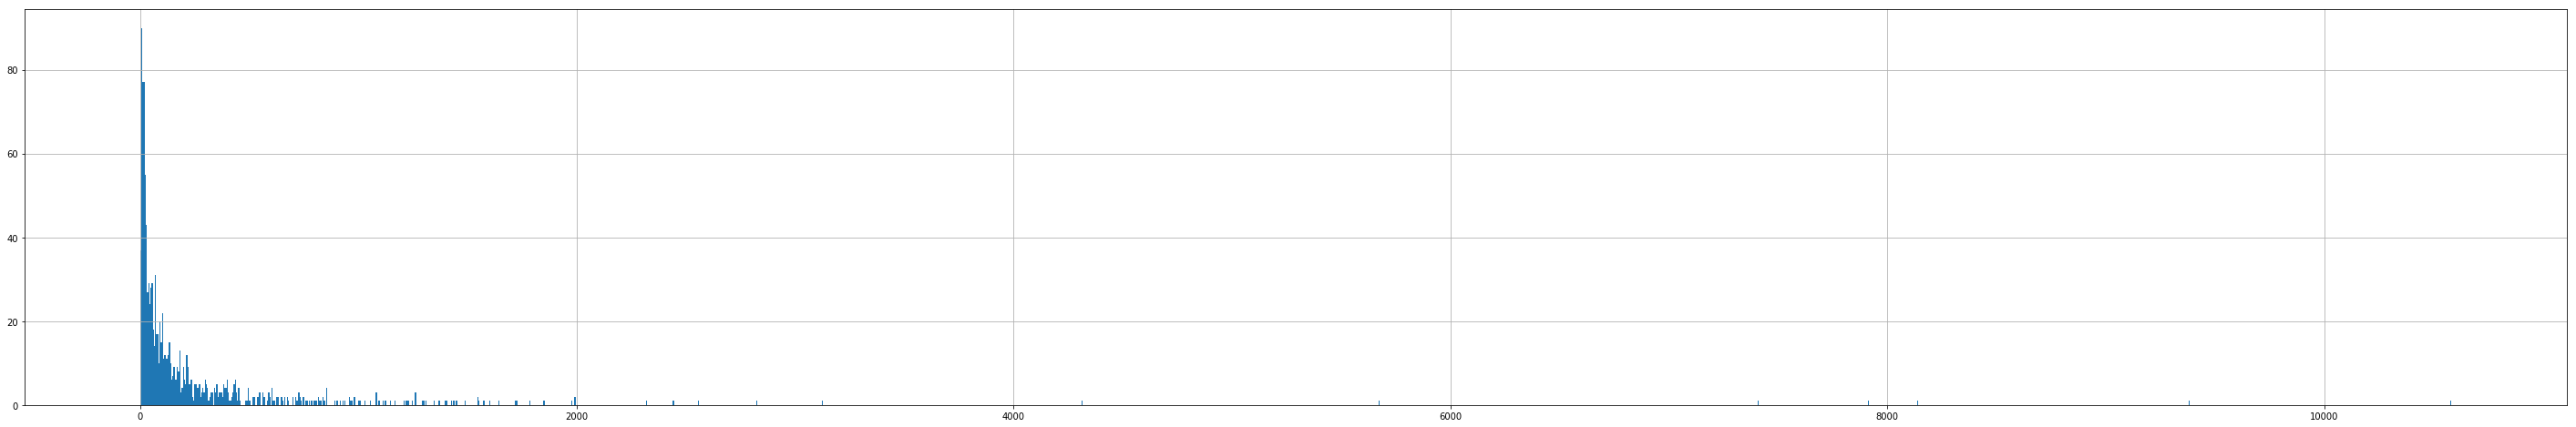

In [14]:
hist = manhattan_venues['Likes'].hist(bins=2000, figsize=(50,8))


## Most of the likes are between 0 and 1000 thus will assume the following :
<ol>
<li>If the venue has less than 25 or equal to likes then this venue is equivelant to one venue </li>
<li>If the venue has more than 25 like less than  or equal to 50 then this venue is equivelant to two venue of same category</li>
<li>If the venue has more than 50 like less than or equalt to 100 then this venue is equivelant to three venue of same category</li>
<li>If the venue has more than 100 likes less than or equalt to 200 then this venue is equivelant to five venue of same category</li>
<li>If the venue has more than 200 likes less than or equalt to 300 then this venue is equivelant to 7 venue of same category</li>
<li>If the venue has more than 300 likes less than or equalt to 500 then this venue is equivelant to ten venue of same category</li>
</ol>

In [15]:
manhattan_onehot.head()

# manhattan_onehot.groupby('Neighborhood').count()

,Likes,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Cafeteria,Café,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Egyptian Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Himalayan Restaurant,Historic Site,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Opera House,Optical Shop,Outdoor Sculpture,Outdoors & Recreation,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Trail,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Neighborhood
0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Marble Hill
1,23,0,0,0,0,

## We make modify the likes according the rule above

In [22]:
# function that change the likes according to the rule
def change_likes(row):
    
    try:
        Like_value = row['Likes']
    except:
        print("ops, something went wrong", Like_value)
    if Like_value <= 25:
        return 1
    elif Like_value > 25 and Like_value <= 50 : 
        return 2
    elif Like_value > 50 and Like_value <= 100 : 
        return 3
    elif Like_value > 100 and Like_value <= 200 : 
        return 5
    elif Like_value > 200 and Like_value <= 300 : 
        return 7
    elif Like_value > 300 and Like_value <= 500 : 
        return 10
    elif Like_value > 500 : 
        return 15

In [24]:
manhattan_onehot['Likes'] = manhattan_onehot.apply(change_likes, axis = 1)

In [25]:
manhattan_onehot.head()

,Likes,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Cafeteria,Café,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Egyptian Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Himalayan Restaurant,Historic Site,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Opera House,Optical Shop,Outdoor Sculpture,Outdoors & Recreation,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Trail,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Neighborhood
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Marble Hill
1,1,0,0,0,0,0,

## Multiply the venues quantity by likes columns to emphasize the quality of venues according to the defined rules (venues with more likes are equivalent to more number of venues)

In [32]:
manhattan_onehot.shape
manhattan_onehot_likes = manhattan_onehot.multiply(manhattan_onehot['Likes'] , axis="index")
# manhattan_onehot_likes = manhattan_onehot_likes.drop(['Neighborhood'],axis=1)

In [33]:
# @hidden_cell
#normalizing shit
# import pandas as pd
# from sklearn import preprocessing
# x = manhattan_onehot_likes['Likes']
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# x_scaled
# df = pd.DataFrame(x_scaled)
# df.columns = manhattan_onehot_likes.columns
# df.head()
# manhattan_onehot_likes['Neighborhood'] = manhattan_onehot['Neighborhood']#the neighborhoods column is 
# manhattan_onehot_likes.head()
# a, b = 0, 10
# x, y = 0,1
# df['Likes'] = (df['Likes'] - x) / (y - x) * (b - a) + a

In [34]:
manhattan_onehot_likes.head()

,Likes,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Cafeteria,Café,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Egyptian Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Himalayan Restaurant,Historic Site,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Opera House,Optical Shop,Outdoor Sculpture,Outdoors & Recreation,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Trail,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Neighborhood
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Marble Hill
1,1,0,0,0,0,0,

In [37]:
manhattan_onehot_likes.drop(['Likes'], axis = 1, inplace = True)

In [38]:
manhattan_onehot_likes['Neighborhood'] = manhattan_venues['Neighborhood']
manhattan_grouped = manhattan_onehot_likes.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Cafeteria,Café,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Egyptian Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Himalayan Restaurant,Historic Site,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Opera House,Optical Shop,Outdoor Sculpture,Outdoors & Recreation,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Trail,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Battery Park City,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.066667,0.0,0.0,0.166667,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.5,0.0,0.1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.133333,0.0,0.0,0.0,0.000000,0.0,0.0,0.066667,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.

In [40]:
manhattan_grouped.shape


(40, 243)

In [81]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()#convert columns to rows
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]#take all rows from row 1
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
            venue  freq
0      Food Court  1.00
1   Memorial Site  1.00
2            Park  0.57
3        Building  0.50
4  Scenic Lookout  0.50


----Carnegie Hill----
              venue  freq
0       Pizza Place  0.33
1  Ramen Restaurant  0.33
2  Community Center  0.33
3          Wine Bar  0.23
4               Bar  0.23


----Central Harlem----
                 venue  freq
0          Music Venue  0.23
1   African Restaurant  0.20
2  American Restaurant  0.20
3    French Restaurant  0.20
4              Library  0.17


----Chelsea----
                 venue  freq
0  American Restaurant  1.00
1   Italian Restaurant  0.57
2            Speakeasy  0.57
3         Cupcake Shop  0.50
4          Coffee Shop  0.50


----Chinatown----
                     venue  freq
0       Chinese Restaurant  0.67
1           Sandwich Place  0.57
2  New American Restaurant  0.50
3      American Restaurant  0.50
4       English Restaurant  0.50


----Civic Center----
                 v

In [82]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [92]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Battery Park City,Memorial Site,Food Court,Park,Scenic Lookout,Movie Theater
1,Carnegie Hill,Community Center,Pizza Place,Ramen Restaurant,Wine Bar,Bar
2,Central Harlem,Music Venue,African Restaurant,American Restaurant,French Restaurant,Park
3,Chelsea,American Restaurant,Speakeasy,Italian Restaurant,Coffee Shop,Fish Market
4,Chinatown,Chinese Restaurant,Sandwich Place,New American Restaurant,American Restaurant,Greek Restaurant


In [93]:
# set number of clusters
kclusters = 6

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

In [94]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,5,Donut Shop,Sandwich Place,Gym,Seafood Restaurant,Coffee Shop
1,Manhattan,Chinatown,40.715618,-73.994279,5,Chinese Restaurant,Sandwich Place,New American Restaurant,American Restaurant,Greek Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,5,Café,Tapas Restaurant,Caribbean Restaurant,Italian Restaurant,Park
3,Manhattan,Inwood,40.867684,-73.921210,5,Park,Mexican Restaurant,Wine Bar,Restaurant,Café
4,Manhattan,Hamilton Heights,40.823604,-73.949688,5,Cocktail Bar,Coffee Shop,Italian Restaurant,Wine Bar,Café


In [95]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [96]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
28,Battery Park City,Memorial Site,Food Court,Park,Scenic Lookout,Movie Theater


In [97]:
print (cluster)

5


In [98]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
15,Midtown,Coffee Shop,Grocery Store,Park,Bookstore,Hotel
26,Morningside Heights,Coffee Shop,Park,American Restaurant,Burger Joint,Bookstore


In [99]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,French Restaurant,Bagel Shop,Café
22,Little Italy,Sandwich Place,Pizza Place,Coffee Shop,Bakery,Ice Cream Shop
23,Soho,Italian Restaurant,Bakery,Mediterranean Restaurant,Mexican Restaurant,Pizza Place
24,West Village,Cocktail Bar,American Restaurant,Italian Restaurant,Bakery,Wine Bar
31,Noho,Italian Restaurant,Grocery Store,Southern / Soul Food Restaurant,Rock Club,Sandwich Place


In [100]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
13,Lincoln Square,Theater,Concert Hall,Performing Arts Venue,Indie Movie Theater,Movie Theater


In [101]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
33,Midtown South,Korean Restaurant,Hotel,Scenic Lookout,Hotel Bar,Burger Joint


In [102]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 5, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Marble Hill,Donut Shop,Sandwich Place,Gym,Seafood Restaurant,Coffee Shop
1,Chinatown,Chinese Restaurant,Sandwich Place,New American Restaurant,American Restaurant,Greek Restaurant
2,Washington Heights,Café,Tapas Restaurant,Caribbean Restaurant,Italian Restaurant,Park
3,Inwood,Park,Mexican Restaurant,Wine Bar,Restaurant,Café
4,Hamilton Heights,Cocktail Bar,Coffee Shop,Italian Restaurant,Wine Bar,Café
5,Manhattanville,BBQ Joint,Ramen Restaurant,Italian Restaurant,Supermarket,Coffee Shop
6,Central Harlem,Music Venue,African Restaurant,American Restaurant,French Restaurant,Park
7,East Harlem,Mexican Restaurant,Steakhouse,Cuban Restaurant,Bakery,French Restaurant
8,Upper East Side,Seafood Restaurant,Bakery,Italian Restaurant,Hotel Bar,Hotel
9,Yorkville,Park,Italian Restaurant,Pub,Monument / Landmark,Sandwich Place


In [103]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 6, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
